# To-Do List


- ~~We are getting random results on our RNN model due to the way Keras randomizes Numpy. We will need to figure out how to create a random_state for the functioned models~~
- ~~Verify model performance~~
  - ~~Equalize test data pool size for all models~~
  - ~~if we are incorrect we will need to change models/predict on new models:~~
    - ~~The only exception is Monterey County, the RNN model has a test score 0.0001% better than the ARIMA model~~
- ~~Attempt boosting RNN performance (we may not be able to keep function for RNN and may need to consider a gridsearch function).~~

- Create function to predict next 12 months
  - Copy code from RNN Fresno portion
  - Put title and fix x-ticks
  - ~~We are looking for 12 months of predictions after March 2023 to say that there will still indeed be perceivable seasonality in rate of unemployment~~
- Finish Markdown portions

- Finish comments on all cells

- Figure out how to hardcode visuals into google slides

- Include section on ways the data is incomplete:
  - Updated ag worker numbers for example

- Fix visualizations in notebook

## Dataset

__['Local Area Unemployment Statistics'](https://data.ca.gov/dataset/local-area-unemployment-statistics-laus)__  current as of March, 2023. <br>

## Business Problem

According to a recent article posted on what could be considered America's most uncelebrated holiday __['National Skilled Trades Day'](https://gvwire.com/2023/05/02/on-national-skilled-trades-day-americas-labor-shortage-looms/)__, there is a high need for skilled labor in the job market. Specifically, these are blue collar jobs in the trades (carpentry, HVAC, iron work, sheet metal, and aviation). There is a growing sentiment in the United States that there aren't people willing to work, but according to the article by Elen  Theodossiou and Steven F. Hipple, __['Unemployment remains high in 2010'](https://www.bls.gov/opub/mlr/2011/03/art1full.pdf)__, __"Workers with less education continued to experience a substantially higher unemployment rate than did better educated members of the labor force."__(4)
<br>

Taking into consideration that ALL the jobs highlighted in the article __['National Skilled Trades Day'](https://gvwire.com/2023/05/02/on-national-skilled-trades-day-americas-labor-shortage-looms/)__ require some kind of certificate of completion from a trade school or on the job training, it is our intention to look at counties in California with high unemployment rates and attempt to identify members of specific business sectors that the EDD (State of California Employment Development Department) can recruit for training in these high demand jobs.
<br>

Are there then groups in our data on counties and unemployment rate that may shed light on a potential group of candidates for a proposal for an EDD sponsored version of job training? That is the goal of our project.

## Method of Analysis/ Time Series Analysis of California's Unemployment Rate

Now that we have determined that there is a relationship between higher rates of unemployment and education we will look to determine a predictive model on the time series data we have for the top five crop producing counties in California and determine when the highest rate of unemployment (seasonality) occurs for each county and determine when a potential educational program could be implemented. <br>

With this data we can carefully craft the skeleton of a 6-month educational program and through the published opinions of local experts and government entities begin looking at potential fields of study/educational partners to reach out to in order to create a specialized educational program. <br>

Ultimately, the reason for making these suggestions is to help improve the __[living conditions](https://www.hcd.ca.gov/planning-and-community-development/housing-elements/building-blocks/farmworkers)__ and occupational opportunities of skilled laborers in the agricultural field. <br>

### College Educational Programs and Community College opportunties for trades and beyond

The reason for proposing trade school opportunities primarily is that there is a significantly smaller amount of __[training to deployment](https://toptrade.school/how-long-does-trade-school-take/)__ than traditional four year schools, something to the tune of 6 months to a year for a full time student. Since our proposal is for off-season migrant and farm workers who would be able to take advantage of these programs during the off-season, time is a crucial factor. From here however, once given the ability to rise financially and educationally, our educated workforce would be able to improve living conditions and explore other educational opportunities.

# Uncomment this section prior to running notebook for the first time.

# __&darr;__

In [1]:
# # google colab does not have fbprophet installed so we will need to pip install
# !pip install fbprophet
# !pip install prophet
# !pip install chart_studio

In [2]:
# import libraries
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# sqrt will be used to find RMSE for training and testing time series analysis
from math import sqrt
from tensorflow import keras
from tensorflow.keras import layers
# Sequential, Dense, and LSTM will be used to create RNN model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
# seed will act in a similar way that random_state works for classification models and ensures
# reproducability in regards to plotted data points and train/test scores
from numpy.random import seed
seed(1)
# sets seeds for base-python, numpy and tf
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()
# style.use will be the style of graphs throughout the notebook
%matplotlib inline
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [3]:
# bring in our 'county_ed' dataset
url = 'https://raw.githubusercontent.com/joshstruggles/Local-Area-Unemployment-Statistics-California/main/data/county_ed.csv'
df1 = pd.read_csv(url)
df1.head()

County  High School Grad  4 Year College Degree  \
0     Los Angeles              80.9                   34.0   
1         Alameda              89.0                   49.6   
2  San Bernardino              81.1                   21.9   
3       Riverside              83.0                   23.5   
4          Placer              94.8                   41.6   

   Highest Unemployment Rate  Highest UR was during Pandemic  \
0                       13.2                               1   
1                       11.5                               1   
2                       14.5                               0   
3                       14.8                               1   
4                       12.4                               1   

   2017 Census of Agriculture Rank(Crops)  
0                                      31  
1                                      41  
2                                      33  
3                                      14  
4                                      40

In [4]:
# Since we are only planning on focusing on the rop 5 producing counties for the scope of this project, call on .head() to
# get those 5 counties.
df1 = df1.sort_values('2017 Census of Agriculture Rank(Crops)', ascending = True)
df1.head()

County  High School Grad  4 Year College Degree  \
38       Fresno              77.9                   22.6   
32     Monterey              73.0                   26.5   
42         Kern              75.9                   17.6   
49       Tulare              72.6                   15.2   
46  San Joaquin              80.3                   19.5   

    Highest Unemployment Rate  Highest UR was during Pandemic  \
38                       19.0                               0   
32                       20.1                               0   
42                       18.6                               1   
49                       24.6                               0   
46                       18.3                               0   

    2017 Census of Agriculture Rank(Crops)  
38                                       1  
32                                       2  
42                                       3  
49                                       4  
46                                       5

## Top 5 Crop Producing Counties in California

For the purpose of our analysis we will be looking at the top 5 crop producing counties in California: <br>

- Fresno County
- Monterey County
- Kern County
- Tulare County
- San Joaquin County

In [5]:
# Bring in the 'counties.csv' dataset from our EDA_notebook. This data will already be pruned and marked in the EDA_notebook
url1 = 'https://raw.githubusercontent.com/joshstruggles/Local-Area-Unemployment-Statistics-California/main/data/counties.csv'
df = pd.read_csv(url1)
df.head()

month_year                           Area Name  Labor Force  Employment  \
0    1976-04                          California      9692493     8835232   
1    1976-04                  Los Angeles County      3362757     3082562   
2    1976-04  Los Angeles-Long Beach-Glendale MD      3362757     3082562   
3    1976-08                          California     10115963     9196592   
4    1976-08                  Los Angeles County      3430133     3114869   

   Unemployment  Unemployment Rate  
0        857261              0.088  
1        280195              0.083  
2        280195              0.083  
3        919371              0.091  
4        315264              0.092

In [6]:
df.set_index('month_year', inplace = True)

## County Variables

Each county in our analysis will be able to be called upon by a variable name that we can set, below.

In [7]:
# Create variable names of the five counties that we will perform analysis on

Fresno = df.loc[df['Area Name'] == 'Fresno County']
Monterey = df.loc[df['Area Name'] == 'Monterey County']
Kern = df.loc[df['Area Name'] == 'Kern County']
Tulare = df.loc[df['Area Name'] == 'Tulare County']
San_Joaquin = df.loc[df['Area Name'] == 'San Joaquin County']

## Function for stationary county data

Running the following line of code : diff(county) will give us a visual of stationary data for the county specified.

In [8]:
# Function below does the following:
## Drops unnecessary columns from specified county dataset
### Creates and plots stationary data for visual verification
#### Prints 'Test Statistic', 'p-value', '#Lags Used' & 'Number of Observations Used'

# import adfuller
from statsmodels.tsa.stattools import adfuller

# import diff() function from our work_shown notebook
## name must be in '_' because it is considered a string in this function
def diff(county, name):
    county = county.sort_index()
    county = county.drop(['Area Name',
                          'Labor Force',
                          'Employment',
                          'Unemployment'],
                       axis =1)

    county_diff = county.diff(periods =1)
    county_diff = county_diff.dropna()

# Plot county with trends removed
    county_diff.plot(figsize = (18,6))
    plt.xlabel('Year', fontsize = 18)
    plt.ylabel('Unemployment Rate')
    plt.title(f"{name} County Stationary data", fontsize = 18);

    dftest = adfuller(county_diff)

# Display testing data
    dfoutput = pd.Series(
                dftest[0:4],
                index=['Test Statistic',
                       'p-value',
                       '#Lags Used',
                       'Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    display(dfoutput)

# __[Fresno County](https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/County_Profiles/California/cp06019.pdf)__ Stationary Data

Fresno County, the number one crop producing county in California has services available for migrant and farm workers to receive high school equivalent educations through several programs. One program that I am familiar with is through West Hills College and the __[Migrant High School Equivalency Program](https://westhillscollege.com/lemoore/resources/student-support/high-school-equivalency/)__ as well as college prep course through their __[College Assistance Migrant Program (CAMP)](https://westhillscollege.com/coalinga/resources/student-support/camp/services.php)__. <br>

Test Statistic                  -3.851484
p-value                          0.002422
#Lags Used                      16.000000
Number of Observations Used    380.000000
Critical Value (1%)             -3.447676
Critical Value (5%)             -2.869176
Critical Value (10%)            -2.570838
dtype: float64

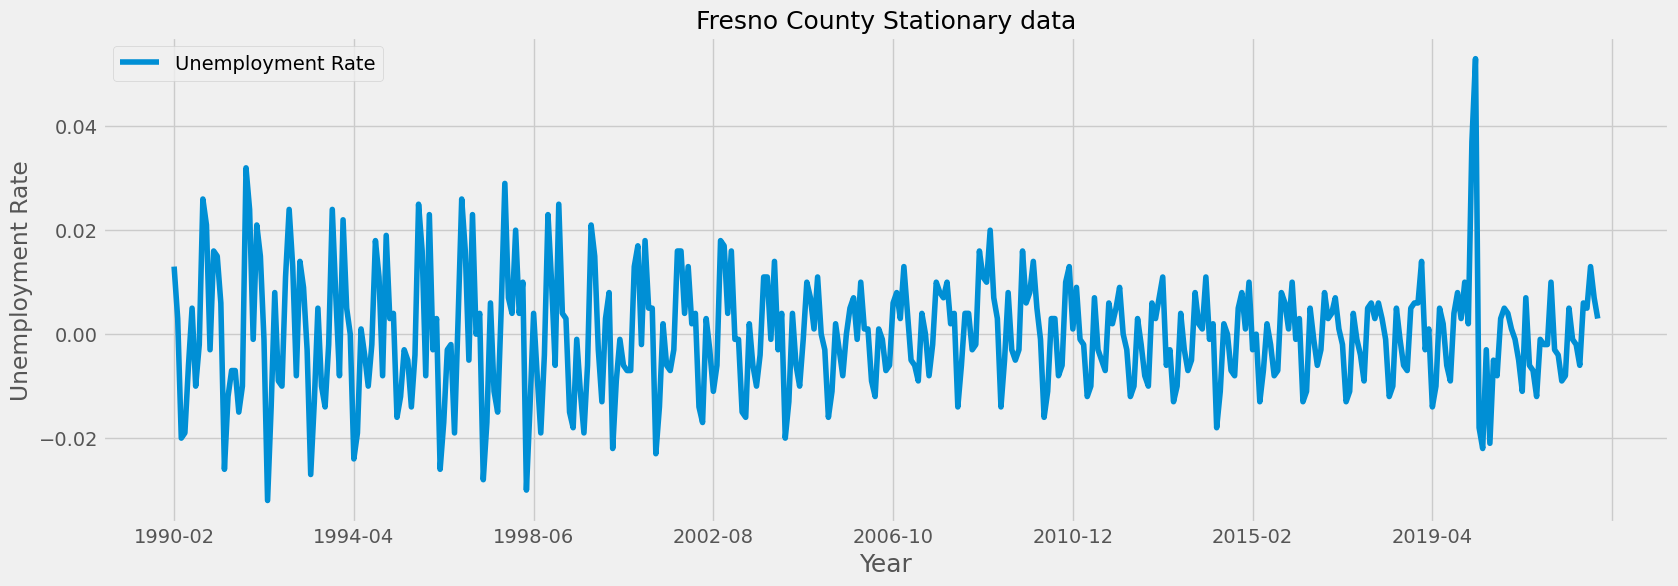

In [9]:
# We have a function above for the steps that we will perform for most of Fresno County data,
# but this area is meant as a proof of concept, that these functions work and are original code
# unless otherwise specified.

# call our diff() function on Fresno county data to make stationary
Fresno_stationary = diff(Fresno, 'Fresno')
Fresno_stationary

In [10]:
fresno = Fresno.copy()
Fresno.tail()

Area Name  Labor Force  Employment  Unemployment  \
month_year                                                         
2022-10     Fresno County       454600      428400         26100   
2022-09     Fresno County       456500      432700         23800   
2023-02     Fresno County       466100      427600         38500   
2023-01     Fresno County       458500      423800         34600   
2023-03     Fresno County       467000      427000         40100   

            Unemployment Rate  
month_year                     
2022-10                 0.058  
2022-09                 0.052  
2023-02                 0.083  
2023-01                 0.076  
2023-03                 0.086

In [11]:
# Drop columns to prep data for time series analysis
Fresno_tsa = Fresno.drop(['Area Name',
             'Labor Force',
             'Employment',
             'Unemployment'], axis =1 )
Fresno_tsa.head()

Unemployment Rate
month_year                   
1990-04                 0.122
1990-08                 0.092
1990-12                 0.134
1990-02                 0.139
1990-01                 0.126

In [12]:
# replicate stationary data
Fresno_arma = Fresno_tsa.diff(periods =1)

In [13]:
# create cutoff variable for train/test split
cutoff = round(Fresno_arma.shape[0] * 0.75)
cutoff

298

Cell is being used as a holder for the graph function below:

xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax), 2))


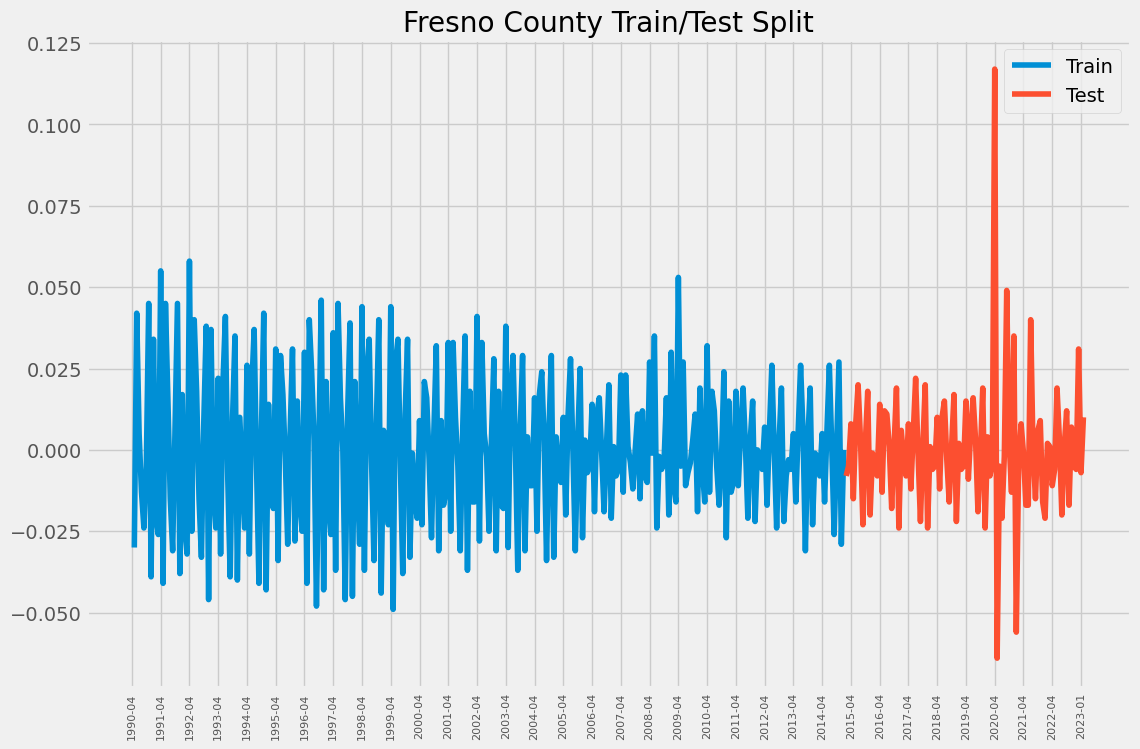

In [14]:
# plot our train/test split
train = Fresno_arma[:cutoff]
test = Fresno_arma[cutoff: ]

fig, ax = plt.subplots(figsize = (12,8))
plt.xticks(fontsize=8, rotation=90)
ax.plot(train, label = 'Train')
ax.plot(test, label = 'Test')
ax.set_title('Fresno County Train/Test Split')
ax.set_xticks(range(0,len(Fresno_arma), 12))

plt.legend();

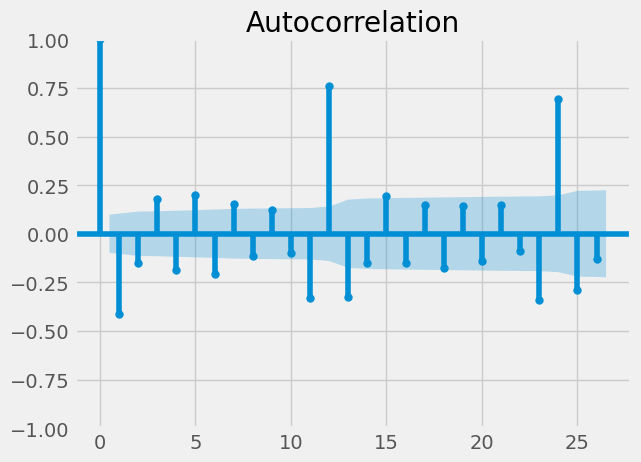

In [15]:
# import acf, pacf and plotting tools
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(Fresno_arma.dropna());

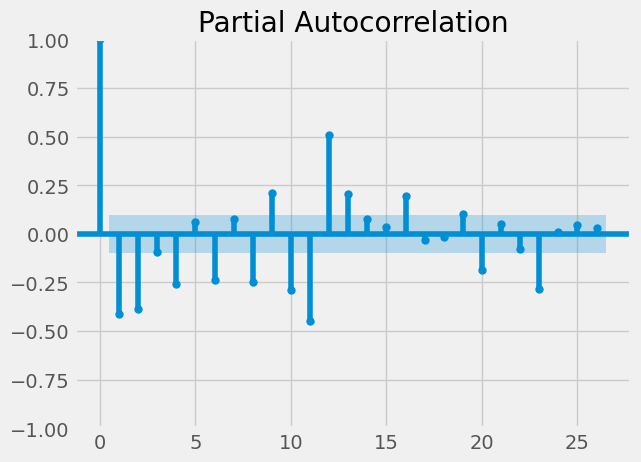

In [16]:
# plot pacf and get our ar term
plot_pacf(Fresno_arma.dropna());

In [17]:
# import ARIMA from statsmodels.tsa.arima.model

# Let's create our baseline model
from statsmodels.tsa.arima.model import ARIMA
arma_Fresno = ARIMA(train, order = (0,0,0)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

In [18]:
print(arma_Fresno.summary())

                               SARIMAX Results                                
Dep. Variable:      Unemployment Rate   No. Observations:                  298
Model:                          ARIMA   Log Likelihood                 687.520
Date:                Tue, 20 Jun 2023   AIC                          -1371.040
Time:                        22:16:26   BIC                          -1363.645
Sample:                             0   HQIC                         -1368.080
                                - 298                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.204e-05      0.001     -0.030      0.976      -0.003       0.003
sigma2         0.0006   5.99e-05      9.531      0.000       0.000       0.001
Ljung-Box (L1) (Q):                  55.81   Jarque-

In [19]:
train = train.dropna()

In [20]:
# y_hat variable is prediction of training data from ARIMA baseline model
y_hat = arma_Fresno.predict(type='levels')
y_hat = y_hat[1:]

In [21]:
# RMSE on our baseline predictor

# import mean_squared_error from sklearn.metrics
from sklearn.metrics import mean_squared_error


np.sqrt(mean_squared_error(train, y_hat))

0.02390135451243794

We will need to figure out how to address acf and pacf. Perhaps a gridsearch function with all of the potential values that could improve our AIC score.

### Gridsearch Function

Thank you to Ely and their __[article](https://medium.com/@ely-lin/grid-searching-time-series-models-1214dfa3de60)__ from medium.com for the two functions below. These function as gridsearch functions and will tell us our best model performance.

In [22]:
# Gridsearch function is meant to find best combination of (p,d,q) and will be relied upon to
# give us the best performant ARIMA model based on best AIC score

def gridsearch(dataset, p_list, d_list, q_list):
    # set initial best AIC score at infinity to start lowering it
    best_aic=float('inf')
    for p in p_list:
        for d in d_list:
            for q in q_list:
                try:
                    # fit the model to this set of parameters
                    model = ARIMA(dataset, order=(p,d,q)).fit()
                    # assign the model's aic attribute to a variable
                    aic = model.aic
                    # compare it to the previous set
                    if aic < best_aic:
                        best_aic=aic
                        best_order = (p,d,q)
                        best_model = model
                except:
                    continue
    return best_aic, best_order, best_model

In [23]:
## Uncomment whole cell to run

## runs gridsearch on train, will take about 7 minutes

# b_aic, b_order, b_model = gridsearch(train,
#                                      [0,6,12,18],
#                                      [1,2,3,4,5,6],
#                                      [0,6,12,18])
# print(f'The best AIC score is {b_aic}')
# print(f'The best order set is {b_order}')

## Expected Output: The best AIC score is -1960.1035756349838
## Expected Output: The best order set is (18, 1, 0)

In [24]:
arma_Fresno = ARIMA(train, order = (18,1,0)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

In [25]:
print(arma_Fresno.summary())

                               SARIMAX Results                                
Dep. Variable:      Unemployment Rate   No. Observations:                  297
Model:                ARIMA(18, 1, 0)   Log Likelihood                 998.882
Date:                Tue, 20 Jun 2023   AIC                          -1959.763
Time:                        22:16:36   BIC                          -1889.646
Sample:                             0   HQIC                         -1931.690
                                - 297                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3590      0.055    -24.556      0.000      -1.467      -1.251
ar.L2         -1.6687      0.081    -20.526      0.000      -1.828      -1.509
ar.L3         -1.7836      0.115    -15.519      0.0

In [26]:
# Because there is a drift of 1 we will have to drop nulls
train = train.dropna()

In [27]:
# RMSE for our new model
y_hat = arma_Fresno.predict(typ='levels')
np.sqrt(mean_squared_error(train,y_hat))

0.009933621406585177

In [28]:
# fit same ARIMA parameters to  test set
arma_Fresno_test = ARIMA(test, order = (18,1,0)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

In [29]:
# Get aic score for test score
print(arma_Fresno_test.aic)

-489.2174127815889


In [30]:
# RMSE score for test data
y_hat = arma_Fresno_test.predict(typ='levels')
np.sqrt(mean_squared_error(test, y_hat))

0.01654086775427879

### Predict Fresno County's incoming unemployment rates

Our prophet model did not perform better than our gridsearch model, we will move forward with the gridsearch model and use that to make some predictions on the next year.

In [31]:
# forecast is requesting 112 values (test set + 12 months into the future)
forecast = arma_Fresno.forecast(112)
forecast

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


297    0.000637
298   -0.009120
299    0.005261
300   -0.016623
301    0.006287
         ...   
404   -0.001702
405    0.004765
406   -0.007581
407    0.001918
408   -0.007858
Name: predicted_mean, Length: 112, dtype: float64

In [32]:
# Call forecast.index.tolist() in order to get full set of indexes to
# call on and match to date_time
forecast.index.tolist()

[297,
 298,
 299,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 316,
 317,
 318,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359,
 360,
 361,
 362,
 363,
 364,
 365,
 366,
 367,
 368,
 369,
 370,
 371,
 372,
 373,
 374,
 375,
 376,
 377,
 378,
 379,
 380,
 381,
 382,
 383,
 384,
 385,
 386,
 387,
 388,
 389,
 390,
 391,
 392,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408]

In [33]:
# test.index.tolist() should match len(forecast) so that we can
# create predictive dataset
test.index.tolist()

['2014-10',
 '2014-09',
 '2015-04',
 '2015-08',
 '2015-12',
 '2015-02',
 '2015-01',
 '2015-07',
 '2015-06',
 '2015-03',
 '2015-05',
 '2015-11',
 '2015-10',
 '2015-09',
 '2016-04',
 '2016-08',
 '2016-12',
 '2016-02',
 '2016-01',
 '2016-07',
 '2016-06',
 '2016-03',
 '2016-05',
 '2016-11',
 '2016-10',
 '2016-09',
 '2017-04',
 '2017-08',
 '2017-12',
 '2017-02',
 '2017-01',
 '2017-07',
 '2017-06',
 '2017-03',
 '2017-05',
 '2017-11',
 '2017-10',
 '2017-09',
 '2018-04',
 '2018-08',
 '2018-12',
 '2018-02',
 '2018-01',
 '2018-07',
 '2018-06',
 '2018-03',
 '2018-05',
 '2018-11',
 '2018-10',
 '2018-09',
 '2019-04',
 '2019-08',
 '2019-12',
 '2019-02',
 '2019-01',
 '2019-07',
 '2019-06',
 '2019-03',
 '2019-05',
 '2019-11',
 '2019-10',
 '2019-09',
 '2020-04',
 '2020-08',
 '2020-12',
 '2020-02',
 '2020-01',
 '2020-07',
 '2020-06',
 '2020-03',
 '2020-05',
 '2020-11',
 '2020-10',
 '2020-09',
 '2021-04',
 '2021-08',
 '2021-12',
 '2021-02',
 '2021-01',
 '2021-07',
 '2021-06',
 '2021-03',
 '2021-05',
 '20

In [34]:
# Create dataframe out of forecast
forecast = pd.DataFrame(forecast)

In [35]:
forecast.tail()

predicted_mean
404       -0.001702
405        0.004765
406       -0.007581
407        0.001918
408       -0.007858

In [36]:
# List functions as an array of dates, (year, month) that will serve as our test set and prediction set
# the indented portion is the indexes for our prediction. Effectively the indentation only exists
# to highlight the final twelve months of prediction.
list = ['2014-10',
 '2014-09',
 '2015-04',
 '2015-08',
 '2015-12',
 '2015-02',
 '2015-01',
 '2015-07',
 '2015-06',
 '2015-03',
 '2015-05',
 '2015-11',
 '2015-10',
 '2015-09',
 '2016-04',
 '2016-08',
 '2016-12',
 '2016-02',
 '2016-01',
 '2016-07',
 '2016-06',
 '2016-03',
 '2016-05',
 '2016-11',
 '2016-10',
 '2016-09',
 '2017-04',
 '2017-08',
 '2017-12',
 '2017-02',
 '2017-01',
 '2017-07',
 '2017-06',
 '2017-03',
 '2017-05',
 '2017-11',
 '2017-10',
 '2017-09',
 '2018-04',
 '2018-08',
 '2018-12',
 '2018-02',
 '2018-01',
 '2018-07',
 '2018-06',
 '2018-03',
 '2018-05',
 '2018-11',
 '2018-10',
 '2018-09',
 '2019-04',
 '2019-08',
 '2019-12',
 '2019-02',
 '2019-01',
 '2019-07',
 '2019-06',
 '2019-03',
 '2019-05',
 '2019-11',
 '2019-10',
 '2019-09',
 '2020-04',
 '2020-08',
 '2020-12',
 '2020-02',
 '2020-01',
 '2020-07',
 '2020-06',
 '2020-03',
 '2020-05',
 '2020-11',
 '2020-10',
 '2020-09',
 '2021-04',
 '2021-08',
 '2021-12',
 '2021-02',
 '2021-01',
 '2021-07',
 '2021-06',
 '2021-03',
 '2021-05',
 '2021-11',
 '2021-10',
 '2021-09',
 '2022-04',
 '2022-08',
 '2022-02',
 '2022-01',
 '2022-07',
 '2022-06',
 '2022-03',
 '2022-05',
 '2022-11',
 '2022-10',
 '2022-09',
 '2023-02',
 '2023-01',
 '2023-03',
       '2023-04',
       '2023-05',
       '2023-06',
       '2023-07',
       '2023-08',
       '2023-09',
       '2023-10',
       '2023-11',
       '2023-12',
       '2024-01',
       '2024-02',
       '2024-03'
       ]

forecast['Year'] = list

forecast

predicted_mean     Year
297        0.000637  2014-10
298       -0.009120  2014-09
299        0.005261  2015-04
300       -0.016623  2015-08
301        0.006287  2015-12
..              ...      ...
404       -0.001702  2023-11
405        0.004765  2023-12
406       -0.007581  2024-01
407        0.001918  2024-02
408       -0.007858  2024-03

[112 rows x 2 columns]

In [37]:
# set_index('Year')to plot datetime data
forecast = forecast.set_index('Year')

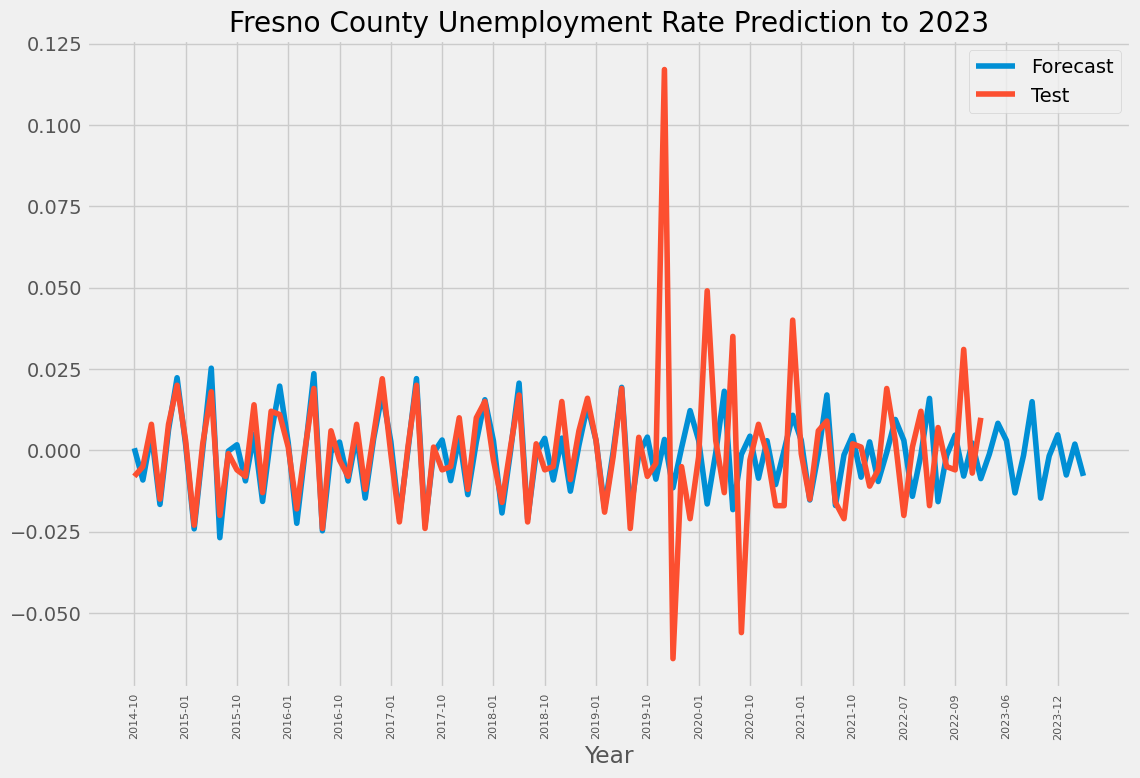

In [38]:
# This plot returns only the test set and forecast of our gridsearch ARIMA
# model. Data returned is stationary
fig, ax = plt.subplots(figsize = (12,8))
plt.xticks(fontsize=8, rotation=90)
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax), 2))
# ax.plot(train, label = 'Train')
ax.plot(forecast, label = 'Forecast')
ax.plot(test, label = 'Test')
ax.set_title('Fresno County Unemployment Rate Prediction to 2023')
ax.set_xlabel('Year')
ax.set_xticks(range(0,len(forecast), 6))
ax.legend();

According to our predictive model (set for 12 months from March 2023) we will see a lower rate of unemployment than we have historically.

In [39]:
# one_year is meant to be a variable for only our 12 month prediction based on
# the results of our ARIMA model
one_year = forecast.reset_index()
one_year

Year  predicted_mean
0    2014-10        0.000637
1    2014-09       -0.009120
2    2015-04        0.005261
3    2015-08       -0.016623
4    2015-12        0.006287
..       ...             ...
107  2023-11       -0.001702
108  2023-12        0.004765
109  2024-01       -0.007581
110  2024-02        0.001918
111  2024-03       -0.007858

[112 rows x 2 columns]

In [40]:
# index the last twelve months of our predictor
one_year = one_year[99:112]
one_year

Year  predicted_mean
99   2023-03       -0.008686
100  2023-04       -0.001151
101  2023-05        0.008308
102  2023-06        0.002999
103  2023-07       -0.013091
104  2023-08       -0.001542
105  2023-09        0.014958
106  2023-10       -0.014682
107  2023-11       -0.001702
108  2023-12        0.004765
109  2024-01       -0.007581
110  2024-02        0.001918
111  2024-03       -0.007858

In [41]:
# Reset indexes to 'Year'
one_year = one_year.set_index('Year')

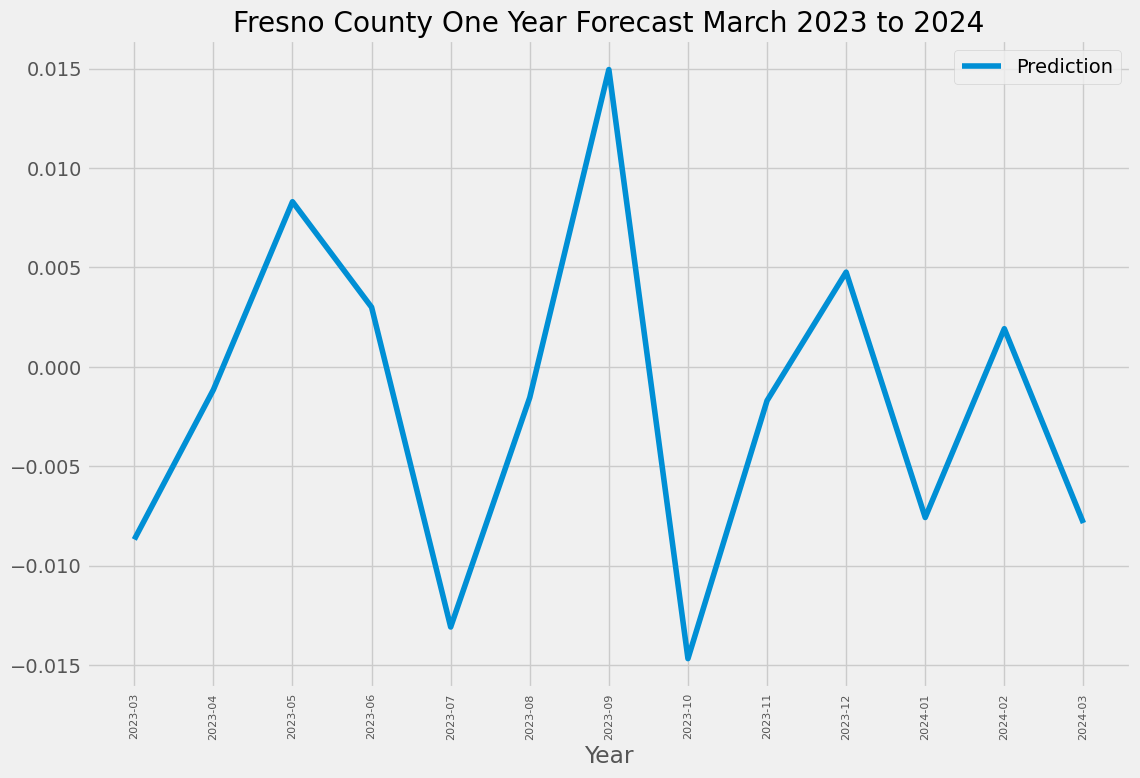

In [42]:
# plot our one year forecast on Fresno county unemployment rate data
fig, ax = plt.subplots(figsize = (12,8))
plt.xticks(fontsize=8, rotation=90)
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax), 1))

ax.plot(one_year, label = 'Prediction')

ax.set_title('Fresno County One Year Forecast March 2023 to 2024')
ax.set_xlabel('Year')
ax.set_xticks(range(0,len(one_year), 1))
ax.legend();

Based on the forecasted dates for Fresno County's rate of unemployment, a potential educational program could be done on a track system, 2 months in school during the months of April - June, 2 months from mid-July - Mid September, and 4  months from mid October to February. While this likely would not be a "one size fits all" program, if flexible instruction were able to be offered during these timesthere could potentially be a wave of trained skilled labor in 1.5 years from Fresno County.

## Function to plot forecast information and one year forecast

Right! Great to walk through it once, but if we can prevent it, let's try to consolidate some space and create a function. <br>

The below lines of code in the next box are meant to plot two things: <br>

- Test data with best performant model predictions based on AIC scores. Predictions are set to 12 months beyond the training data.
- Plot of 12 month prediction for further analysis on when an educational program may be able to occur during seasonal unemployment, as we predict this could be different from county to county.

In [43]:
# In order to prevent repetetive lines of code here is a function for plotting a one year forecast
## 'one' is to be the variable name of the county
### 'name' is meant to be county name in quotes as it will be considered a string in the rest of the function

def one_year_forecast(one, name):

  # plots test data and forecast data
  fig, ax = plt.subplots(figsize = (12,8))
  plt.xticks(fontsize=8, rotation=90)
  xmin, xmax = ax.get_xlim()
  ax.set_xticks(np.round(np.linspace(xmin, xmax), 2))
  ax.plot(one, label = 'Predictions')
  ax.plot(test, label = 'Test')
  # name again will be considered a string so for the sake of reproducability, use quotes around 'name' when calling  this function
  ax.set_title(f'{name} County Unemployment Rate Prediction to 2023')
  ax.set_xlabel('Year')
  ax.set_xticks(range(0,len(one), 6))
  ax.legend();


  one = one.reset_index()
  # plots only 12 month predictive data
  one = one[99:112]

  one = one.set_index('Year')

  fig, ax = plt.subplots(figsize = (12,8))
  plt.xticks(fontsize=8, rotation=90)
  xmin, xmax = ax.get_xlim()
  ax.set_xticks(np.round(np.linspace(xmin, xmax), 2))

  ax.plot(one, label = 'Predictions')

  ax.set_title(f'{name} County One Year Forecast March 2023 to 2024')
  ax.set_xlabel('Year')
  ax.set_xticks(range(0,len(one), 1))
  ax.legend();


### Function for effect on unemployment rate

In [44]:
# as a note, you will still need to do all of the preprocessing steps for a given county:
## find ag/migrant employment numbers and consider how many of these workers would be able to
### convert to skilled trade workers, potentially
def effect(county, x): # x serves as our numerical value placeholder

    # insurance that our index is sorted based on actual time series
    county = county.sort_index()
    # slice dataframe to only include 2019's data
    county_2019 = county.iloc[348:360]
    # create new variable copy
    county_2019_ur = county_2019.copy()
    # simple math for employment numbers, x is an input from our previous preprocessing steps
    county_2019['Employment'] = county_2019['Employment'].astype(int) + x
    # simple math for unemployment
    county_2019['Unemployment'] = county_2019['Unemployment'].astype(int) - x
    # divide unemployment by labor force to get our new unemployment rate
    county_2019['Unemployment Rate'] = county_2019['Unemployment'].astype(int)/county_2019['Labor Force']
    # create new column 'Unemployment Rate Change' to show rate of unemployment change
    county_2019['Unemployment Rate Change'] = (county_2019_ur['Unemployment Rate'] - county_2019['Unemployment Rate'])
    # return 2019 data
    return county_2019

### FB Prophet: Fresno

Let's try Facebook's Prophet model to see if we can create a better performant model than our Gridsearch Function.

In [45]:
# import tools for prophet
import prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet

In [46]:
# Call on original 'Fresno' variable and reset_index()
Fresno = Fresno.reset_index()

In [47]:
Fresno = Fresno.drop(['Area Name', 'Labor Force', 'Employment',
             'Unemployment'], axis =1)

In [48]:
Fresno.head()

month_year  Unemployment Rate
0    1990-04              0.122
1    1990-08              0.092
2    1990-12              0.134
3    1990-02              0.139
4    1990-01              0.126

In [49]:
# Based on documentation, column names are hard coded as 'ds' and 'y'
Fresno.columns = ['ds', 'y']

In [50]:
# Create new datetime column out of 'ds', where 'ds' functions as our
## independent variable
Fresno['ds'] = pd.to_datetime(Fresno['ds'])
Fresno.tail()

ds      y
393 2022-10-01  0.058
394 2022-09-01  0.052
395 2023-02-01  0.083
396 2023-01-01  0.076
397 2023-03-01  0.086

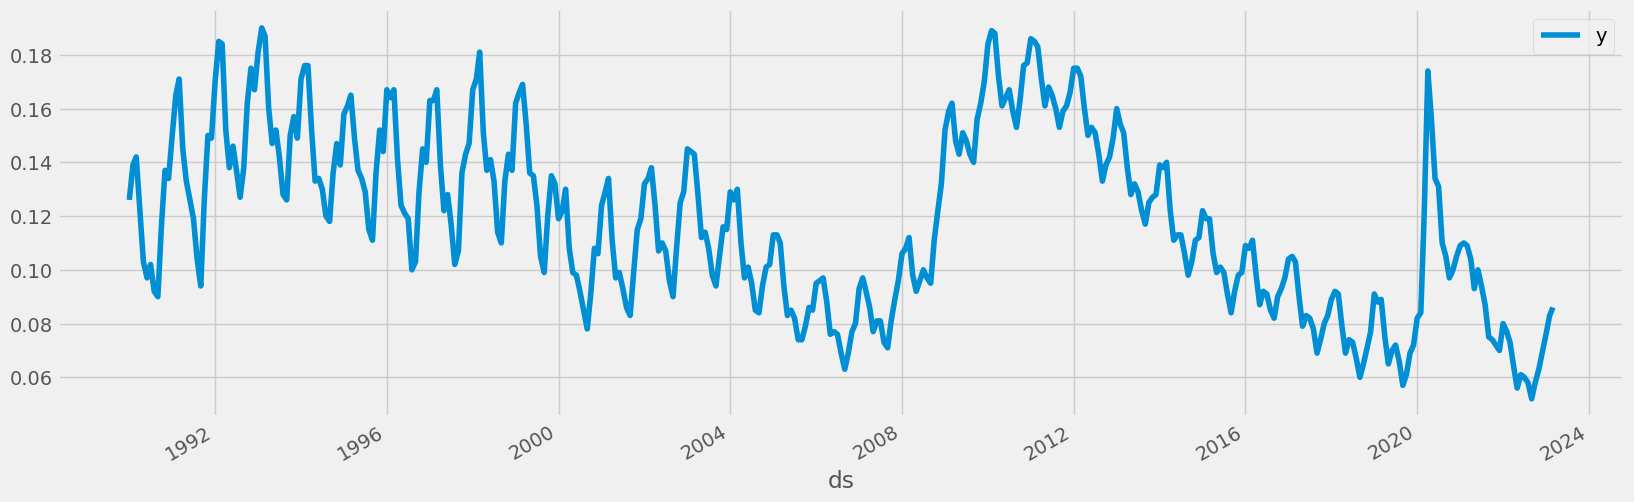

In [51]:
# plot data, should look fairly familiar
Fresno.plot(x='ds', y='y', figsize = (18,6));

In [52]:
len(Fresno)

398

In [53]:
# call same cutoff block as before
cutoff = round(Fresno.shape[0] * 0.75)

# plot our new split
train = Fresno[:cutoff]
test = Fresno[cutoff: ]

In [54]:
# fit prophet onto our training set and make some predictions,
## for now we will just make predictions onto full test set to
### test score and get RMSE for test set
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods = 100, freq = 'M')
forecast = m.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp882o6j5p/jh29dsmh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp882o6j5p/ri8txkse.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56564', 'data', 'file=/tmp/tmp882o6j5p/jh29dsmh.json', 'init=/tmp/tmp882o6j5p/ri8txkse.json', 'output', 'file=/tmp/tmp882o6j5p/prophet_model4qb5grhy/prophet_model-20230620221649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:16:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:16:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [55]:
forecast.tail()

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
393 2022-11-30  0.198041    0.174811    0.229099     0.189180     0.208149   
394 2022-12-31  0.198503    0.188383    0.244973     0.189490     0.208852   
395 2023-01-31  0.198966    0.192420    0.246891     0.189812     0.209525   
396 2023-02-28  0.199384    0.196907    0.253535     0.190109     0.210051   
397 2023-03-31  0.199846    0.178122    0.235989     0.190463     0.210702   

     additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
393        0.003870              0.003870              0.003870  0.003870   
394        0.017927              0.017927              0.017927  0.017927   
395        0.019817              0.019817              0.019817  0.019817   
396        0.024137              0.024137              0.024137  0.024137   
397        0.007039              0.007039              0.007039  0.007039   

     yearly_lower  yearly_upper  multiplicative_terms  \
393      0.003870      0.003870                   0.0   
394      0.017927      0.017927                   0.0   
395      0.019817      0.019817                   0.0   
396      0.024137      0.024137                   0.0   
397      0.007039      0.007039                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper      yhat  
393                         0.0                         0.0  0.201911  
394                         0.0                         0.0  0.216430  
395                         0.0                         0.0  0.218783  
396                         0.0                         0.0  0.223521  
397                         0.0                         0.0  0.206885

In [56]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
393 2022-11-30  0.201911    0.174811    0.229099
394 2022-12-31  0.216430    0.188383    0.244973
395 2023-01-31  0.218783    0.192420    0.246891
396 2023-02-28  0.223521    0.196907    0.253535
397 2023-03-31  0.206885    0.178122    0.235989

In [57]:
test.tail()

ds      y
393 2022-10-01  0.058
394 2022-09-01  0.052
395 2023-02-01  0.083
396 2023-01-01  0.076
397 2023-03-01  0.086

In [58]:
# plot our prophet model
plot_plotly(m, forecast)

In [59]:
# import rmse from statsmodels to predict rmse score for prophet
from statsmodels.tools.eval_measures import rmse

In [60]:
predictions = forecast.iloc[cutoff:]['yhat']

In [61]:
# Settle the bet, is this a better performant model than the previous one?
print("Root Mean Squared Error between actual and  predicted values: ",rmse(predictions,test['y']))
print("Mean Value of Test Dataset:", test['y'].mean())


Root Mean Squared Error between actual and  predicted values:  0.09581784993317125
Mean Value of Test Dataset: 0.08828


Though prophet was not able to create a better performant model than our gridsearch function, let's create a function that completes the steps from our prophet model.

## FB Prophet Function

In [62]:
# function to return graph of county's historical unemployment rate and baseline prophet model along with RMSE score
def prophet(county):

    county = county.reset_index()

    county = county.drop(['Area Name', 'Labor Force', 'Employment',
             'Unemployment'], axis =1)

    county.columns = ['ds', 'y']

    county['ds'] = pd.to_datetime(county['ds'])



    cutoff = round(county.shape[0] * 0.75)

    train = county[:cutoff]
    test = county[cutoff: ]

    m = Prophet()
    m.fit(train)
    future = m.make_future_dataframe(periods = 100, freq ='M')
    forecast = m.predict(future)


    county.plot(x = 'ds', y = 'y', figsize = (18,6))
    predictions = forecast.iloc[cutoff:]['yhat']
    print("Root Mean Squared Error between actual and  predicted values: ",rmse(predictions,test['y']))
    print("Mean Value of Test Dataset:", test['y'].mean())
    return plot_plotly(m, forecast)
    return

Based on these scores our ARIMA model looks to have performed better on the Fresno county data. For the remainder of our ARIMA and Prophet comparison models we will predict only on the best performant model for a given county's data.

## Effect on Unemployment

The most recent data available regarding __[Fresno County](https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/County_Profiles/California/cp06019.pdf)__'s ag workforce (2017) puts the total number of workers at 8,206. These are split into: <br>
- 5,554 male workers
- 2,652 female workers
- 556 of which are under the age of 35
- 4,760 between the ages of 35-64
- 2,890 who are 65 or older. <br>

Likely not all candidates would make it through the entire educational program for trade schools, in fact according to __[Graduation Rates at American Trade School](https://www.univstats.com/colleges/american-trade-school/graduation-rate/)__ graduation rates of this specific trade school were slightly above 50% <br>

Let's take a look at the number of actual unemployed and consider that 25% (a rudimentary estimate) of our total seasonally unemployed workers make it through a trade school and are able to be employed in trades. <br>

For the sake of our hypothetical scenario we can consider that 25% of the total population of workers would apply for this program, and if 50% are expected to graduate: <br>

- 2051.5 potential students at a 50% anticipated graduation rate
    - 1025.75 converted students to active trade school grads

In [63]:
# We will be using fresno variable for Prophet and RNN so we should create a proxy of that variable
Fresno = fresno.sort_index()

Historically, February is the month with the highest level of unemployment. September looks to be the month of highest employment. With this in mind, let's take a look at our dataset's historical numbers; which year was February the highest in unemployment rate and the same for September. We could also just take median and do our research on that year. <br>

Let's take 2017 (the year that we have # of employed ag/migrant workers figures) and base our effect on unemployment analysis on that.

In [64]:
Fresno.tail()

Area Name  Labor Force  Employment  Unemployment  \
month_year                                                         
2022-10     Fresno County       454600      428400         26100   
2022-11     Fresno County       457700      428800         29000   
2023-01     Fresno County       458500      423800         34600   
2023-02     Fresno County       466100      427600         38500   
2023-03     Fresno County       467000      427000         40100   

            Unemployment Rate  
month_year                     
2022-10                 0.058  
2022-11                 0.063  
2023-01                 0.076  
2023-02                 0.083  
2023-03                 0.086

In [65]:
# Our most recent/last entry was 397, March 2023. We are looking for data that is from six years ago (72 months,
# 74 if we start from January)
fresno_2017 = Fresno.iloc[324: 336]

In [66]:
fresno_2017

Area Name  Labor Force  Employment  Unemployment  \
month_year                                                         
2017-01     Fresno County       442700      396600         46200   
2017-02     Fresno County       447900      400800         47100   
2017-03     Fresno County       447800      401800         45900   
2017-04     Fresno County       450000      409400         40600   
2017-05     Fresno County       447800      412300         35500   
2017-06     Fresno County       447400      410400         37000   
2017-07     Fresno County       447200      410700         36600   
2017-08     Fresno County       446000      411200         34700   
2017-09     Fresno County       446800      415800         31000   
2017-10     Fresno County       436800      404500         32200   
2017-11     Fresno County       437100      402100         35000   
2017-12     Fresno County       436100      399800         36400   

            Unemployment Rate  
month_year                     
2017-01                 0.104  
2017-02                 0.105  
2017-03                 0.103  
2017-04                 0.090  
2017-05                 0.079  
2017-06                 0.083  
2017-07                 0.082  
2017-08                 0.078  
2017-09                 0.069  
2017-10                 0.074  
2017-11                 0.080  
2017-12                 0.083

For 2017, February was the highest level of unemployment with September being the lowest. Our proposed school year for Fresno County would be from October to March with the understanding that a large number of ag/migrant workers will still likely be unemployed/underemployed during this time and would potentially be able to take advantage of educational opportunities as they collect unemployment. <br>

Let's consider that it may take up to two years (6 months to 1 year of full time education to deployment as previously stated) and take a look at the number of potential ag/migrant workers that would be fully employed and the effect it would potentially have on 2019's data.

In [67]:
# slice new variable to only 2019 data
fresno_2019 = Fresno.iloc[348:360]
fresno_2019_ur = fresno_2019.copy()

In [68]:
fresno_2019

Area Name  Labor Force  Employment  Unemployment  \
month_year                                                         
2019-01     Fresno County       450500      409500         41100   
2019-02     Fresno County       452300      412300         40000   
2019-03     Fresno County       452400      412200         40200   
2019-04     Fresno County       450500      416500         33900   
2019-05     Fresno County       453200      423900         29300   
2019-06     Fresno County       451500      419900         31600   
2019-07     Fresno County       450300      417900         32400   
2019-08     Fresno County       450800      421300         29600   
2019-09     Fresno County       452200      426500         25700   
2019-10     Fresno County       451600      423800         27700   
2019-11     Fresno County       449400      418400         31000   
2019-12     Fresno County       451000      418400         32600   

            Unemployment Rate  
month_year                     
2019-01                 0.091  
2019-02                 0.088  
2019-03                 0.089  
2019-04                 0.075  
2019-05                 0.065  
2019-06                 0.070  
2019-07                 0.072  
2019-08                 0.066  
2019-09                 0.057  
2019-10                 0.061  
2019-11                 0.069  
2019-12                 0.072

In [69]:
# labor force would be unaffected in this case as we have not actually introduced any new employable members
## We will have to do some simple math to get new 'Unemployment Rate', add potential new skilled trade
## workers into 'Employment' column
fresno_2019['Employment'] = fresno_2019['Employment'].astype(int) + 1025

In [70]:
# For the same reasons above we will need to subtract the same number from 'Unemployment' column
fresno_2019['Unemployment'] = fresno_2019['Unemployment'].astype(int) - 1025

In [71]:
# Unemployment Rate is unemployment/labor force
fresno_2019['Unemployment Rate'] = fresno_2019['Unemployment'].astype(int)/fresno_2019['Labor Force'].astype(int)

In [72]:
# For clarity, fresno_2019 is not a table of actual data but of our proposed data if an educational
## program were to be implemented with proposed numbers intact
fresno_2019

Area Name  Labor Force  Employment  Unemployment  \
month_year                                                         
2019-01     Fresno County       450500      410525         40075   
2019-02     Fresno County       452300      413325         38975   
2019-03     Fresno County       452400      413225         39175   
2019-04     Fresno County       450500      417525         32875   
2019-05     Fresno County       453200      424925         28275   
2019-06     Fresno County       451500      420925         30575   
2019-07     Fresno County       450300      418925         31375   
2019-08     Fresno County       450800      422325         28575   
2019-09     Fresno County       452200      427525         24675   
2019-10     Fresno County       451600      424825         26675   
2019-11     Fresno County       449400      419425         29975   
2019-12     Fresno County       451000      419425         31575   

            Unemployment Rate  
month_year                     
2019-01              0.088957  
2019-02              0.086171  
2019-03              0.086594  
2019-04              0.072974  
2019-05              0.062390  
2019-06              0.067719  
2019-07              0.069676  
2019-08              0.063387  
2019-09              0.054567  
2019-10              0.059068  
2019-11              0.066700  
2019-12              0.070011

In [73]:
fresno_2019_ur

Area Name  Labor Force  Employment  Unemployment  \
month_year                                                         
2019-01     Fresno County       450500      409500         41100   
2019-02     Fresno County       452300      412300         40000   
2019-03     Fresno County       452400      412200         40200   
2019-04     Fresno County       450500      416500         33900   
2019-05     Fresno County       453200      423900         29300   
2019-06     Fresno County       451500      419900         31600   
2019-07     Fresno County       450300      417900         32400   
2019-08     Fresno County       450800      421300         29600   
2019-09     Fresno County       452200      426500         25700   
2019-10     Fresno County       451600      423800         27700   
2019-11     Fresno County       449400      418400         31000   
2019-12     Fresno County       451000      418400         32600   

            Unemployment Rate  
month_year                     
2019-01                 0.091  
2019-02                 0.088  
2019-03                 0.089  
2019-04                 0.075  
2019-05                 0.065  
2019-06                 0.070  
2019-07                 0.072  
2019-08                 0.066  
2019-09                 0.057  
2019-10                 0.061  
2019-11                 0.069  
2019-12                 0.072

In [74]:
# new column 'Unemployment Rate Change' is new 'Unemployment Rate' - previous 'Unemployment Rate'
fresno_2019['Unemployment Rate Change'] = (fresno_2019_ur['Unemployment Rate'] - fresno_2019['Unemployment Rate'])

In [75]:
fresno_2019

Area Name  Labor Force  Employment  Unemployment  \
month_year                                                         
2019-01     Fresno County       450500      410525         40075   
2019-02     Fresno County       452300      413325         38975   
2019-03     Fresno County       452400      413225         39175   
2019-04     Fresno County       450500      417525         32875   
2019-05     Fresno County       453200      424925         28275   
2019-06     Fresno County       451500      420925         30575   
2019-07     Fresno County       450300      418925         31375   
2019-08     Fresno County       450800      422325         28575   
2019-09     Fresno County       452200      427525         24675   
2019-10     Fresno County       451600      424825         26675   
2019-11     Fresno County       449400      419425         29975   
2019-12     Fresno County       451000      419425         31575   

            Unemployment Rate  Unemployment Rate Change  
month_year                                               
2019-01              0.088957                  0.002043  
2019-02              0.086171                  0.001829  
2019-03              0.086594                  0.002406  
2019-04              0.072974                  0.002026  
2019-05              0.062390                  0.002610  
2019-06              0.067719                  0.002281  
2019-07              0.069676                  0.002324  
2019-08              0.063387                  0.002613  
2019-09              0.054567                  0.002433  
2019-10              0.059068                  0.001932  
2019-11              0.066700                  0.002300  
2019-12              0.070011                  0.001989

Great, we were able to get a record of the effect on unemployment if our educational program were to be implemented in Fresno County!

### What industries/trades in Fresno County have the largest growth/opportunity?

There appear to be differing opinions on the matter but there is a significant amount of construction work available as Fresno County is still performing work on their high speed rail and construction continues to rise back toward pre-pandemic levels. The educational program that Melissa Montalvo highlights in their article in the Fresno Bee is welding and the construction training program available in Mendota, CA. __['Broken Ladders: Looking for a new job in Fresno? Here’s how you can get free career training'](https://www.fresnobee.com/fresnoland/article261398132.html)__ <br>

<img src = 'https://raw.githubusercontent.com/joshstruggles/Local-Area-Unemployment-Statistics-California/main/pics/mendota-city-municipal-website-by-vortal-website-design-entrance.jpg'>



# __[Monterey County](https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/County_Profiles/California/cp06053.pdf)__ Stationary Data

According to the __[2021 Monterey County Crop Report](https://montereycfb.com/annual-crop-report/)__, strawberries alone earned farmers nearly \$1 Billon ($968,086,000)

Test Statistic                -6.080526e+00
p-value                        1.094995e-07
#Lags Used                     1.100000e+01
Number of Observations Used    3.850000e+02
Critical Value (1%)           -3.447450e+00
Critical Value (5%)           -2.869077e+00
Critical Value (10%)          -2.570785e+00
dtype: float64

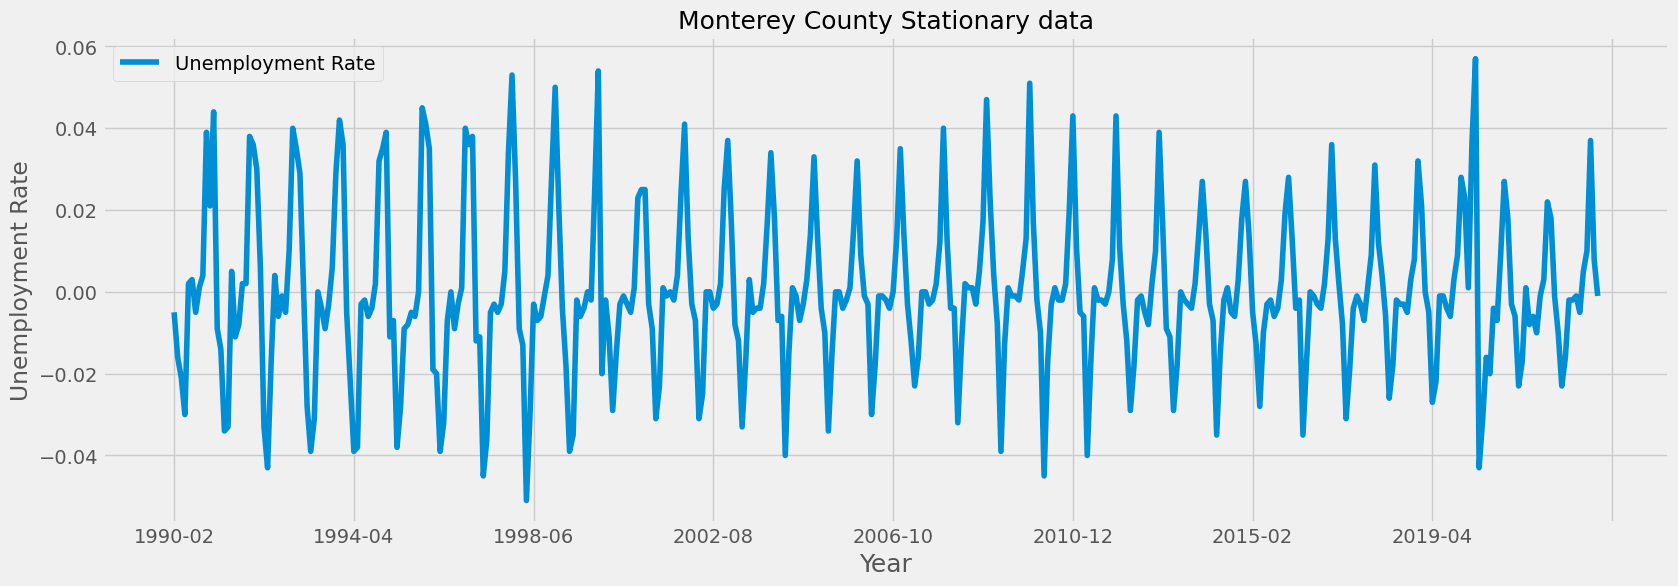

In [76]:
# call our diff() function on Monterey county data to make stationary
Monterey_stationary = diff(Monterey, 'Monterey')
Monterey_stationary

In [77]:
# Recall the steps that we took to create stationary data for Fresno county
## and replicate the steps for Monterey county
county = Monterey.drop(['Area Name',
                          'Labor Force',
                          'Employment',
                          'Unemployment'], axis =1)

county = county.diff(periods =1)

cutoff = round(county.shape[0] * 0.75)

    # plot our new split
train = county[:cutoff]
test = county[cutoff: ]

### Gridsearch Function Monterey County

In [78]:
# # Uncomment whole cell to run

# # runs gridsearch function on training data, takes another 7 minutes

# b_aic, b_order, b_model = gridsearch(train,
#                                     [0,6,12,18],
#                                     [1,2,3,4,5,6],
#                                     [0,6,12,18])
# print(f'The best AIC score is {b_aic}')
# print(f'The best order set is {b_order}')
# # Expected output: The best AIC score is -1919.760684917757
# # Expected output: The best order set is (18, 1, 0)

In [79]:
arma_Monterey = ARIMA(train, order = (18,1,0)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency infor

In [80]:
print(arma_Monterey.summary())

                               SARIMAX Results                                
Dep. Variable:      Unemployment Rate   No. Observations:                  298
Model:                ARIMA(18, 1, 0)   Log Likelihood                 978.771
Date:                Tue, 20 Jun 2023   AIC                          -1919.543
Time:                        22:17:02   BIC                          -1849.362
Sample:                             0   HQIC                         -1891.447
                                - 298                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4586      0.053    -27.753      0.000      -1.562      -1.356
ar.L2         -1.8764      0.085    -21.992      0.000      -2.044      -1.709
ar.L3         -2.1090      0.112    -18.875      0.0

In [81]:
train = train.dropna()

In [82]:
y_hat = arma_Monterey.predict(typ='levels')
y_hat = y_hat[1:]
np.sqrt(mean_squared_error(train, y_hat))

0.0118738401406874

In [83]:
arma_Monterey_test = ARIMA(test, order = (18,1,0)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency infor

In [84]:
print(arma_Monterey_test.aic)

-411.6272198487386


In [85]:
y_hat = arma_Monterey_test.predict(typ='levels')
np.sqrt(mean_squared_error(test, y_hat))

0.024879676983736013

Lower is considered better when it comes to RMSE. Next let's graph this ARIMA model with our forecasted predictions to March 2024.

### Predict Monterey County's incoming unemployment rates

Like the Fresno County section in the notebook above we will be looking to predict 12 months of data, from the end of our dataset March, 2023 up to March, 2024

In [86]:
forecast = arma_Monterey.forecast(112)
forecast

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



298   -0.013588
299   -0.003549
300    0.011201
301   -0.020322
302    0.041702
         ...   
405    0.002074
406   -0.009271
407   -0.003647
408    0.003427
409   -0.012796
Name: predicted_mean, Length: 112, dtype: float64

In [87]:
forecast.index.tolist()

[298,
 299,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 316,
 317,
 318,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359,
 360,
 361,
 362,
 363,
 364,
 365,
 366,
 367,
 368,
 369,
 370,
 371,
 372,
 373,
 374,
 375,
 376,
 377,
 378,
 379,
 380,
 381,
 382,
 383,
 384,
 385,
 386,
 387,
 388,
 389,
 390,
 391,
 392,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408,
 409]

In [88]:
test.index.tolist()

['2014-10',
 '2014-09',
 '2015-04',
 '2015-08',
 '2015-12',
 '2015-02',
 '2015-01',
 '2015-07',
 '2015-06',
 '2015-03',
 '2015-05',
 '2015-11',
 '2015-10',
 '2015-09',
 '2016-04',
 '2016-08',
 '2016-12',
 '2016-02',
 '2016-01',
 '2016-07',
 '2016-06',
 '2016-03',
 '2016-05',
 '2016-11',
 '2016-10',
 '2016-09',
 '2017-04',
 '2017-08',
 '2017-12',
 '2017-02',
 '2017-01',
 '2017-07',
 '2017-06',
 '2017-03',
 '2017-05',
 '2017-11',
 '2017-10',
 '2017-09',
 '2018-04',
 '2018-08',
 '2018-12',
 '2018-02',
 '2018-01',
 '2018-07',
 '2018-06',
 '2018-03',
 '2018-05',
 '2018-11',
 '2018-10',
 '2018-09',
 '2019-04',
 '2019-08',
 '2019-12',
 '2019-02',
 '2019-01',
 '2019-07',
 '2019-06',
 '2019-03',
 '2019-05',
 '2019-11',
 '2019-10',
 '2019-09',
 '2020-04',
 '2020-08',
 '2020-12',
 '2020-02',
 '2020-01',
 '2020-07',
 '2020-06',
 '2020-03',
 '2020-05',
 '2020-11',
 '2020-10',
 '2020-09',
 '2021-04',
 '2021-08',
 '2021-12',
 '2021-02',
 '2021-01',
 '2021-07',
 '2021-06',
 '2021-03',
 '2021-05',
 '20

In [89]:
# Create new variable name to use fully capitalized variable name in one_year_forecast function as title
MONTEREY = pd.DataFrame(forecast)

In [90]:
MONTEREY['Year'] = list
MONTEREY

predicted_mean     Year
298       -0.013588  2014-10
299       -0.003549  2014-09
300        0.011201  2015-04
301       -0.020322  2015-08
302        0.041702  2015-12
..              ...      ...
405        0.002074  2023-11
406       -0.009271  2023-12
407       -0.003647  2024-01
408        0.003427  2024-02
409       -0.012796  2024-03

[112 rows x 2 columns]

In [91]:
MONTEREY = MONTEREY.set_index('Year')

In [92]:
MONTEREY

predicted_mean
Year                   
2014-10       -0.013588
2014-09       -0.003549
2015-04        0.011201
2015-08       -0.020322
2015-12        0.041702
...                 ...
2023-11        0.002074
2023-12       -0.009271
2024-01       -0.003647
2024-02        0.003427
2024-03       -0.012796

[112 rows x 1 columns]

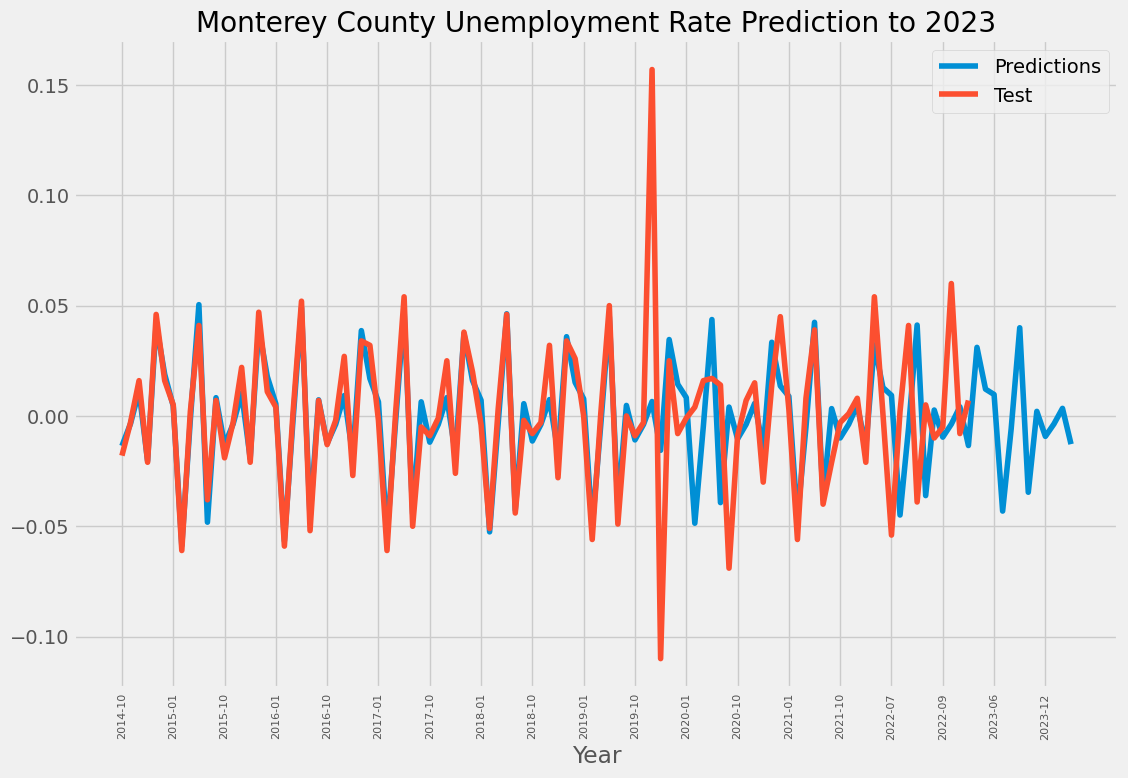

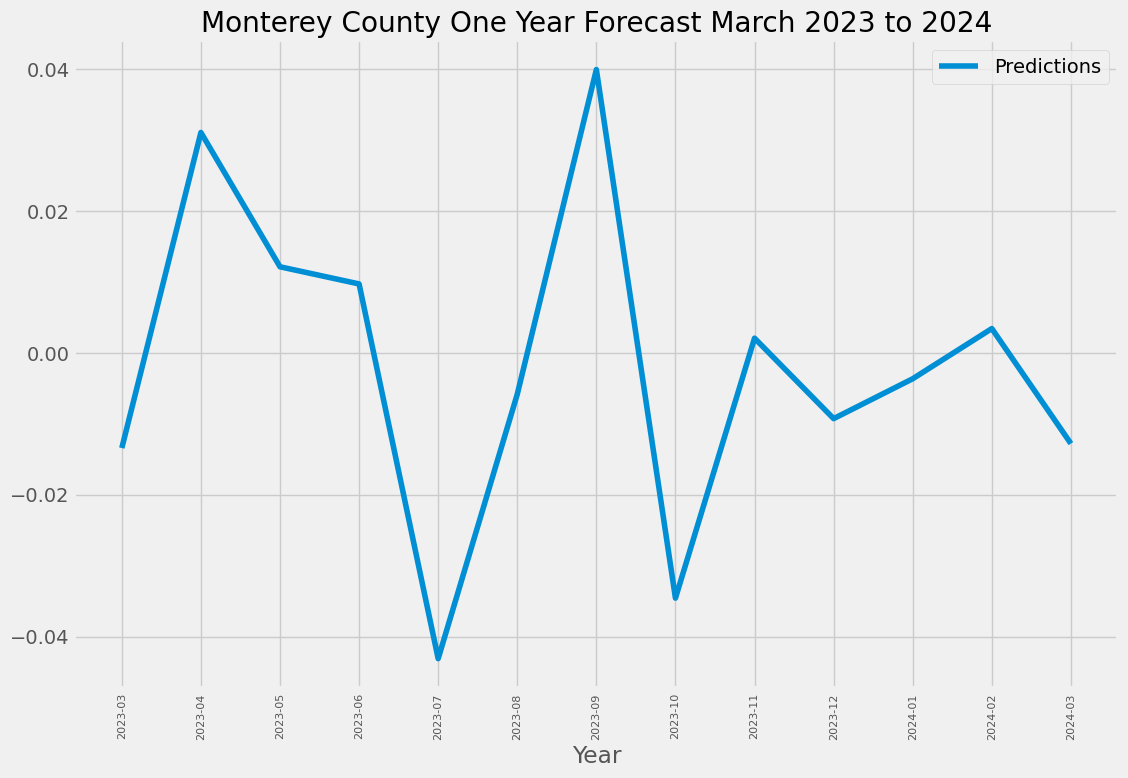

In [93]:
# Recall the one_year_forecast function that will plot test and forecast predictions
## creates a separate plot of the one year forecast predictions
one_year_forecast(MONTEREY, 'Monterey')

We have a score for our best performant ARIMA model as well as the predictive graph.

## FB Prophet: Monterey County

Our Fresno county ARIMA model was very successful and outperformed a base Prophet model. Let's run the same function from above to see if that is still the case.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp882o6j5p/csga14t6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp882o6j5p/87903_em.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78450', 'data', 'file=/tmp/tmp882o6j5p/csga14t6.json', 'init=/tmp/tmp882o6j5p/87903_em.json', 'output', 'file=/tmp/tmp882o6j5p/prophet_model9r3u5bhj/prophet_model-20230620221710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:17:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:17:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Squared Error between actual and  predicted values:  0.08055487792532276
Mean Value of Test Dataset: 0.07737999999999999


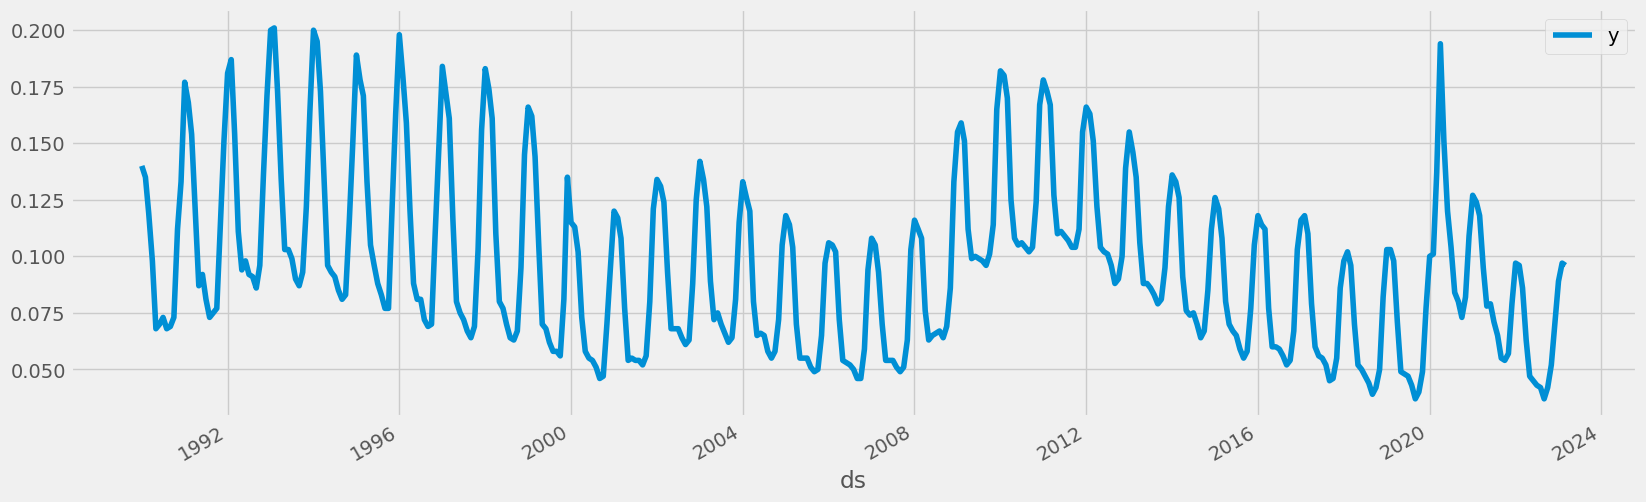

In [94]:
prophet(Monterey)

Unfortunately Prophet does not provide us with a more powerful model for Monterey county.

## Effect on Unemployment Rate: Monterey County

According to our data on __[Monterey County](https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/County_Profiles/California/cp06053.pdf)__'s ag worker data, there are: <br>

- 1,356 male workers
- 588 female workers
- 175 of which are under the age of 35
- 1174 between the ages of 35-64
- 595 above the age of 65 <br>
- total 1,944 workers

Again, with consideration that not all of the workforce will take this educational opportunity, we will use the same parameters as on Fresno county's agriculture workforce. <br>

So again, with 1,944 total ag workers, with an anticipated 25% taking advantage of an educational opportunity, and a 50% anticipated graduation rate we would have: <br>

- 243 new skilled trade workers in 2019

In [95]:
# effect function from above will perform the same analysis that was done on
## Fresno county data in regards to number of Employed vs Unemployed post
### educational program and the change in rate of unemployment
effect(Monterey, 243)

Area Name  Labor Force  Employment  Unemployment  \
month_year                                                           
2019-01     Monterey County       210400      188843         21457   
2019-02     Monterey County       214300      192343         21957   
2019-03     Monterey County       215400      194443         20857   
2019-04     Monterey County       223300      207743         15557   
2019-05     Monterey County       228300      217443         10857   
2019-06     Monterey County       230200      219443         10757   
2019-07     Monterey County       230600      220043         10557   
2019-08     Monterey County       228200      218643          9457   
2019-09     Monterey County       227700      219643          8057   
2019-10     Monterey County       224100      215343          8757   
2019-11     Monterey County       217900      207343         10457   
2019-12     Monterey County       208800      192943         15857   

            Unemployment Rate  Unemployment Rate Change  
month_year                                               
2019-01              0.101982                  0.001018  
2019-02              0.102459                  0.000541  
2019-03              0.096829                  0.001171  
2019-04              0.069669                  0.001331  
2019-05              0.047556                  0.001444  
2019-06              0.046729                  0.001271  
2019-07              0.045781                  0.001219  
2019-08              0.041442                  0.001558  
2019-09              0.035384                  0.001616  
2019-10              0.039076                  0.000924  
2019-11              0.047990                  0.001010  
2019-12              0.075943                  0.001057

According to a recent article from _Monterey County Weekly_ in their article __[Housing and labor shortages are holding back the Monterey Bay region’s economy](https://www.montereycountyweekly.com/blogs/news_blog/housing-and-labor-shortages-are-holding-back-the-monterey-bay-region-s-economy/article_2b1542f2-fb81-11ed-8042-47ed37dd3160.html)__ published May 25, 2023, the largest growing sector currently is manufacturing but according to Christopher Thornberg of Beacon Economics, at the MBEP’s (Monterey Bay Economic Partnership) 2023 Regional Economic Outlook virtual event, the current housing crisis in Monterey County is not based in unaffordable housing, it is due to lack of housing. <br>

Rey Mashayekhi, the author of the article outlines Thornberg's sentiments, that
<br>
"The “real worries,” he noted, should be around housing shortages impacting workers in places like California, which are contributing to the “enormous issue” of labor shortages that are hurting businesses. That’s led to California’s declining population and lower net migration pattern in recent years, which have affected the Monterey Bay region’s economy."<br>

It is suggested that potential candidates take advantage of drywall, plumbing, hvac, or electrical schooling in the Monterey County area.<br>

<img src = 'https://raw.githubusercontent.com/joshstruggles/Local-Area-Unemployment-Statistics-California/main/pics/MCH-L-HOUSING-1201.webp'>
<p style="text-align: center;">Housing construction in Monterey County from the Monterey Herald</p>

# __[Kern County](https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/County_Profiles/California/cp06029.pdf)__ Stationary Data

According to __[Kern County's 2021 Crop Report](http://www.kernag.com/dept/news/2022/2021_Kern_County_Crop_Report.pdf)__, the top crop was grapes, an estimated value of \$1,871,328,000

Test Statistic                  -4.489214
p-value                          0.000206
#Lags Used                      11.000000
Number of Observations Used    385.000000
Critical Value (1%)             -3.447450
Critical Value (5%)             -2.869077
Critical Value (10%)            -2.570785
dtype: float64

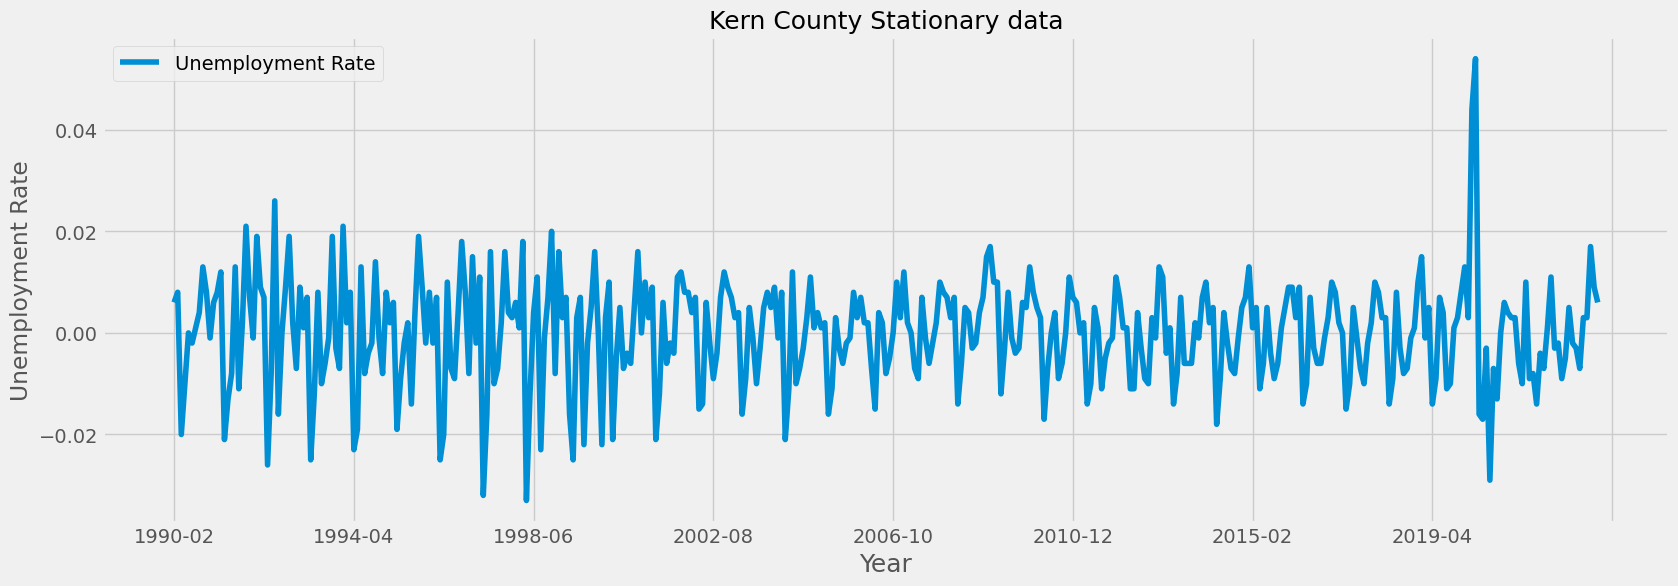

In [96]:
# call our diff() function on Kern county data
Kern_stationary = diff(Kern, 'Kern')
Kern_stationary

In [97]:
# Drop unnecessary columns from Kern county and create stationary data
county = Kern.drop(['Area Name',
                          'Labor Force',
                          'Employment',
                          'Unemployment'], axis =1)

county = county.diff(periods =1)

cutoff = round(county.shape[0] * 0.75)

# plot our new split
train = county[:cutoff]
test = county[cutoff: ]

### Gridsearch Function Kern County

In [98]:
# # Uncomment whole cell to run

# # runs gridsearch function on training data, takes another 7 minutes

# b_aic, b_order, b_model = gridsearch(train,
#                                     [0,6,12,18],
#                                     [1,2,3,4,5,6],
#                                     [0,6,12,18])
# print(f'The best AIC score is {b_aic}')
# print(f'The best order set is {b_order}')
# # Expected output: The best AIC score is -1926.5166750777462
# # Expected output: The best order set is (12, 1, 18)

In [99]:
# ARIMA model is fit with highest scoring AIC parameters based on
## gridsearch function above
arma_Kern = ARIMA(train, order = (12,1,18)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency infor

In [100]:
print(arma_Kern.summary())

                               SARIMAX Results                                
Dep. Variable:      Unemployment Rate   No. Observations:                  298
Model:               ARIMA(12, 1, 18)   Log Likelihood                 994.133
Date:                Tue, 20 Jun 2023   AIC                          -1926.267
Time:                        22:17:30   BIC                          -1811.761
Sample:                             0   HQIC                         -1880.426
                                - 298                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7750      0.137    -12.928      0.000      -2.044      -1.506
ar.L2         -1.8521      0.163    -11.352      0.000      -2.172      -1.532
ar.L3         -1.7396      0.193     -9.008      0.0

In [101]:
train = train.dropna()

In [102]:
y_hat = arma_Kern.predict(typ = 'levels')
y_hat = y_hat[1:]
np.sqrt(mean_squared_error(train, y_hat))

0.008568936109356686

In [103]:
arma_Kern_test = ARIMA(test, order = (12,1,18)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency infor

In [104]:
print(arma_Kern_test.aic)

-458.3111303700365


In [105]:
y_hat = arma_Kern_test.predict(typ='levels')
np.sqrt(mean_squared_error(test, y_hat))

0.016891366338515054

### Predict Kern County's incoming unemployment rates

Like the previous two counties we will be looking to predict 12 months into the future.

In [106]:
# create lists from arma_Kern and attach indexes to forcast and
## test data
forecast = arma_Kern.forecast(112)
forecast.index.tolist()
test.index.tolist()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



['2014-10',
 '2014-09',
 '2015-04',
 '2015-08',
 '2015-12',
 '2015-02',
 '2015-01',
 '2015-07',
 '2015-06',
 '2015-03',
 '2015-05',
 '2015-11',
 '2015-10',
 '2015-09',
 '2016-04',
 '2016-08',
 '2016-12',
 '2016-02',
 '2016-01',
 '2016-07',
 '2016-06',
 '2016-03',
 '2016-05',
 '2016-11',
 '2016-10',
 '2016-09',
 '2017-04',
 '2017-08',
 '2017-12',
 '2017-02',
 '2017-01',
 '2017-07',
 '2017-06',
 '2017-03',
 '2017-05',
 '2017-11',
 '2017-10',
 '2017-09',
 '2018-04',
 '2018-08',
 '2018-12',
 '2018-02',
 '2018-01',
 '2018-07',
 '2018-06',
 '2018-03',
 '2018-05',
 '2018-11',
 '2018-10',
 '2018-09',
 '2019-04',
 '2019-08',
 '2019-12',
 '2019-02',
 '2019-01',
 '2019-07',
 '2019-06',
 '2019-03',
 '2019-05',
 '2019-11',
 '2019-10',
 '2019-09',
 '2020-04',
 '2020-08',
 '2020-12',
 '2020-02',
 '2020-01',
 '2020-07',
 '2020-06',
 '2020-03',
 '2020-05',
 '2020-11',
 '2020-10',
 '2020-09',
 '2021-04',
 '2021-08',
 '2021-12',
 '2021-02',
 '2021-01',
 '2021-07',
 '2021-06',
 '2021-03',
 '2021-05',
 '20

In [107]:
# KERN will serve as our data for plot of unemployment rate 12
## months into the future
KERN = pd.DataFrame(forecast)
KERN['Year'] = list
KERN = KERN.set_index('Year')

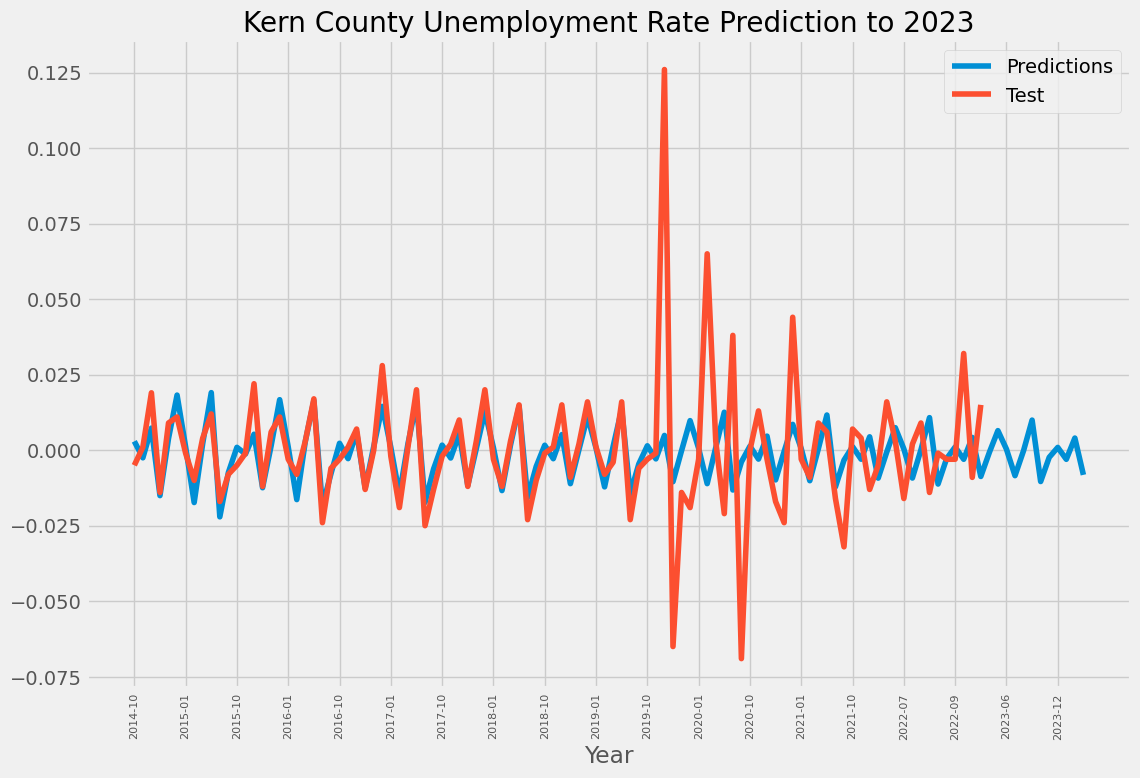

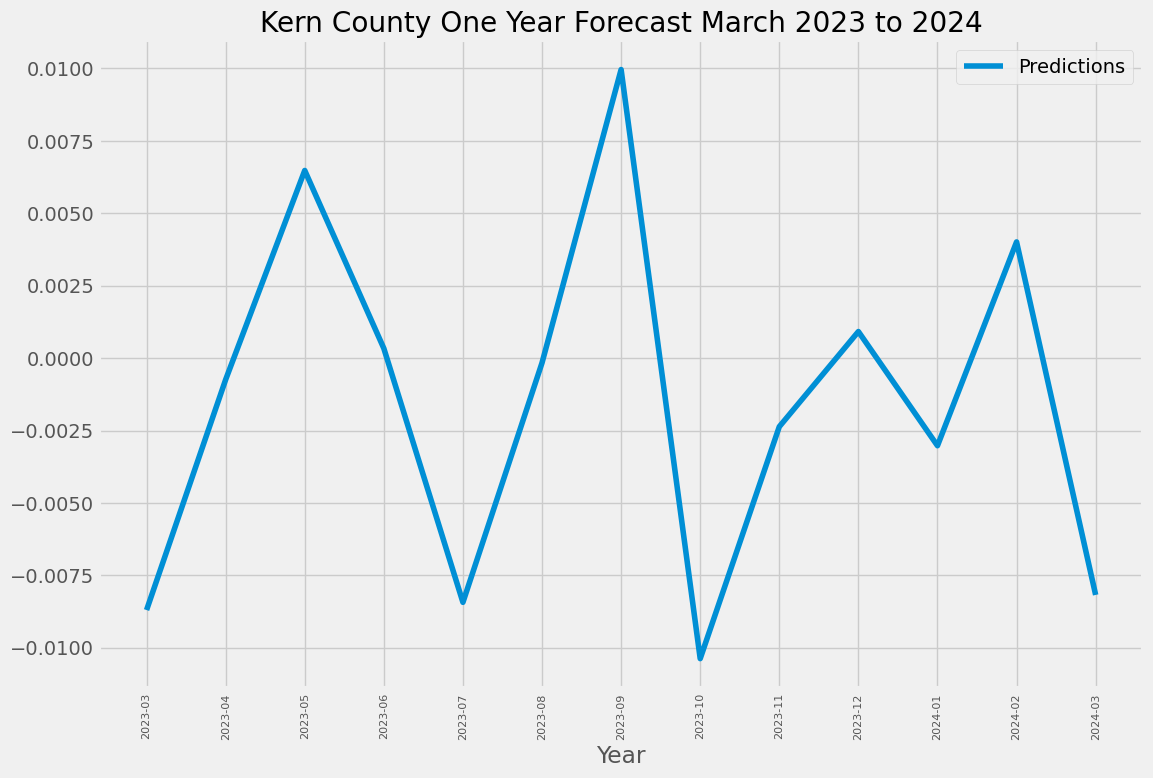

In [108]:
# calling on one_year_forecast will give us the two plots of
## test data and predictions and a graph of just the 12 month
### prediction
one_year_forecast(KERN, 'Kern')

### FB Prophet: Kern County

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp882o6j5p/d5o4i8bh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp882o6j5p/ivda50yi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17545', 'data', 'file=/tmp/tmp882o6j5p/d5o4i8bh.json', 'init=/tmp/tmp882o6j5p/ivda50yi.json', 'output', 'file=/tmp/tmp882o6j5p/prophet_modellg5eedum/prophet_model-20230620221744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:17:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:17:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Squared Error between actual and  predicted values:  0.0690673071912461
Mean Value of Test Dataset: 0.09454999999999998


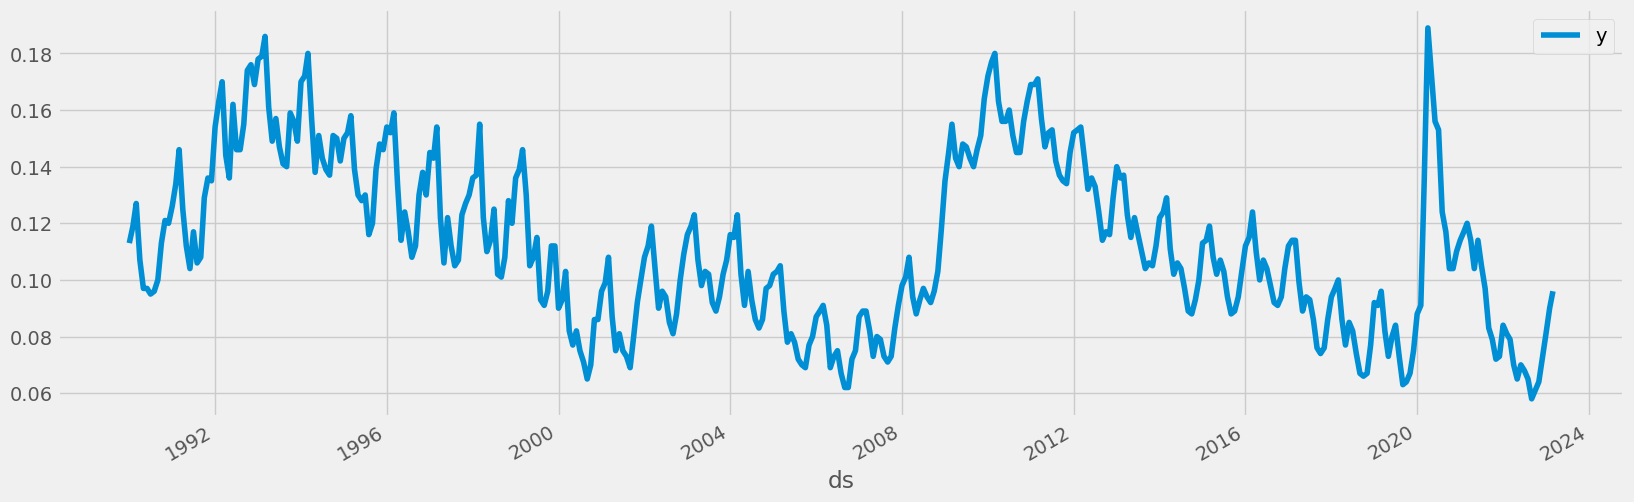

In [109]:
# call prophet model which will return RMSE score of Prophet
## model
prophet(Kern)

### Effect on Unemployment Rate: Kern County

__[Kern County](https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/County_Profiles/California/cp06029.pdf)__'s ag worker data shows that in 2017 there were: <br>

- 2,162 male workers
- 997 female workers
- 230 under the age of 35
- 1,820 between the ages of 35-64
- 1,109 over the age of 65
- in total there are 3,159 workers in Kern County <br>

We anticipate that somewhere around 394 workers would become skilled trade workers in 2019.


In [110]:
# effect function will give us potential rate of unemployment change
## if our educational program could be implemented and results take 2
### years to take effect
effect(Kern, 394)

Area Name  Labor Force  Employment  Unemployment  \
month_year                                                       
2019-01     Kern County       391000      355494         35606   
2019-02     Kern County       390200      354894         35306   
2019-03     Kern County       382600      346494         36206   
2019-04     Kern County       383600      352594         31006   
2019-05     Kern County       385600      357794         27806   
2019-06     Kern County       389100      358494         30606   
2019-07     Kern County       382600      350794         31806   
2019-08     Kern County       394900      366494         28506   
2019-09     Kern County       394900      370394         24506   
2019-10     Kern County       394700      369694         24906   
2019-11     Kern County       389000      363294         25706   
2019-12     Kern County       387400      358794         28506   

            Unemployment Rate  Unemployment Rate Change  
month_year                                               
2019-01              0.091064                  0.000936  
2019-02              0.090482                  0.000518  
2019-03              0.094631                  0.001369  
2019-04              0.080829                  0.001171  
2019-05              0.072111                  0.000889  
2019-06              0.078658                  0.001342  
2019-07              0.083131                  0.000869  
2019-08              0.072185                  0.000815  
2019-09              0.062056                  0.000944  
2019-10              0.063101                  0.000899  
2019-11              0.066082                  0.000918  
2019-12              0.073583                  0.001417

According to the __[Kern County Economic Forecast](https://dot.ca.gov/-/media/dot-media/programs/transportation-planning/documents/data-analytics-services/transportation-economics/socioeconomic-forecasts/2021/2021-pdf/kern-profile-a11y.pdf)__, published in 2021, "Construction saw a relatively large decline" but was anticipated to have "a full recovery ... expected in 2023 or 2024."

# __[Tulare County](https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/County_Profiles/California/cp06107.pdf)__ Stationary Data

According to __[Tulare County's 2020 Crop and Livestock Report](https://agcomm.co.tulare.ca.us/pest-exclusion-standardization/crop-reports1/crop-reports-2011-2020/2020-crop-and-livestock-report/)__, sweet corn and brocolli were the highest earning vegetables and pistachios and tangerines were the highest earners overall.

Test Statistic                  -5.602612
p-value                          0.000001
#Lags Used                      14.000000
Number of Observations Used    382.000000
Critical Value (1%)             -3.447585
Critical Value (5%)             -2.869136
Critical Value (10%)            -2.570816
dtype: float64

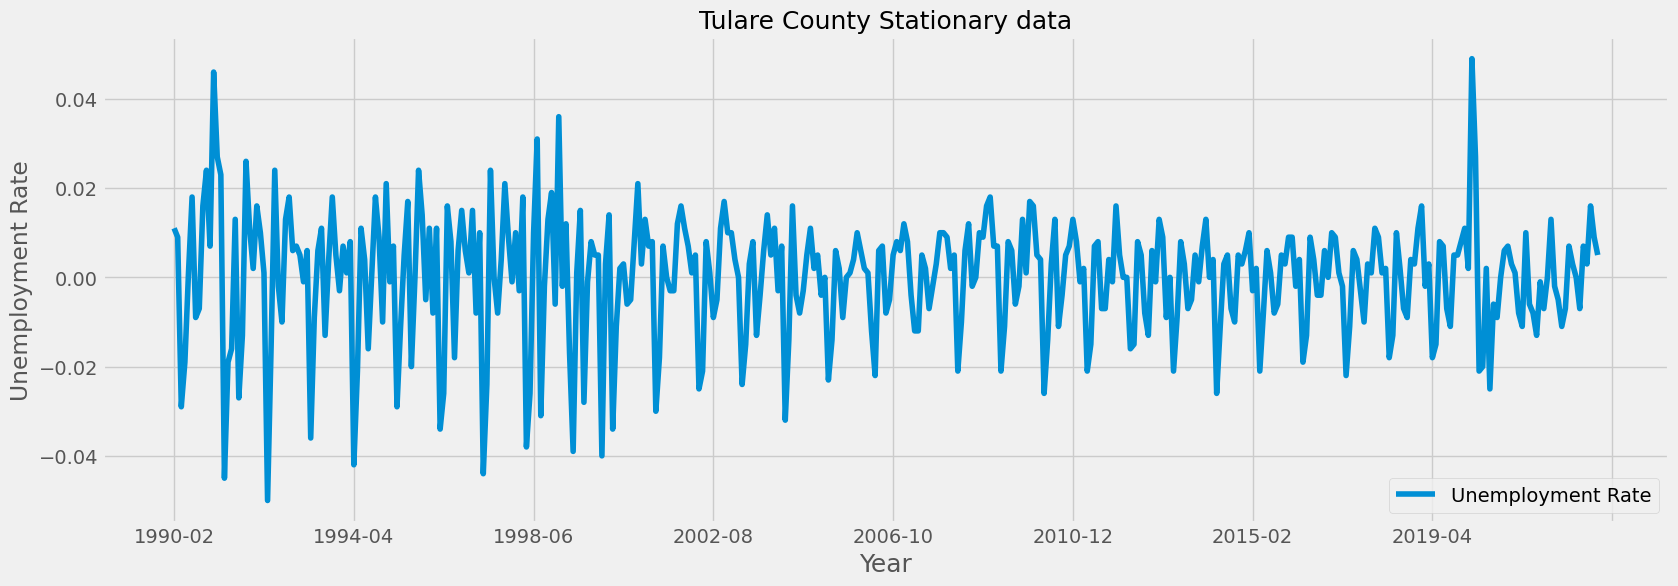

In [111]:
# diff() function on Tulare will give plot of stationary data as well as
## p-values and certainty values to ensure data is stationary at a one
### period diff
Tulare_stationary = diff(Tulare, 'Tulare')
Tulare_stationary

In [112]:
# drop columns that are not 'Unemployment Rate' and create stationary
## data and train/test split
county = Tulare.drop(['Area Name',
                          'Labor Force',
                          'Employment',
                          'Unemployment'], axis =1)

county = county.diff(periods =1)

cutoff = round(county.shape[0] * 0.75)

    # plot our new split
train = county[:cutoff]
test = county[cutoff: ]

### Gridsearch Function Tulare County

We will run our gridsearch function again on a baseline ARIMA model to get our best (p,d,q) parameters, judged by AIC score.

In [113]:
# # Uncomment whole cell to run

# # runs gridsearch function on training data, takes another 7 minutes

# b_aic, b_order, b_model = gridsearch(train,
#                                     [0,6,12,18],
#                                     [1,2,3,4,5,6],
#                                     [0,6,12,18])
# print(f'The best AIC score is {b_aic}')
# print(f'The best order set is {b_order}')
# # Expected output: The best AIC score is -1708.1863069146839
# # Expected output: The best order set is (18, 1, 18)

In [114]:
arma_Tulare = ARIMA(train, order = (18,1,18)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency infor

In [115]:
print(arma_Tulare.summary())

                               SARIMAX Results                                
Dep. Variable:      Unemployment Rate   No. Observations:                  298
Model:               ARIMA(18, 1, 18)   Log Likelihood                 891.487
Date:                Tue, 20 Jun 2023   AIC                          -1708.973
Time:                        22:18:03   BIC                          -1572.305
Sample:                             0   HQIC                         -1654.260
                                - 298                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4499      0.952     -1.522      0.128      -3.317       0.417
ar.L2         -2.1057      1.707     -1.234      0.217      -5.451       1.239
ar.L3         -2.6204      2.600     -1.008      0.3

In [116]:
train = train.dropna()

In [117]:
y_hat = arma_Tulare.predict(typ='levels')
y_hat = y_hat[1:]
np.sqrt(mean_squared_error(train, y_hat))

0.012891999427202162

In [118]:
arma_Tulare_test = ARIMA(test, order= (18,1,18)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency infor

In [119]:
print(arma_Tulare_test.aic)

-475.4931215392435


In [120]:
# code gives us our RMSE score on testing data
y_hat = arma_Tulare_test.predict(typ='levels')
np.sqrt(mean_squared_error(test, y_hat))

0.014591564386931839

### Predict Tulare County's incoming unemployment rates

We will again be looking at the 12 months post training data to give us a one year prediction of unemployment rate

In [121]:
# forecast will give us a 12 month prediction on top of predicted data on
## top of testing data
forecast = arma_Tulare.forecast(112)
forecast.index.tolist()
test.index.tolist()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



['2014-10',
 '2014-09',
 '2015-04',
 '2015-08',
 '2015-12',
 '2015-02',
 '2015-01',
 '2015-07',
 '2015-06',
 '2015-03',
 '2015-05',
 '2015-11',
 '2015-10',
 '2015-09',
 '2016-04',
 '2016-08',
 '2016-12',
 '2016-02',
 '2016-01',
 '2016-07',
 '2016-06',
 '2016-03',
 '2016-05',
 '2016-11',
 '2016-10',
 '2016-09',
 '2017-04',
 '2017-08',
 '2017-12',
 '2017-02',
 '2017-01',
 '2017-07',
 '2017-06',
 '2017-03',
 '2017-05',
 '2017-11',
 '2017-10',
 '2017-09',
 '2018-04',
 '2018-08',
 '2018-12',
 '2018-02',
 '2018-01',
 '2018-07',
 '2018-06',
 '2018-03',
 '2018-05',
 '2018-11',
 '2018-10',
 '2018-09',
 '2019-04',
 '2019-08',
 '2019-12',
 '2019-02',
 '2019-01',
 '2019-07',
 '2019-06',
 '2019-03',
 '2019-05',
 '2019-11',
 '2019-10',
 '2019-09',
 '2020-04',
 '2020-08',
 '2020-12',
 '2020-02',
 '2020-01',
 '2020-07',
 '2020-06',
 '2020-03',
 '2020-05',
 '2020-11',
 '2020-10',
 '2020-09',
 '2021-04',
 '2021-08',
 '2021-12',
 '2021-02',
 '2021-01',
 '2021-07',
 '2021-06',
 '2021-03',
 '2021-05',
 '20

In [122]:
# set new variable to all caps TULARE
TULARE = pd.DataFrame(forecast)

In [123]:
TULARE['Year'] = list
TULARE = TULARE.set_index('Year')

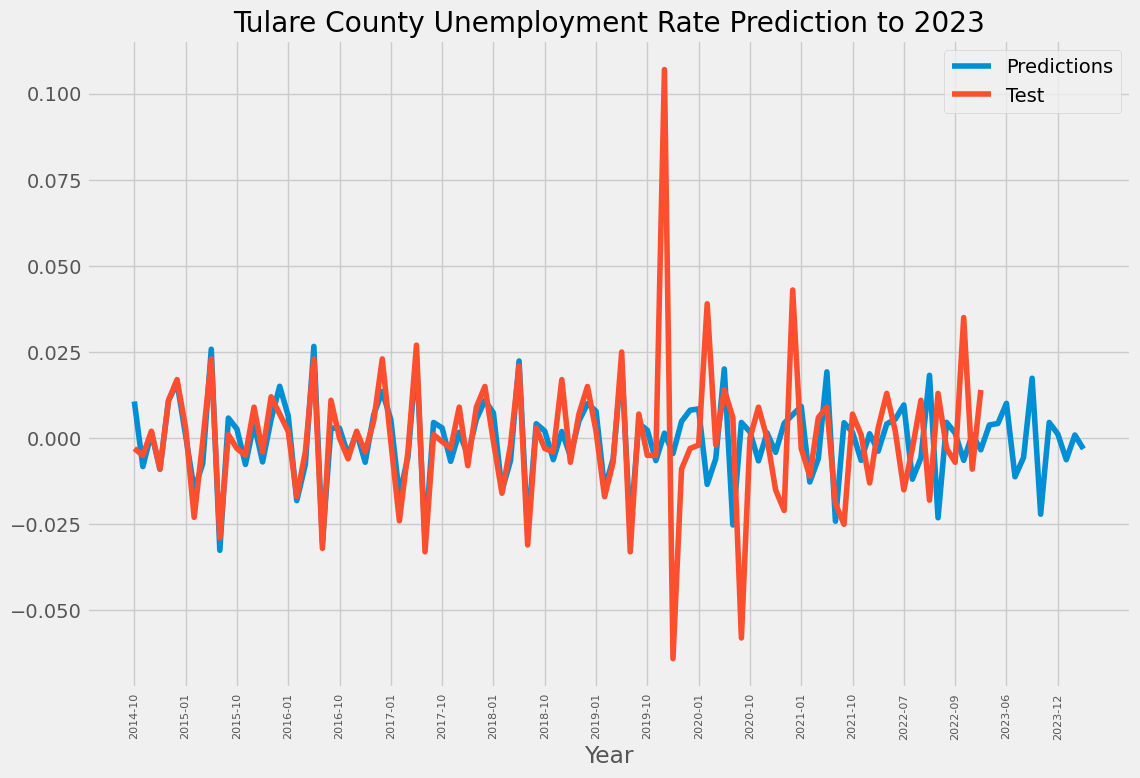

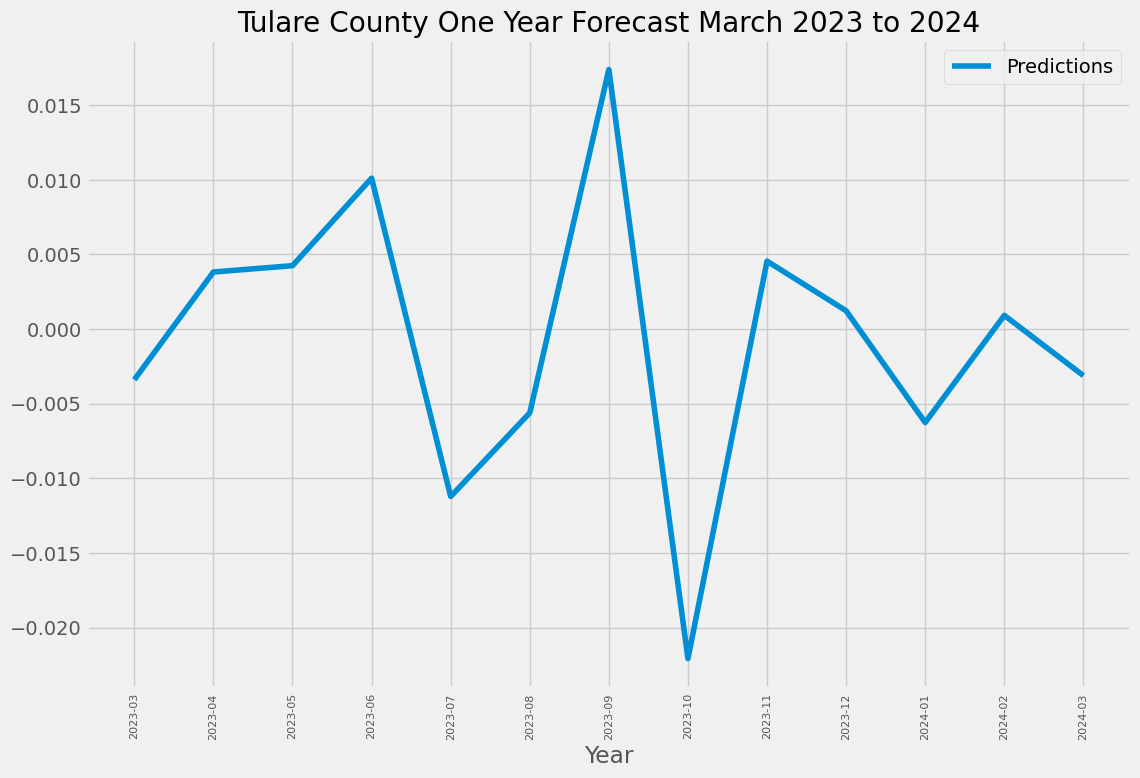

In [124]:
# one_year_forecast function will give us a plot of testing
## data and predictions and a second plot of just the 12 month
### prediction for Tulare county
one_year_forecast(TULARE, 'Tulare')

### FB Prophet: Tulare County

We will fit our data onto another baseline Prophet model to see if it can outperform our ARIMA model.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp882o6j5p/dorxmgd3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp882o6j5p/9ynltcw7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77611', 'data', 'file=/tmp/tmp882o6j5p/dorxmgd3.json', 'init=/tmp/tmp882o6j5p/9ynltcw7.json', 'output', 'file=/tmp/tmp882o6j5p/prophet_modelel1vi7w3/prophet_model-20230620221813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:18:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:18:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Squared Error between actual and  predicted values:  0.09678986225210176
Mean Value of Test Dataset: 0.10684999999999999


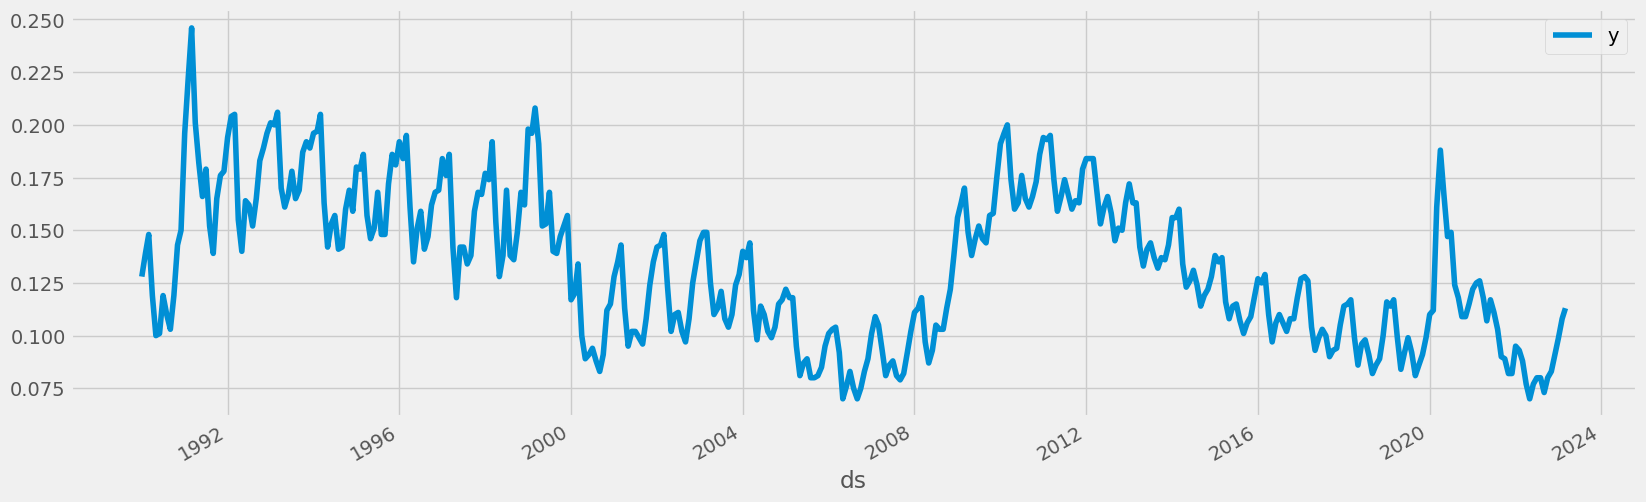

In [125]:
# prophet function will return RMSE score as well as plotted data for
## prophet model
prophet(Tulare)

Our ARIMA looks to have better performance than the baseline Prophet model. We can move onto the effect on unemployment rate.

## Effect on Unemployment Rate: Tulare County

__[Tulare County](https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/County_Profiles/California/cp06107.pdf)__ has a total of 7,163 ag workers, with an anticipated 895 that would apply and graduate from an educational program.

In [126]:
effect(Tulare, 895)

Area Name  Labor Force  Employment  Unemployment  \
month_year                                                         
2019-01     Tulare County       203900      180995         22805   
2019-02     Tulare County       204100      181595         22405   
2019-03     Tulare County       202300      179495         22805   
2019-04     Tulare County       203400      184195         19205   
2019-05     Tulare County       205000      188595         16405   
2019-06     Tulare County       204200      186295         17905   
2019-07     Tulare County       200600      181695         19005   
2019-08     Tulare County       203500      185595         17905   
2019-09     Tulare County       202400      186895         15505   
2019-10     Tulare County       199700      183495         16205   
2019-11     Tulare County       200600      183295         17305   
2019-12     Tulare County       199800      180895         18905   

            Unemployment Rate  Unemployment Rate Change  
month_year                                               
2019-01              0.111844                  0.004156  
2019-02              0.109775                  0.004225  
2019-03              0.112729                  0.004271  
2019-04              0.094420                  0.004580  
2019-05              0.080024                  0.003976  
2019-06              0.087684                  0.004316  
2019-07              0.094741                  0.004259  
2019-08              0.087985                  0.004015  
2019-09              0.076606                  0.004394  
2019-10              0.081147                  0.004853  
2019-11              0.086266                  0.004734  
2019-12              0.094620                  0.004380

Reggie Ellis wrote a piece on __[Chris Thornberg's presentation to Tulare County officials in 2022](https://thesungazette.com/article/news/2022/02/22/economist-chris-thornberg-tells-tulare-county-to-focus-on-workers-workers-workers/)__, Ellis outlines Thornberg's presentation on the labor shortage as a shortage of amenities, affordable homes for families, and lack of workforce. This would seem paradoxical, as Thornburg explains, "There is not enough housing for people to live in this state," and that "if you don't build them, people aren't going to come." <br>

There appears to be a clear push for construction work to be done in the Central Valley.

<img src='https://github.com/joshstruggles/Local-Area-Unemployment-Statistics-California/blob/main/pics/2-18_re-summit_chris-thornberg-labor-market-1.jpg?raw=1'>
<center>Chris Thornberg of Beacon Economics giving a presentation to Tulare County officials in 2022 on the labor shortage</center>

# __[San Joaquin County](https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/County_Profiles/California/cp06077.pdf)__ Stationary Data

According to the __[San Joaquin County 2021 Crop Report](https://www.sjgov.org/docs/default-source/agricultural-commissioner-documents/croprpt-archive/2020to2029/sjc_cr2021.pdf?sfvrsn=767f71c8_2)__, the leading crops are almonds (\$453,764,000), milk (\$445,621,000), and grapes (\$428,359,000)

Test Statistic                  -4.594993
p-value                          0.000132
#Lags Used                      11.000000
Number of Observations Used    385.000000
Critical Value (1%)             -3.447450
Critical Value (5%)             -2.869077
Critical Value (10%)            -2.570785
dtype: float64

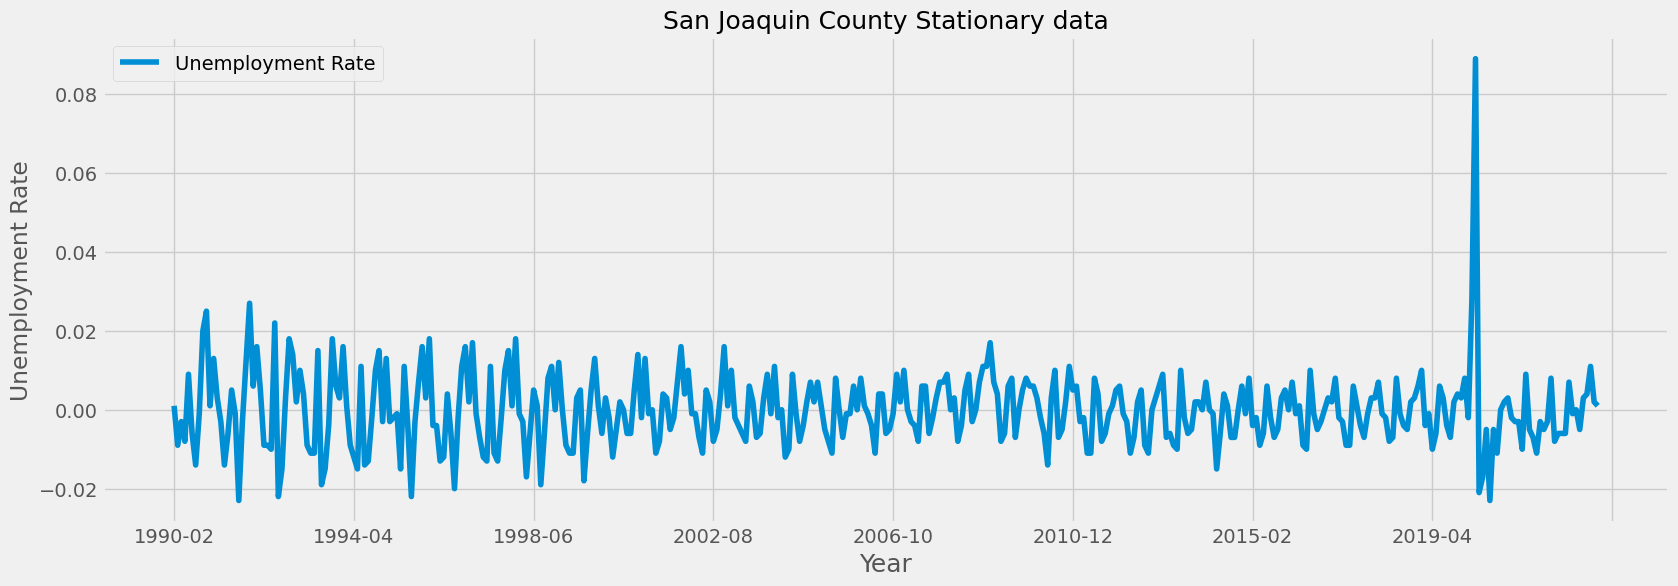

In [127]:
# diff function will return plotted data points on San Joaquin's
## stationary test data and forecasted plot points
San_Joaquin_stationary = diff(San_Joaquin, 'San Joaquin')
San_Joaquin_stationary

In [128]:
# drop unnecessary columns for our analysis and create stationary
## data and train/test split
county = San_Joaquin.drop(['Area Name',
                          'Labor Force',
                          'Employment',
                          'Unemployment'], axis =1)

county = county.diff(periods =1)

cutoff = round(county.shape[0] * 0.75)

    # plot our new split
train = county[:cutoff]
test = county[cutoff: ]

In [129]:
# # Uncomment whole cell to run

# # runs gridsearch function on training data, takes another 7 minutes

# b_aic, b_order, b_model = gridsearch(train,
#                                     [0,6,12,18],
#                                     [1,2,3,4,5,6],
#                                     [0,6,12,18])
# print(f'The best AIC score is {b_aic}')
# print(f'The best order set is {b_order}')
# # Expected output: The best AIC score is -2030.3340755639715
# # Expected output: The best order set is (18, 1, 0)

In [130]:
arma_SJ = ARIMA(train, order = (18,1,0)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency infor

In [131]:
print(arma_SJ.summary())

                               SARIMAX Results                                
Dep. Variable:      Unemployment Rate   No. Observations:                  298
Model:                ARIMA(18, 1, 0)   Log Likelihood                1034.150
Date:                Tue, 20 Jun 2023   AIC                          -2030.300
Time:                        22:18:18   BIC                          -1960.119
Sample:                             0   HQIC                         -2002.204
                                - 298                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3600      0.053    -25.784      0.000      -1.463      -1.257
ar.L2         -1.7272      0.077    -22.418      0.000      -1.878      -1.576
ar.L3         -1.7932      0.111    -16.109      0.0

In [132]:
train = train.dropna()

In [133]:
y_hat = arma_SJ.predict(typ='levels')
y_hat = y_hat[1:]
np.sqrt(mean_squared_error(train, y_hat))

0.008636962511004175

In [134]:
arma_SJ_test = ARIMA(test, order = (18,1,0)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency infor

In [135]:
print(arma_SJ_test.aic)

-472.0713002902999


In [136]:
# RMSE score of our best performant ARIMA model on
## San Joaquin stationary data
y_hat = arma_SJ_test.predict(typ='levels')
np.sqrt(mean_squared_error(test, y_hat))

0.01789843676172922

### Predict San Joaquin County's incoming unemployment rates

In [137]:
# create forecasted data 12 months after most recent data
## available to us
forecast = arma_SJ.forecast(112)
forecast.index.tolist()
test.index.tolist()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



['2014-10',
 '2014-09',
 '2015-04',
 '2015-08',
 '2015-12',
 '2015-02',
 '2015-01',
 '2015-07',
 '2015-06',
 '2015-03',
 '2015-05',
 '2015-11',
 '2015-10',
 '2015-09',
 '2016-04',
 '2016-08',
 '2016-12',
 '2016-02',
 '2016-01',
 '2016-07',
 '2016-06',
 '2016-03',
 '2016-05',
 '2016-11',
 '2016-10',
 '2016-09',
 '2017-04',
 '2017-08',
 '2017-12',
 '2017-02',
 '2017-01',
 '2017-07',
 '2017-06',
 '2017-03',
 '2017-05',
 '2017-11',
 '2017-10',
 '2017-09',
 '2018-04',
 '2018-08',
 '2018-12',
 '2018-02',
 '2018-01',
 '2018-07',
 '2018-06',
 '2018-03',
 '2018-05',
 '2018-11',
 '2018-10',
 '2018-09',
 '2019-04',
 '2019-08',
 '2019-12',
 '2019-02',
 '2019-01',
 '2019-07',
 '2019-06',
 '2019-03',
 '2019-05',
 '2019-11',
 '2019-10',
 '2019-09',
 '2020-04',
 '2020-08',
 '2020-12',
 '2020-02',
 '2020-01',
 '2020-07',
 '2020-06',
 '2020-03',
 '2020-05',
 '2020-11',
 '2020-10',
 '2020-09',
 '2021-04',
 '2021-08',
 '2021-12',
 '2021-02',
 '2021-01',
 '2021-07',
 '2021-06',
 '2021-03',
 '2021-05',
 '20

In [138]:
SAN_JOAQUIN = pd.DataFrame(forecast)

In [139]:
SAN_JOAQUIN['Year'] = list
SAN_JOAQUIN = SAN_JOAQUIN.set_index('Year')

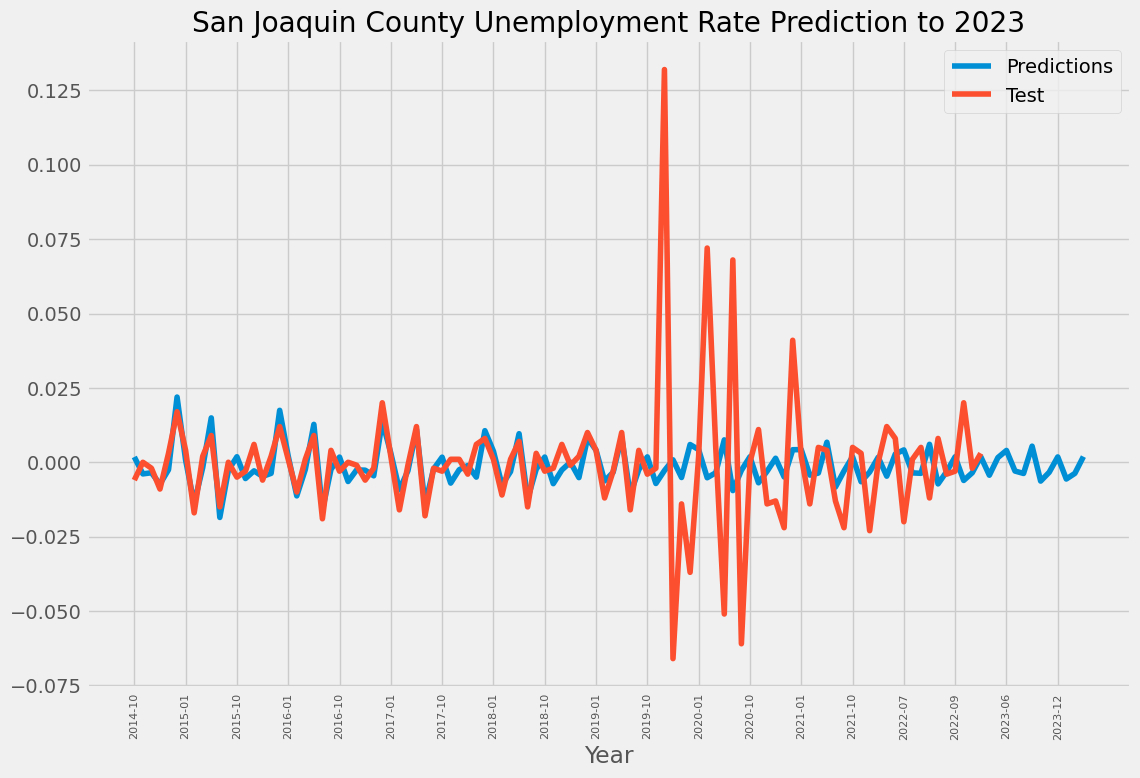

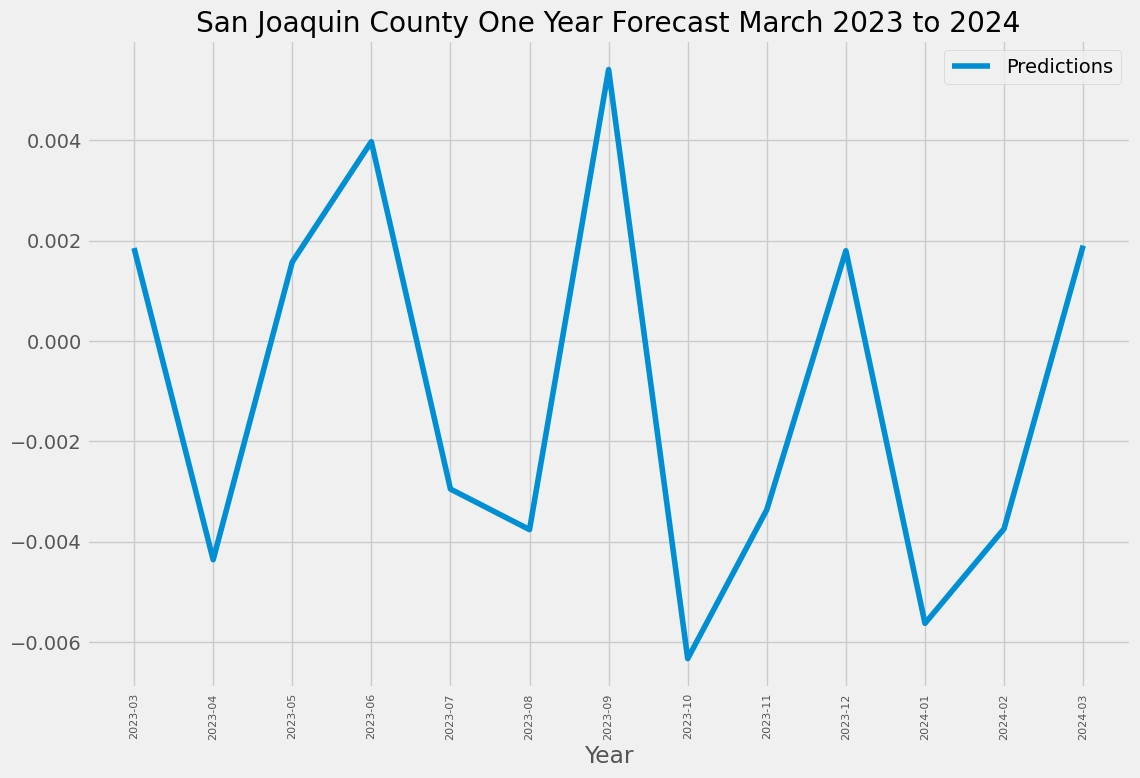

In [140]:
# one_year_forecast function will return plotted data of
## our one year predictions
one_year_forecast(SAN_JOAQUIN,'San Joaquin')

### FB Prophet: San Joaquin County

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp882o6j5p/0bolrg4a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp882o6j5p/rremlnoc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53931', 'data', 'file=/tmp/tmp882o6j5p/0bolrg4a.json', 'init=/tmp/tmp882o6j5p/rremlnoc.json', 'output', 'file=/tmp/tmp882o6j5p/prophet_modelwz5dat_e/prophet_model-20230620221824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:18:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:18:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Squared Error between actual and  predicted values:  0.10283530672652813
Mean Value of Test Dataset: 0.07712


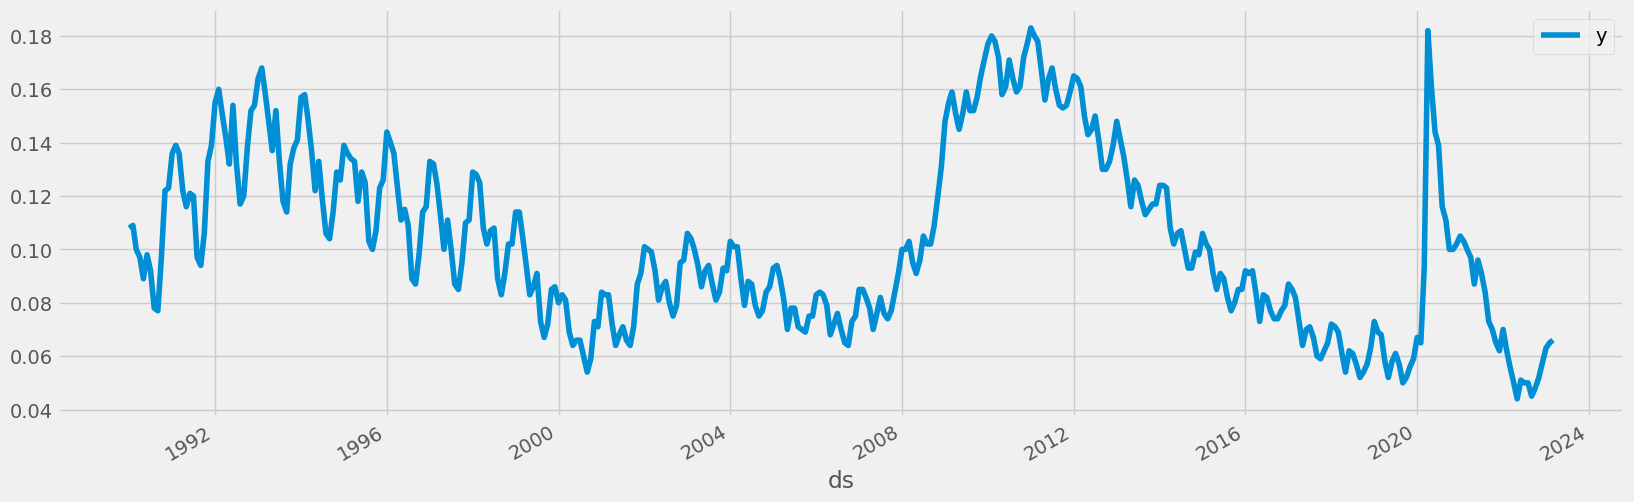

In [141]:
# rmse and prophet plot points of a baseline prophet model
prophet(San_Joaquin)

It looks like baseline Prophet models could not outperform our ARIMA models. Let's move onto the effect on unemployment rate.

## Effect on Unemployment Rate:  __[San Joaquin County](https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/County_Profiles/California/cp06077.pdf)__

Of the 6,176 total ag/migrant workers in San Joaquin County we anticipate that 772 workers would graduate from a trade school given the opportunity.

In [142]:
effect(San_Joaquin, 772)

Area Name  Labor Force  Employment  Unemployment  \
month_year                                                              
2019-01     San Joaquin County       326900      303672         23128   
2019-02     San Joaquin County       327800      306072         21728   
2019-03     San Joaquin County       327200      305572         21528   
2019-04     San Joaquin County       322300      304272         18028   
2019-05     San Joaquin County       327500      311272         16128   
2019-06     San Joaquin County       325900      307572         18328   
2019-07     San Joaquin County       326700      307372         19328   
2019-08     San Joaquin County       327600      309672         17928   
2019-09     San Joaquin County       327200      311672         15528   
2019-10     San Joaquin County       329500      312972         16428   
2019-11     San Joaquin County       328600      311072         17428   
2019-12     San Joaquin County       328700      310272         18528   

            Unemployment Rate  Unemployment Rate Change  
month_year                                               
2019-01              0.070749                  0.002251  
2019-02              0.066284                  0.002716  
2019-03              0.065795                  0.002205  
2019-04              0.055935                  0.002065  
2019-05              0.049246                  0.002754  
2019-06              0.056238                  0.001762  
2019-07              0.059161                  0.001839  
2019-08              0.054725                  0.002275  
2019-09              0.047457                  0.002543  
2019-10              0.049857                  0.002143  
2019-11              0.053037                  0.002963  
2019-12              0.056368                  0.002632

According to the EDD, there is a list of the top 5 __[In-Demand Middle-Skill Occupations](https://edd.ca.gov/siteassets/files/jobs_and_training/pubs/carrerladder_sanjoaquinvalley.pdf)__ for the entire San Joaquin Valley Region (Fresno, Inyo, Kern, Kings, Madera, Merced, Mono, San Joaquin, Stanislaus, and Tulare counties), the first of which is a Heavy and Tractor-Trailer Trucker Driver. Heavy equipment driving is not what is considered skilled trade work, but there is an eduational component involved and is skilled work, non-union represented. <br>



# Forecasting with RNN (__[Recurrent Neural Networks](https://towardsdatascience.com/temporal-loops-intro-to-recurrent-neural-networks-for-time-series-forecasting-in-python-b0398963dc1f#:~:text=Recurrent%20Neural%20Networks%3A%20The%20Concept,data%20such%20as%20time%20series.)__)

RNN's are deep learning models, typically used to solve problems with sequential input data such as time series. RNN's are a type of neural network that retains a memory of what it has already processed and thus can learn from previous iterations during its training. Majority of code is taken from walkthrough by __[Nachiketa Hebbar](https://www.youtube.com/watch?v=S8tpSG6Q2H0)__

In [143]:
# earlier in the notebook it was mentioned that we would need to
## reach back and call on this variable
### let's reset the index to a datetime and begin sorting
fresno.index = pd.to_datetime(fresno.index)

In [144]:
fresno = fresno.sort_index()

In [145]:
# let's remind ourselves how long this dataset is

len(fresno)

398

In [146]:
# give ourselves a reminder of the columns we need to drop
fresno.head()

Area Name  Labor Force  Employment  Unemployment  \
month_year                                                         
1990-01-01  Fresno County       311200      271900         39200   
1990-02-01  Fresno County       315100      271200         43900   
1990-03-01  Fresno County       315600      270900         44800   
1990-04-01  Fresno County       326900      287100         39800   
1990-05-01  Fresno County       327900      294100         33800   

            Unemployment Rate  
month_year                     
1990-01-01              0.126  
1990-02-01              0.139  
1990-03-01              0.142  
1990-04-01              0.122  
1990-05-01              0.103

In [147]:
# drop unnecessary columns from our dataset, reminder that we
## are looking at Unemployment Rate
fresno = fresno.drop(['Area Name',
             'Labor Force',
             'Employment',
             'Unemployment'], axis =1)

In [148]:
# Let's use the same train/test split from earlier in the notebook
cutoff = round(fresno.shape[0] * 0.75)
cutoff

train = fresno[:cutoff]
test = fresno[cutoff:]

In [149]:
# part of the reason that we wanted to look at percentage as
# whole numbers was to make the job of MinMaxScaler a bit
# more effective
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [150]:
# fit our estimator onto our training data and transform training
## and testing data
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [151]:
# define generator
## n_input is the number of variables our generator will consider
### n_features is the number of columns that our generator is iterating over
n_input = 3
n_features = 1

# our generator is calling on scaled_train(our estimator fitted training data)
## and will train on the n_input (in this case 3) before spitting out a new
### variable that it has been trained on
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length=n_input,
                                batch_size=1)

In [152]:
# to further the notes on generator, the first array has three values, these
## values are what our generator trained on. The predicted 'y' is a
### prediction that our generator made on our scaled training data
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n{y}')

Given the Array: 
[0.49606299 0.5984252  0.62204724]
Predict this y: 
[[0.46456693]]


In [153]:
# this will return a (1,3,1), meaning one batch, n_inputs, and 1 output or
## prediction
X.shape

(1, 3, 1)

In [154]:
# Let's do the same operation as above but with 12 points that our generator
## will consider now instead of 3. We anticipate that this will give us a
### value with a lower RMSE
n_input = 12
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length = n_input,
                                batch_size = 1)

In [155]:
# define our model
model = Sequential()
model.add(LSTM(100, activation='linear', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [156]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [157]:
# fit model onto generator, we will begin with 50 epochs
model.fit(generator, epochs=50)

Epoch 1/50
286/286 [==============================] - 4s 8ms/step - loss: 0.0339
Epoch 2/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0196
Epoch 3/50
286/286 [==============================] - 3s 11ms/step - loss: 0.0117
Epoch 4/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0084
Epoch 5/50
286/286 [==============================] - 2s 7ms/step - loss: 0.0082
Epoch 6/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0075
Epoch 7/50
286/286 [==============================] - 3s 11ms/step - loss: 0.0074
Epoch 8/50
286/286 [==============================] - 2s 7ms/step - loss: 0.0076
Epoch 9/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0073
Epoch 10/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0073
Epoch 11/50
286/286 [==============================] - 3s 11ms/step - loss: 0.0074
Epoch 12/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0071
Epoch 13/50
286/286 [=

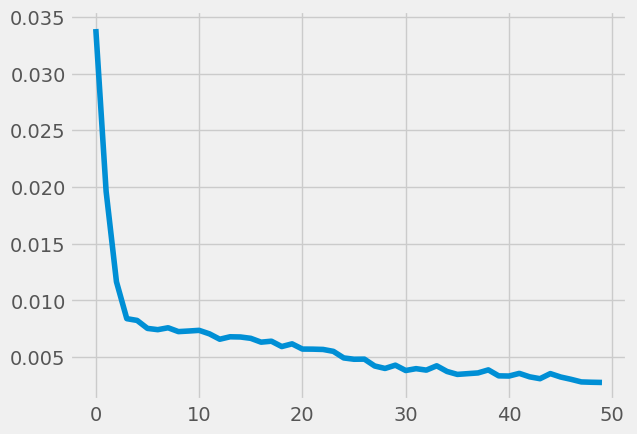

In [158]:
# this plot, loss_per_epoch is meant to show us if there is a large
## magnitude of loss prior to an arbitrary 'stopping point', in other
### words, is it worth the time and computing power to train a model
#### on a higher number of epochs / utilize cpu/gpu resources for a
##### result that may not provide much difference?
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

Great! We were able to fit our scaled training and testing data ont a LSTM RNN model with 50 epochs.

In [159]:
# last train_batch will return the last twelve values in scaled_train
last_train_batch = scaled_train[-12:]

In [160]:
# this line of code reshapes the final 12 values in last_train batch
## to give us our first predicted value
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [161]:
# this line of code will predict the first value of our prediction
model.predict(last_train_batch)

1/1 [==============================] - 0s 247ms/step


array([[0.41550264]], dtype=float32)

In [162]:
# scaled_test[0] will give us the first value of our test set:
## we can compare the first predicted value of our model and the
### actual value from our test set
scaled_test[0]

array([0.37795276])

In [163]:
# test_predictions is an empty list that will be filled with the following:
## for each scaled_train set of 12 values, one will be dropped and the next will
### be appended to the list test_preditions, this will continue for the length
#### of our test set
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

1/1 [==============================] - 0s 43ms/step


In [164]:
test_predictions

[array([0.41550264], dtype=float32),
 array([0.36159682], dtype=float32),
 array([0.31919226], dtype=float32),
 array([0.33770522], dtype=float32),
 array([0.35743064], dtype=float32),
 array([0.3173269], dtype=float32),
 array([0.24270745], dtype=float32),
 array([0.2175767], dtype=float32),
 array([0.24926436], dtype=float32),
 array([0.2637837], dtype=float32),
 array([0.24120525], dtype=float32),
 array([0.2563452], dtype=float32),
 array([0.3072989], dtype=float32),
 array([0.3397033], dtype=float32),
 array([0.31959897], dtype=float32),
 array([0.28652877], dtype=float32),
 array([0.26840776], dtype=float32),
 array([0.2632941], dtype=float32),
 array([0.24082565], dtype=float32),
 array([0.21365003], dtype=float32),
 array([0.22224592], dtype=float32),
 array([0.26725808], dtype=float32),
 array([0.30823088], dtype=float32),
 array([0.33124596], dtype=float32),
 array([0.35463685], dtype=float32),
 array([0.36777234], dtype=float32),
 array([0.35305348], dtype=float32),
 array([

In [165]:
test.tail()

Unemployment Rate
month_year                   
2022-10-01              0.058
2022-11-01              0.063
2023-01-01              0.076
2023-02-01              0.083
2023-03-01              0.086

In [166]:
# scaler.inverse_transform will take only the first column of values from the
## 2D array passed through originally and discard the rest making our
### true_predictions variable
true_predictions = scaler.inverse_transform(test_predictions)

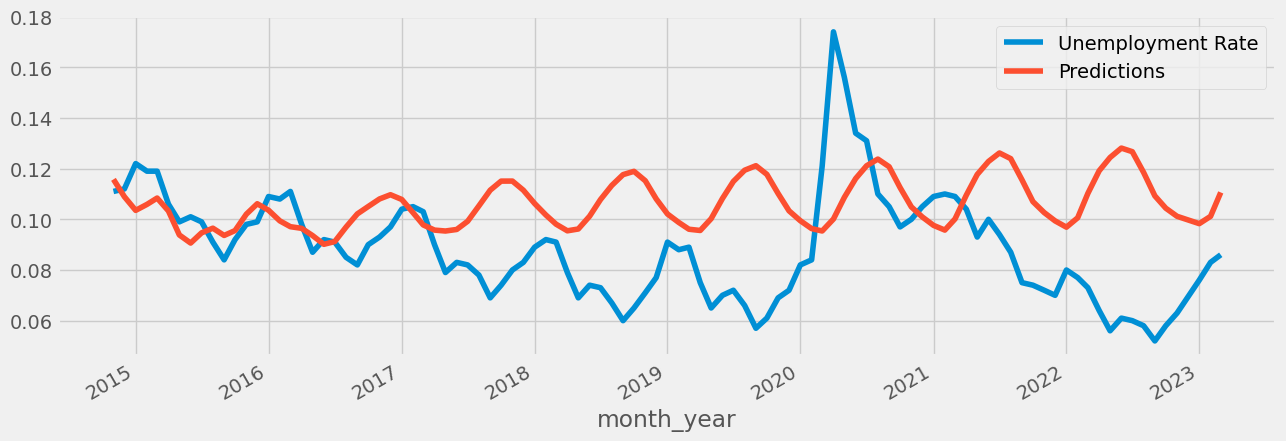

In [167]:
# we are adding a column to our test set, 'Predictions' which functionally is our
## list of true_predictions from the previous line of code
### plot of our test(real) values against our predicted values
test['Predictions'] = true_predictions
test.plot(figsize=(14,5));

In [168]:
# rmse of our actual unemployment rate against predicted unemployment rate
rmse = sqrt(mean_squared_error(test['Unemployment Rate'], test['Predictions']))
print(rmse)

0.030299391005268222


This is significantly worse than the performance we got from our gridsearch ARIMA models, but let's see if we can improve the performance by placing a similar gridsearch function onto our RNN model.

## Improving RNN Performance

Though not necessary under every circumstance, let's see if we get a lower RMSE (therefore more accurate) score on a stationary model.

In [169]:
# make stationary data out of our fresno dataset
county = fresno.diff(periods =1)
county.head()

Unemployment Rate
month_year                   
1990-01-01                NaN
1990-02-01              0.013
1990-03-01              0.003
1990-04-01             -0.020
1990-05-01             -0.019

In [170]:
# Drop null values
county = county.dropna()

In [171]:
# we can change our train/test split in future versions of the
## model, but for now let's use the original split
cutoff = round(county.shape[0] *0.75)
cutoff

train = county[:cutoff]
test = county[cutoff: ]

In [172]:
# fit our scaler onto training data and transform split data
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [173]:
# this is the same generator as in our previous model, using the previous 12
## values in our scaled_train set to predict the next 1 value
n_input = 12
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length = n_input,
                                batch_size = 1)

In [174]:
model = Sequential()
model.add(LSTM(100, activation='linear', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [175]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [176]:
# We will use the same number of epochs as we did previously
model.fit(generator, epochs = 50)

Epoch 1/50
286/286 [==============================] - 4s 8ms/step - loss: 0.0406
Epoch 2/50
286/286 [==============================] - 3s 10ms/step - loss: 0.0323
Epoch 3/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0241
Epoch 4/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0204
Epoch 5/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0206
Epoch 6/50
286/286 [==============================] - 3s 10ms/step - loss: 0.0182
Epoch 7/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0167
Epoch 8/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0177
Epoch 9/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0156
Epoch 10/50
286/286 [==============================] - 3s 11ms/step - loss: 0.0142
Epoch 11/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0168
Epoch 12/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0150
Epoch 13/50
286/286 [=

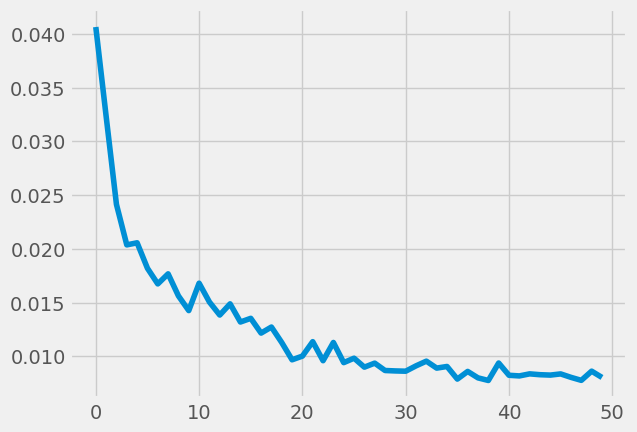

In [177]:
# plot our loss_per_epoch
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

In [178]:
last_train_batch = scaled_train[-12:]

In [179]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [180]:
# this is our predicted first value of our test set
model.predict(last_train_batch)

1/1 [==============================] - 0s 220ms/step


array([[0.5302067]], dtype=float32)

In [181]:
# this is the actual first value of our test set
scaled_test[0]

array([0.515625])

In [182]:
# this is the same test_prediction list as before
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

1/1 [==============================] - 0s 35ms/step


In [183]:
test_predictions

[array([0.5302067], dtype=float32),
 array([0.621402], dtype=float32),
 array([0.49375746], dtype=float32),
 array([0.47714296], dtype=float32),
 array([0.23920287], dtype=float32),
 array([0.33226782], dtype=float32),
 array([0.5317464], dtype=float32),
 array([0.47996524], dtype=float32),
 array([0.38330036], dtype=float32),
 array([0.40275314], dtype=float32),
 array([0.56876934], dtype=float32),
 array([0.61142015], dtype=float32),
 array([0.5387124], dtype=float32),
 array([0.58804685], dtype=float32),
 array([0.49343482], dtype=float32),
 array([0.43965304], dtype=float32),
 array([0.25550544], dtype=float32),
 array([0.34215486], dtype=float32),
 array([0.5261997], dtype=float32),
 array([0.46651298], dtype=float32),
 array([0.38244638], dtype=float32),
 array([0.42630714], dtype=float32),
 array([0.56384325], dtype=float32),
 array([0.6002519], dtype=float32),
 array([0.54323363], dtype=float32),
 array([0.5649625], dtype=float32),
 array([0.4879575], dtype=float32),
 array([0.

In [184]:
test.tail()

Unemployment Rate
month_year                   
2022-10-01              0.006
2022-11-01              0.005
2023-01-01              0.013
2023-02-01              0.007
2023-03-01              0.003

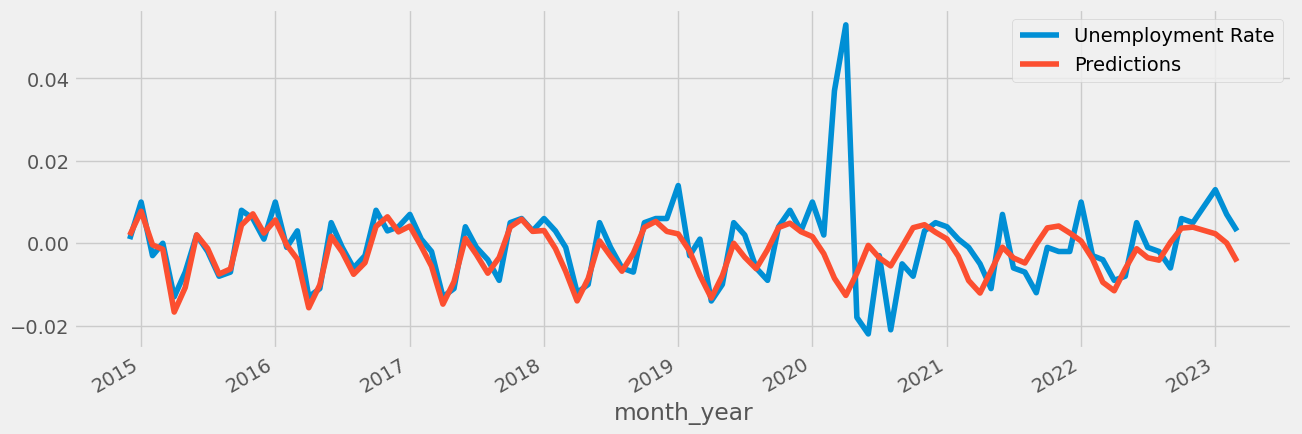

In [185]:
# This visual will show that our test data and predictive data are slightly
## closer together, visually
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(14,5));

Visually this is a huge improvement. Let's see what our RMSE score is.

In [186]:
# our rmse should be lower than the previous rmse as well
rmse = sqrt(mean_squared_error(test['Unemployment Rate'], test['Predictions']))
print(rmse)

0.009576852356972863


In terms of accuracy this is a significant improvement, however our ARIMA model with gridsearch is still a better performant model.

### Further improvements

Let's try using a smaller test set.

In [187]:
# index_show is just a placeholder variable to reset the index of our data on
## and so that we can create a one year test pool
index_show = county.reset_index()
index_show

month_year  Unemployment Rate
0   1990-02-01              0.013
1   1990-03-01              0.003
2   1990-04-01             -0.020
3   1990-05-01             -0.019
4   1990-06-01             -0.006
..         ...                ...
392 2022-10-01              0.006
393 2022-11-01              0.005
394 2023-01-01              0.013
395 2023-02-01              0.007
396 2023-03-01              0.003

[397 rows x 2 columns]

In [188]:
# We used data from 2014 previously, let's try just using one year for our test set
train = county[:384]
test = county[384:]

In [189]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [190]:
# this is the same n_input where we use 12 previous values to predict the next
n_input = 12
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length = n_input,
                                batch_size = 1)

In [191]:
# define our model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [192]:
# We will continue using 50 epochs for this model; we did change the train/test
## split for this version of the model
model.fit(generator, epochs = 50)

Epoch 1/50
372/372 [==============================] - 6s 11ms/step - loss: 0.0212
Epoch 2/50
372/372 [==============================] - 4s 10ms/step - loss: 0.0168
Epoch 3/50
372/372 [==============================] - 3s 9ms/step - loss: 0.0150
Epoch 4/50
372/372 [==============================] - 3s 9ms/step - loss: 0.0133
Epoch 5/50
372/372 [==============================] - 4s 9ms/step - loss: 0.0115
Epoch 6/50
372/372 [==============================] - 3s 9ms/step - loss: 0.0106
Epoch 7/50
372/372 [==============================] - 3s 9ms/step - loss: 0.0103
Epoch 8/50
372/372 [==============================] - 3s 9ms/step - loss: 0.0143
Epoch 9/50
372/372 [==============================] - 3s 8ms/step - loss: 0.0145
Epoch 10/50
372/372 [==============================] - 4s 10ms/step - loss: 0.0098
Epoch 11/50
372/372 [==============================] - 3s 8ms/step - loss: 0.0081
Epoch 12/50
372/372 [==============================] - 3s 8ms/step - loss: 0.0071
Epoch 13/50
372/372 [=

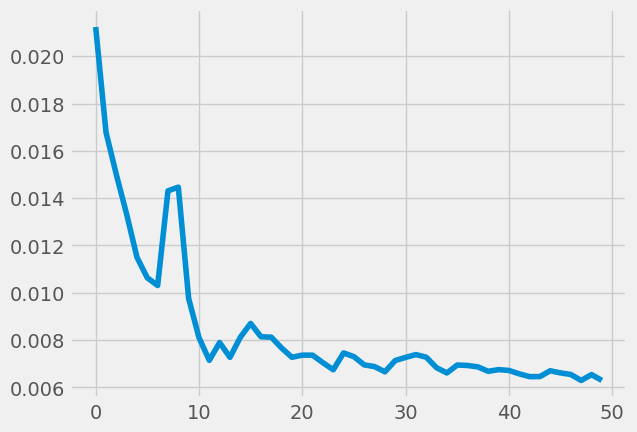

In [193]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

In [194]:
# this is the same line of code as before/will use previous 12 values to predict
## the next value and append that new value to the test_predictions list and use
### that value to help predict the next value
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

1/1 [==============================] - 0s 40ms/step


In [195]:
test_predictions

[array([0.40955102], dtype=float32),
 array([0.37375942], dtype=float32),
 array([0.33130422], dtype=float32),
 array([0.27296728], dtype=float32),
 array([0.43945923], dtype=float32),
 array([0.33104286], dtype=float32),
 array([0.30495507], dtype=float32),
 array([0.26236993], dtype=float32),
 array([0.36440665], dtype=float32),
 array([0.3670557], dtype=float32),
 array([0.36456576], dtype=float32),
 array([0.48119476], dtype=float32),
 array([0.4223558], dtype=float32)]

In [196]:
test.sort_index()

Unemployment Rate
month_year                   
2022-02-01             -0.003
2022-03-01             -0.004
2022-04-01             -0.009
2022-05-01             -0.008
2022-06-01              0.005
2022-07-01             -0.001
2022-08-01             -0.002
2022-09-01             -0.006
2022-10-01              0.006
2022-11-01              0.005
2023-01-01              0.013
2023-02-01              0.007
2023-03-01              0.003

In [197]:
print(test.index)

DatetimeIndex(['2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01',
               '2022-10-01', '2022-11-01', '2023-01-01', '2023-02-01',
               '2023-03-01'],
              dtype='datetime64[ns]', name='month_year', freq=None)


In [198]:
true_predictions = scaler.inverse_transform(test_predictions)

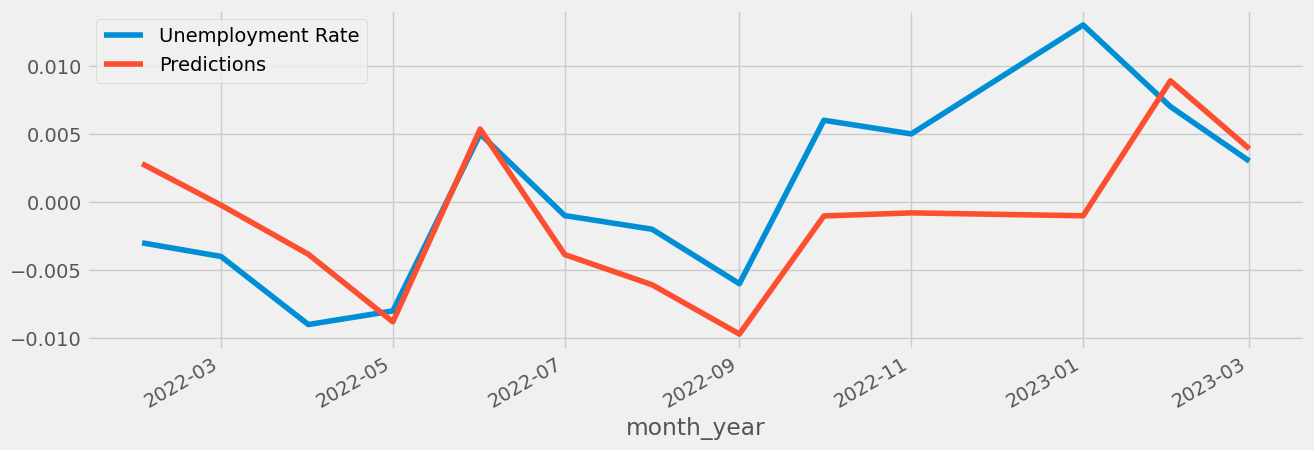

In [199]:
test['Predictions'] = true_predictions
test.plot(figsize=(14,5));

In [200]:
# this should give us our lowest rmse score for RNN models on Fresno county
rmse = sqrt(mean_squared_error(test['Unemployment Rate'], test['Predictions']))
print(rmse)

0.0055306590120897696


This new score far outperforms our ARIMA gridsearch model!

## RNN Prediction 12 Next Months: Fresno County

We were able to find an RMSE low enough to predict the next 12 months on. This is a score lower than our ARIMA models and should be considered a more accurate model than our previous models on Fresno County.

In [201]:
# Let's create a list that is 12 months into the future.
new_list = ['2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01',
               '2022-10-01', '2022-11-01', '2023-01-01', '2023-02-01',
               '2023-03-01',
 '2023-04-01',
 '2023-05-01',
 '2023-06-01',
 '2023-07-01',
 '2023-08-01',
 '2023-09-01',
 '2023-10-01',
 '2023-11-01',
 '2023-12-01',
 '2024-01-01',
 '2024-02-01',
 '2024-03-01']

In [202]:
# these are the same lines of code save for one line:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
# new_list as shown above is 12 months farther out than our test set
## effectively this is how our model will create predictions, utilizing
### our model with the smallest amount of errors and creating predictions
#### based on the previous 12 predictions
for i in range(len(new_list)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

1/1 [==============================] - 0s 41ms/step


In [203]:
# though this is the same variable name that we used previously, this
## variable will give us the predictions from not only the beginning
### indexes of the test set, but twelve months beyond the end of our
#### test set
test_predictions

[array([0.40955102], dtype=float32),
 array([0.37375942], dtype=float32),
 array([0.33130422], dtype=float32),
 array([0.27296728], dtype=float32),
 array([0.43945923], dtype=float32),
 array([0.33104286], dtype=float32),
 array([0.30495507], dtype=float32),
 array([0.26236993], dtype=float32),
 array([0.36440665], dtype=float32),
 array([0.3670557], dtype=float32),
 array([0.36456576], dtype=float32),
 array([0.48119476], dtype=float32),
 array([0.4223558], dtype=float32),
 array([0.38000983], dtype=float32),
 array([0.34016818], dtype=float32),
 array([0.2893257], dtype=float32),
 array([0.42206097], dtype=float32),
 array([0.346296], dtype=float32),
 array([0.31259042], dtype=float32),
 array([0.278435], dtype=float32),
 array([0.36338586], dtype=float32),
 array([0.37651473], dtype=float32),
 array([0.373919], dtype=float32),
 array([0.46898884], dtype=float32),
 array([0.4295835], dtype=float32)]

In [204]:
# create new dataset from our test_predictions
test_predictions = pd.DataFrame(test_predictions)

In [205]:
test_predictions

0
0   0.409551
1   0.373759
2   0.331304
3   0.272967
4   0.439459
5   0.331043
6   0.304955
7   0.262370
8   0.364407
9   0.367056
10  0.364566
11  0.481195
12  0.422356
13  0.380010
14  0.340168
15  0.289326
16  0.422061
17  0.346296
18  0.312590
19  0.278435
20  0.363386
21  0.376515
22  0.373919
23  0.468989
24  0.429583

In [206]:
# 'Year' column will be matched against our variable new_list that includes
## dates that are 12 months beyond the test set
test_predictions['Year'] = new_list

In [207]:
print(test_predictions.head())
print()
print(test_predictions.tail())

          0        Year
0  0.409551  2022-02-01
1  0.373759  2022-03-01
2  0.331304  2022-04-01
3  0.272967  2022-05-01
4  0.439459  2022-06-01

           0        Year
20  0.363386  2023-11-01
21  0.376515  2023-12-01
22  0.373919  2024-01-01
23  0.468989  2024-02-01
24  0.429583  2024-03-01


In [208]:
# map variable creates 'Predictions' column on 0 column
map = {test_predictions.columns[0]:'Predictions'}
test_predictions = test_predictions.rename(columns = map)

In [209]:
# set 'Year' as our index
test_predictions = test_predictions.set_index(['Year'])

In [210]:
true_predictions = scaler.inverse_transform(test_predictions)

In [211]:
test_predictions['Predictions'] = true_predictions

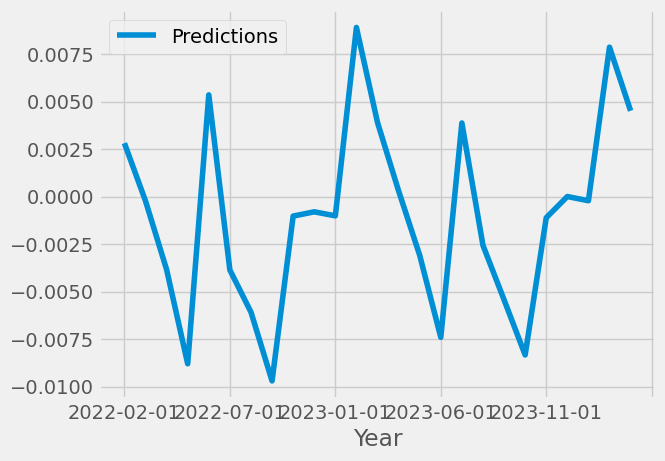

In [212]:
# this line will plot the entirety of our prediction, test set to 12 months
## beyond our test set
test_predictions.plot();

In [213]:
# tp variable will isolate only the final 12 values in our test_predictions
tp = test_predictions.iloc[-12:]

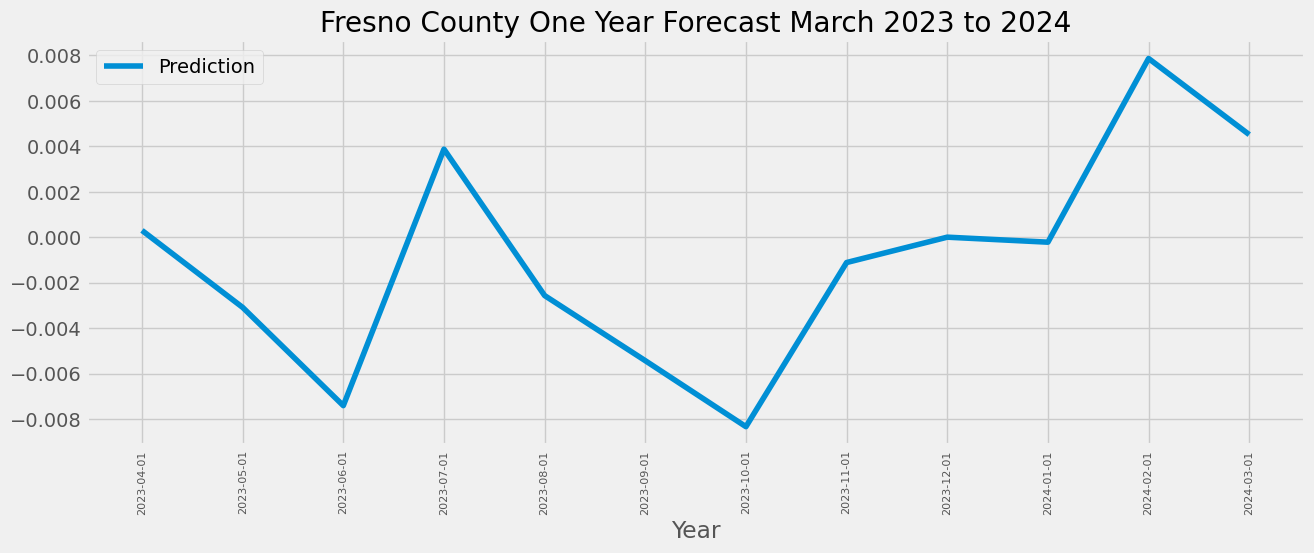

In [214]:
# plot our results
fig, ax = plt.subplots(figsize = (14,5))
plt.xticks(fontsize = 8, rotation = 90)
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax), 1))

ax.plot(tp, label = "Prediction")

ax.set_title('Fresno County One Year Forecast March 2023 to 2024')
ax.set_xlabel('Year')
ax.set_xticks(range(0, len(tp), 1))
ax.legend();

## Fresno County Educational Program

Our recommendation is a 6 month program for Fresno County that would be on a three month track system from June to October with a hiatus/break until Novemeber to February.

# RNN: Monterey County

In [215]:
# We will repeat the steps from above to see what our baseline score is on Monterey County Data
Monterey.head()

Area Name  Labor Force  Employment  Unemployment  \
month_year                                                           
1990-04     Monterey County       173300      156300         17000   
1990-08     Monterey County       174200      162300         11900   
1990-12     Monterey County       174200      151000         23200   
1990-02     Monterey County       168600      145800         22800   
1990-01     Monterey County       166900      143600         23300   

            Unemployment Rate  
month_year                     
1990-04                 0.098  
1990-08                 0.068  
1990-12                 0.133  
1990-02                 0.135  
1990-01                 0.140

In [216]:
Monterey = Monterey.sort_index()

In [217]:
# Drop all columns except for 'Unemployment Rate'
Monterey = Monterey.drop(['Area Name',
                          'Labor Force',
                          'Employment',
                          'Unemployment'], axis = 1)

In [218]:
# Fresno county's data that had a smaller validation set gave us better performance, let's still try and see if that
# is true by testing first the original train/test split
cutoff = round(Monterey.shape[0] * 0.75)
cutoff

train = Monterey[:cutoff]
test = Monterey[cutoff:]

In [219]:
# fit scaler onto training data and transform train/test split
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [220]:
# n_input is 12, the goal is to use previous 12 values to predict the next value
n_input = 12
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length = n_input,
                                batch_size =1)

In [221]:
# define our model
model = Sequential()
model.add(LSTM(100, activation='linear', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [222]:
# model fit onto generator, 50 epochs
model.fit(generator, epochs = 50)

Epoch 1/50
286/286 [==============================] - 4s 9ms/step - loss: 0.0436
Epoch 2/50
286/286 [==============================] - 3s 11ms/step - loss: 0.0134
Epoch 3/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0092
Epoch 4/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0087
Epoch 5/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0087
Epoch 6/50
286/286 [==============================] - 3s 9ms/step - loss: 0.0084
Epoch 7/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0074
Epoch 8/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0067
Epoch 9/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0066
Epoch 10/50
286/286 [==============================] - 3s 10ms/step - loss: 0.0066
Epoch 11/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0058
Epoch 12/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0060
Epoch 13/50
286/286 [==

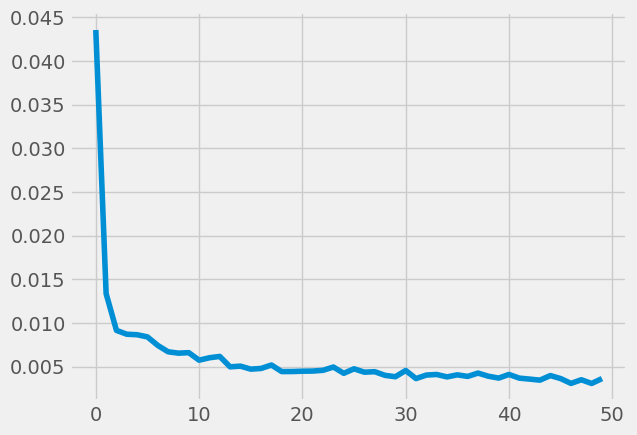

In [223]:
# Plot loss_per_epoch
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

In [224]:
# last_train_batch is the scaled training data's final 12 values
last_train_batch = scaled_train[-12:]

In [225]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [226]:
# this line of code will return the first prediction from our model based on the
## the previous 12 values from our training data
model.predict(last_train_batch)

1/1 [==============================] - 0s 214ms/step


array([[0.28301454]], dtype=float32)

In [227]:
# scaled_test is the first value of our test dataset
scaled_test[0]

array([0.2516129])

In [228]:
# test_predictions is an empty list that will train on previous 12 values and predict
## the next, after that prediction is made the first value of the training data will
### be dropped and the next 12 values will be used to predict the next. This will go
#### for the length of the test dataset, based on RMSE we will determine if this is
##### an accurate model
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

1/1 [==============================] - 0s 34ms/step


In [229]:
test_predictions

[array([0.28301454], dtype=float32),
 array([0.47616422], dtype=float32),
 array([0.5842338], dtype=float32),
 array([0.587132], dtype=float32),
 array([0.49033564], dtype=float32),
 array([0.3287599], dtype=float32),
 array([0.19974765], dtype=float32),
 array([0.1495183], dtype=float32),
 array([0.10236297], dtype=float32),
 array([0.05619976], dtype=float32),
 array([0.02329081], dtype=float32),
 array([0.02780955], dtype=float32),
 array([0.17718175], dtype=float32),
 array([0.43531173], dtype=float32),
 array([0.60638005], dtype=float32),
 array([0.6479074], dtype=float32),
 array([0.5583064], dtype=float32),
 array([0.33687973], dtype=float32),
 array([0.13900438], dtype=float32),
 array([0.10405669], dtype=float32),
 array([0.05100305], dtype=float32),
 array([-0.00700355], dtype=float32),
 array([-0.03733172], dtype=float32),
 array([-0.0768036], dtype=float32),
 array([0.04670573], dtype=float32),
 array([0.39029256], dtype=float32),
 array([0.61223614], dtype=float32),
 array

In [230]:
true_predictions = scaler.inverse_transform(test_predictions)

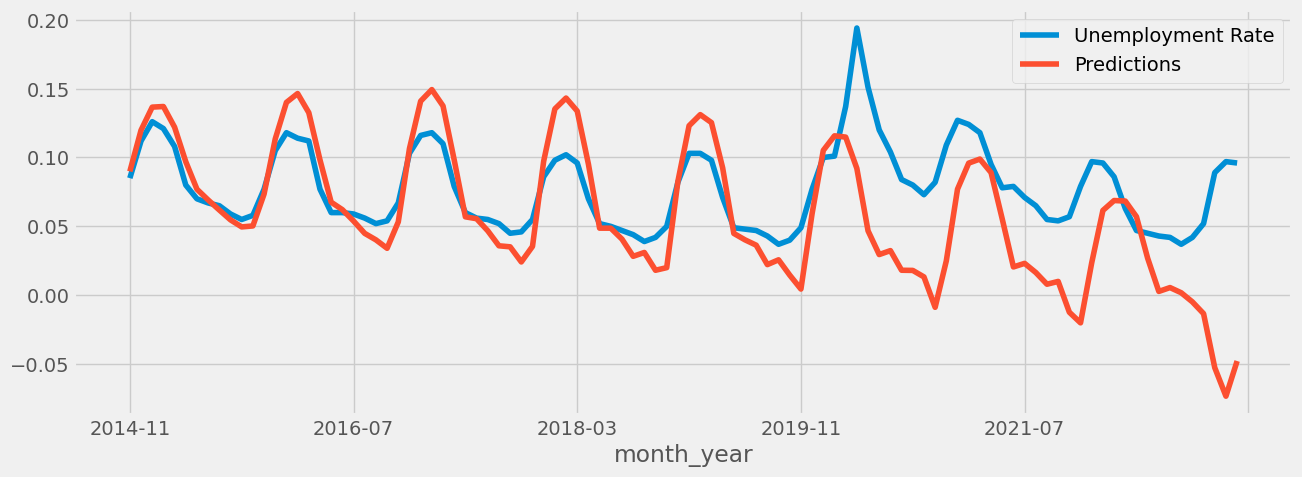

In [231]:
test['Predictions'] = true_predictions
test.plot(figsize=(14,5));

In [232]:
# return rmse score
rmse = sqrt(mean_squared_error(test['Unemployment Rate'], test['Predictions']))
print(rmse)

0.045023092495882114


This is already very near the best performant ARIMA
model for Monterey County; let's continue improving this model.

##  **Improving RNN Performance**

Just like we did with improving Fresno County data, let's create stationary data for Monterey County

In [233]:
# create stationary data on Monterey county data
county = Monterey.diff(periods = 1)

In [234]:
county = county.dropna()

In [235]:
# train/test split of 75/25
cutoff = round(county.shape[0] *0.75)
cutoff

train = county[:cutoff]
test = county[cutoff: ]

In [236]:
# fit scaler onto training data and transform train/test split
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [237]:
# create generator that will train on previous 12 values
n_input = 12
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length = n_input,
                                batch_size = 1)


In [238]:
model = Sequential()
model.add(LSTM(100, activation='linear', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [239]:
# fit model onto generator, 50 epochs
model.fit(generator, epochs = 50)

Epoch 1/50
286/286 [==============================] - 4s 8ms/step - loss: 0.0497
Epoch 2/50
286/286 [==============================] - 3s 11ms/step - loss: 0.0184
Epoch 3/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0130
Epoch 4/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0127
Epoch 5/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0103
Epoch 6/50
286/286 [==============================] - 3s 10ms/step - loss: 0.0117
Epoch 7/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0106
Epoch 8/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0104
Epoch 9/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0123
Epoch 10/50
286/286 [==============================] - 3s 10ms/step - loss: 0.0104
Epoch 11/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0108
Epoch 12/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0098
Epoch 13/50
286/286 [=

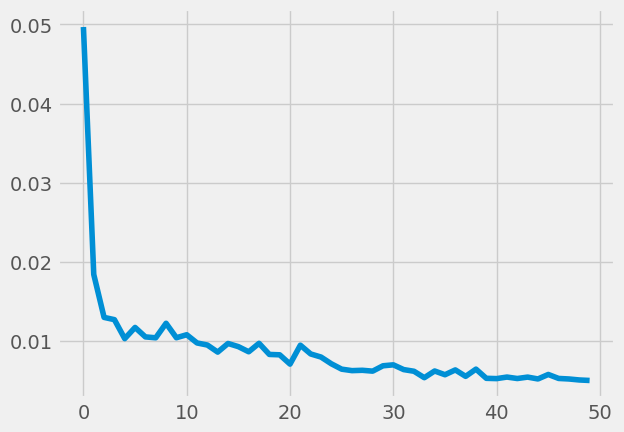

In [240]:
# plot loss_per_epoch
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [241]:
# last_train_batch is the last 12 values in scaled_train data
last_train_batch = scaled_train[-12:]

In [242]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [243]:
# model prediction of first value in test set
model.predict(last_train_batch)

1/1 [==============================] - 0s 208ms/step


array([[0.698492]], dtype=float32)

In [244]:
# actual first value in our test dataset
scaled_test[0]

array([0.74285714])

In [245]:
# test_predictions is an empty list that will train on previous 12 values and predict
## the next, after that prediction is made the first value of the training data will
### be dropped and the next 12 values will be used to predict the next. This will go
#### for the length of the test dataset, based on RMSE we will determine if this is
##### an accurate model
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

1/1 [==============================] - 0s 35ms/step


In [246]:
test_predictions

[array([0.698492], dtype=float32),
 array([0.59389365], dtype=float32),
 array([0.47592428], dtype=float32),
 array([0.39584988], dtype=float32),
 array([0.30506128], dtype=float32),
 array([0.38180304], dtype=float32),
 array([0.44796637], dtype=float32),
 array([0.46528974], dtype=float32),
 array([0.46590474], dtype=float32),
 array([0.49615738], dtype=float32),
 array([0.5658778], dtype=float32),
 array([0.6472175], dtype=float32),
 array([0.6513455], dtype=float32),
 array([0.565175], dtype=float32),
 array([0.4696298], dtype=float32),
 array([0.3961103], dtype=float32),
 array([0.35528514], dtype=float32),
 array([0.39591688], dtype=float32),
 array([0.44163656], dtype=float32),
 array([0.4646639], dtype=float32),
 array([0.48499268], dtype=float32),
 array([0.52388227], dtype=float32),
 array([0.5814196], dtype=float32),
 array([0.6291735], dtype=float32),
 array([0.61491805], dtype=float32),
 array([0.5416961], dtype=float32),
 array([0.46104342], dtype=float32),
 array([0.4000

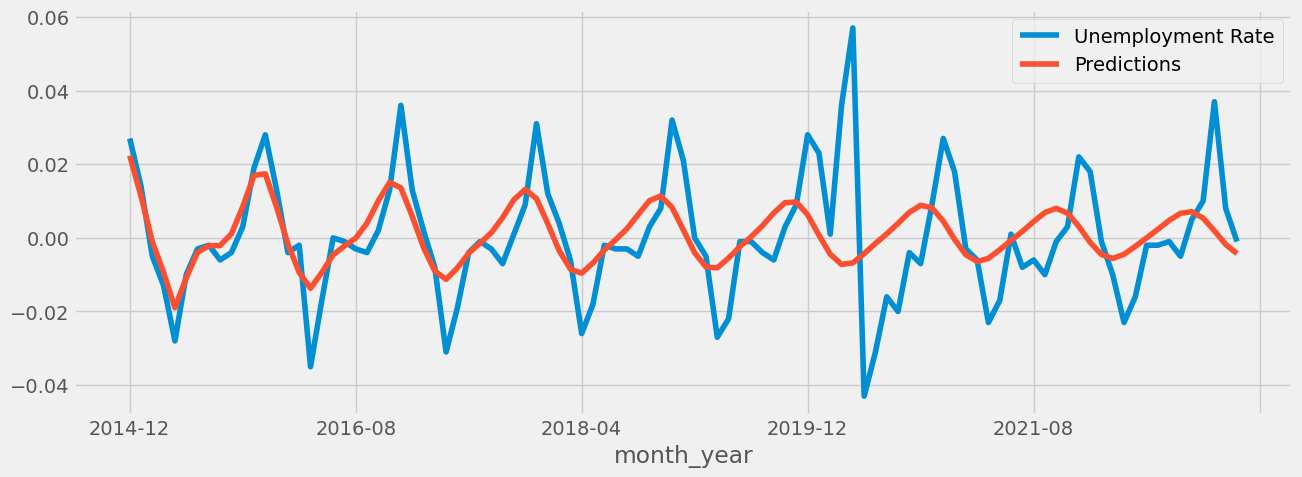

In [247]:
# plotted data is our test dataset and our predictive model output
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(14,5));

In [248]:

rmse = sqrt(mean_squared_error(test['Unemployment Rate'], test['Predictions']))
print(rmse)

0.01447943618432631


We were able to improve our model, let's try a smaller test set to see if we can further boost performance.

## Further Improvements: Smaller Test Set Monterey County

In [249]:
# train/test split, test set is one year
train = county[:384]
test = county[384:]

In [250]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [251]:
n_input = 12
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length = n_input,
                                batch_size = 1)

In [252]:
# define our model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [254]:
# fit our model onto our generator, 50 epochs
model.fit(generator, epochs = 50)

Epoch 1/50
372/372 [==============================] - 14s 16ms/step - loss: 0.0353
Epoch 2/50
372/372 [==============================] - 6s 15ms/step - loss: 0.0171
Epoch 3/50
372/372 [==============================] - 7s 18ms/step - loss: 0.0143
Epoch 4/50
372/372 [==============================] - 6s 17ms/step - loss: 0.0116
Epoch 5/50
372/372 [==============================] - 7s 19ms/step - loss: 0.0103
Epoch 6/50
372/372 [==============================] - 6s 16ms/step - loss: 0.0092
Epoch 7/50
372/372 [==============================] - 5s 13ms/step - loss: 0.0100
Epoch 8/50
372/372 [==============================] - 4s 10ms/step - loss: 0.0091
Epoch 9/50
372/372 [==============================] - 3s 8ms/step - loss: 0.0102
Epoch 10/50
372/372 [==============================] - 3s 8ms/step - loss: 0.0088
Epoch 11/50
372/372 [==============================] - 4s 10ms/step - loss: 0.0088
Epoch 12/50
372/372 [==============================] - 3s 8ms/step - loss: 0.0084
Epoch 13/50
372

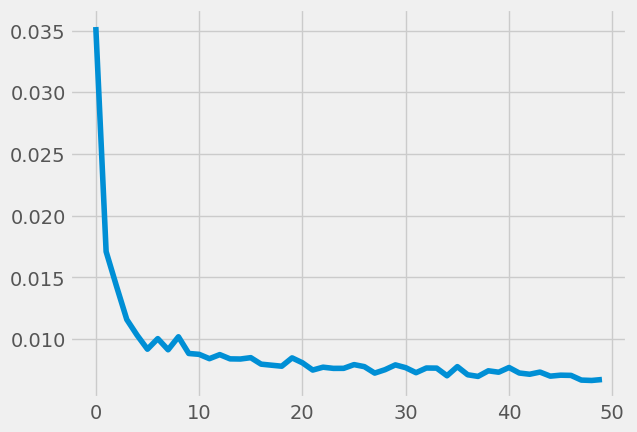

In [255]:
# plot loss_per_epoch
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

In [256]:
# test_predictions is an empty list that will train on previous 12 values and predict
## the next, after that prediction is made the first value of the training data will
### be dropped and the next 12 values will be used to predict the next. This will go
#### for the length of the test dataset, based on RMSE we will determine if this is
##### an accurate model
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

1/1 [==============================] - 0s 36ms/step


In [257]:
test_predictions

[array([0.4730993], dtype=float32),
 array([0.43014455], dtype=float32),
 array([0.34931484], dtype=float32),
 array([0.37357825], dtype=float32),
 array([0.45777762], dtype=float32),
 array([0.4401874], dtype=float32),
 array([0.44092655], dtype=float32),
 array([0.42847234], dtype=float32),
 array([0.46477062], dtype=float32),
 array([0.52291703], dtype=float32),
 array([0.6520993], dtype=float32),
 array([0.61712146], dtype=float32),
 array([0.48594743], dtype=float32)]

In [258]:
true_predictions = scaler.inverse_transform(test_predictions)

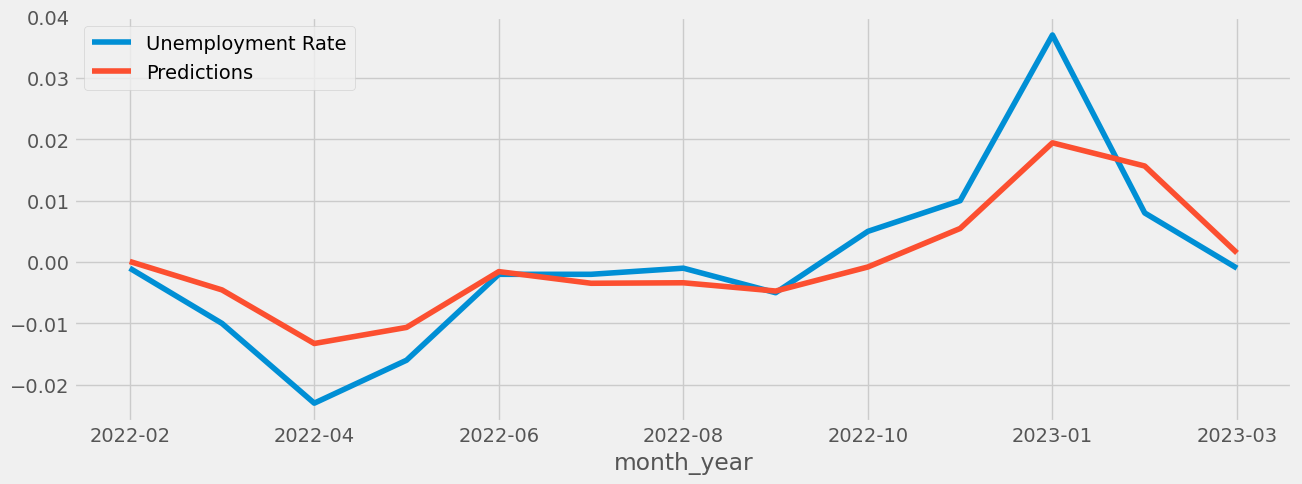

In [259]:
# plot visual of test set vs predictions for final year
test['Predictions'] = true_predictions
test.plot(figsize=(14,5));

In [260]:
# print our rmse
rmse = sqrt(mean_squared_error(test['Unemployment Rate'], test['Predictions']))
print(rmse)

0.006736054172514122


## Predict 2023-2024: Monterey County

In [261]:
# we will not need to recreate our new_list but will need it for test_predictions
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(new_list)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

1/1 [==============================] - 0s 48ms/step


In [262]:
test_predictions

[array([0.4730993], dtype=float32),
 array([0.43014455], dtype=float32),
 array([0.34931484], dtype=float32),
 array([0.37357825], dtype=float32),
 array([0.45777762], dtype=float32),
 array([0.4401874], dtype=float32),
 array([0.44092655], dtype=float32),
 array([0.42847234], dtype=float32),
 array([0.46477062], dtype=float32),
 array([0.52291703], dtype=float32),
 array([0.6520993], dtype=float32),
 array([0.61712146], dtype=float32),
 array([0.48594743], dtype=float32),
 array([0.442567], dtype=float32),
 array([0.40057582], dtype=float32),
 array([0.4089654], dtype=float32),
 array([0.45384467], dtype=float32),
 array([0.4596207], dtype=float32),
 array([0.45751047], dtype=float32),
 array([0.4523937], dtype=float32),
 array([0.4730327], dtype=float32),
 array([0.53185093], dtype=float32),
 array([0.6327776], dtype=float32),
 array([0.5975215], dtype=float32),
 array([0.4913625], dtype=float32)]

In [263]:
# create dataset of our test_predictions
test_predictions = pd.DataFrame(test_predictions)

In [264]:
test_predictions

0
0   0.473099
1   0.430145
2   0.349315
3   0.373578
4   0.457778
5   0.440187
6   0.440927
7   0.428472
8   0.464771
9   0.522917
10  0.652099
11  0.617121
12  0.485947
13  0.442567
14  0.400576
15  0.408965
16  0.453845
17  0.459621
18  0.457510
19  0.452394
20  0.473033
21  0.531851
22  0.632778
23  0.597521
24  0.491363

In [265]:
# create 'Year' column from new_list index
test_predictions['Year'] = new_list

In [266]:
# recall our column naming convention from earlier 'map'
test_predictions = test_predictions.rename(columns = map)

In [267]:
test_predictions = test_predictions.set_index(['Year'])

In [268]:
true_predictions = scaler.inverse_transform(test_predictions)

In [269]:
test_predictions['Predictions'] = true_predictions

In [270]:
# tp is our final 12 values in the prediction set
tp = test_predictions.iloc[-12:]

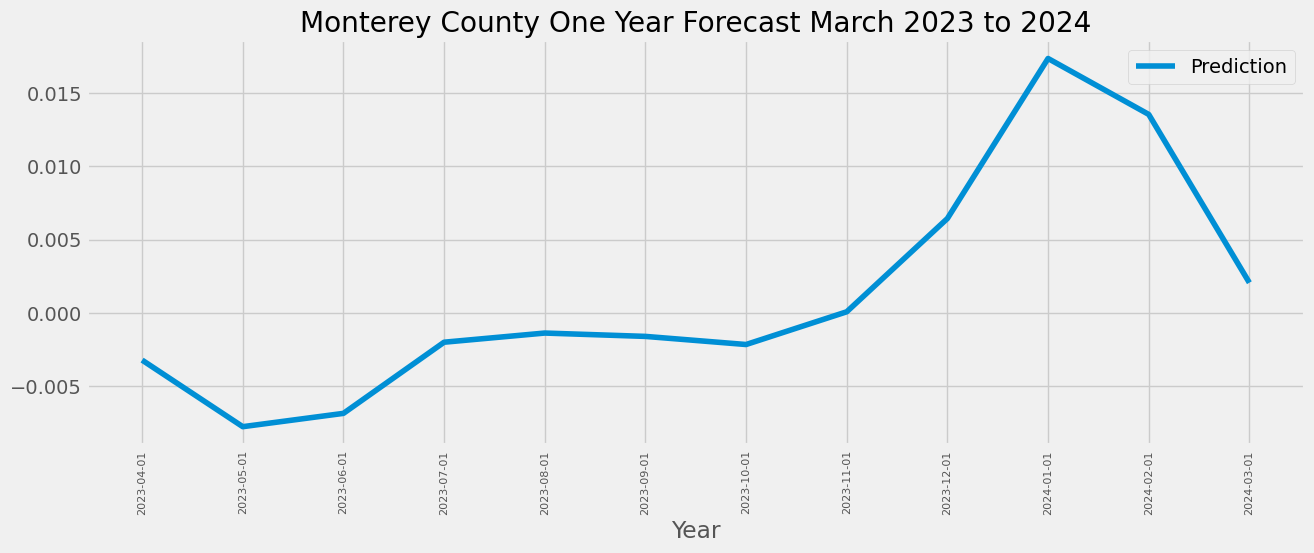

In [271]:
# plot the final prediction of our Monterey model
fig, ax = plt.subplots(figsize = (14,5))
plt.xticks(fontsize = 8, rotation = 90)
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax), 1))

ax.plot(tp, label = "Prediction")

ax.set_title('Monterey County One Year Forecast March 2023 to 2024')
ax.set_xlabel('Year')
ax.set_xticks(range(0, len(tp), 1))
ax.legend();

## Monterey County Educational Program

Monterey County looks to have a smaller window of unemployment as suggested by our machine learning model. We can suggest an educational program spanning from September to March.

# RNN: Kern County

In [272]:
# Kern county index to datetime
Kern.index = pd.to_datetime(Kern.index)

In [273]:
# sort_index based on datetime indexes
Kern = Kern.sort_index()

In [274]:
# drop all columns except for 'Unemployment Rate'
Kern = Kern.drop(['Area Name',
                  'Labor Force',
                  'Employment',
                  'Unemployment'], axis =1)

In [275]:
# Let's use the original train/test split, it seems from our first two counties that results may vary
cutoff = round(Kern.shape[0] *.75)
cutoff

train = Kern[:cutoff]
test = Kern[cutoff:]

In [276]:
# fit scaler onto training data and transform train/test split
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [277]:
# n_input sets the length of our generator
n_input = 12
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length = n_input,
                                batch_size = 1)

In [278]:
model = Sequential()
model.add(LSTM(100, activation='linear', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [279]:
# fit model onto generator, 50 epochs
model.fit(generator, epochs=50)

Epoch 1/50
286/286 [==============================] - 4s 10ms/step - loss: 0.0242
Epoch 2/50
286/286 [==============================] - 4s 12ms/step - loss: 0.0172
Epoch 3/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0124
Epoch 4/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0100
Epoch 5/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0081
Epoch 6/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0082
Epoch 7/50
286/286 [==============================] - 3s 11ms/step - loss: 0.0072
Epoch 8/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0067
Epoch 9/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0071
Epoch 10/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0070
Epoch 11/50
286/286 [==============================] - 3s 10ms/step - loss: 0.0073
Epoch 12/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0068
Epoch 13/50
286/286 [

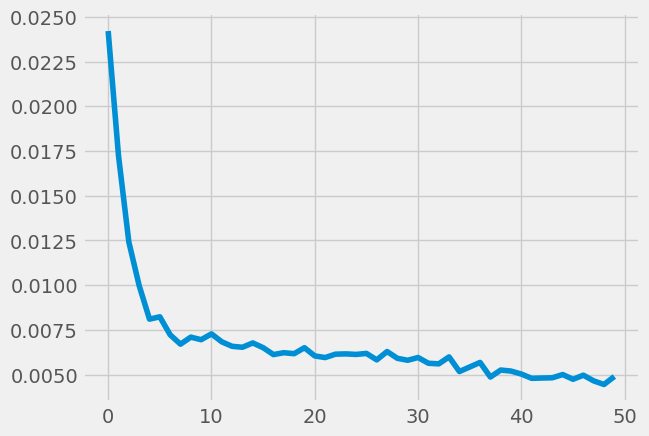

In [280]:
# plot loss_per_epoch
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

In [281]:
# sets variable to final 12 values in scaled train
last_train_batch = scaled_train[-12:]

In [282]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [283]:
# prediction of our first value in the test set
model.predict(last_train_batch)

1/1 [==============================] - 0s 198ms/step


array([[0.22771418]], dtype=float32)

In [284]:
# actual first value in our test set
scaled_test[0]

array([0.25])

In [285]:
# test_predictions is an empty list that will train on previous 12 values and predict
## the next, after that prediction is made the first value of the training data will
### be dropped and the next 12 values will be used to predict the next. This will go
#### for the length of the test dataset, based on RMSE we will determine if this is
##### an accurate model
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

1/1 [==============================] - 0s 50ms/step


In [286]:
test_predictions

[array([0.22771418], dtype=float32),
 array([0.22135031], dtype=float32),
 array([0.23340982], dtype=float32),
 array([0.2715894], dtype=float32),
 array([0.31345016], dtype=float32),
 array([0.32930335], dtype=float32),
 array([0.3184368], dtype=float32),
 array([0.30113155], dtype=float32),
 array([0.28239253], dtype=float32),
 array([0.24404126], dtype=float32),
 array([0.20137426], dtype=float32),
 array([0.17815346], dtype=float32),
 array([0.16555625], dtype=float32),
 array([0.15344507], dtype=float32),
 array([0.14997731], dtype=float32),
 array([0.16192159], dtype=float32),
 array([0.18346657], dtype=float32),
 array([0.20429051], dtype=float32),
 array([0.21756288], dtype=float32),
 array([0.22097541], dtype=float32),
 array([0.2118195], dtype=float32),
 array([0.18728667], dtype=float32),
 array([0.15368588], dtype=float32),
 array([0.12184209], dtype=float32),
 array([0.09448723], dtype=float32),
 array([0.07117075], dtype=float32),
 array([0.05628733], dtype=float32),
 arr

In [287]:
true_predictions = scaler.inverse_transform(test_predictions)

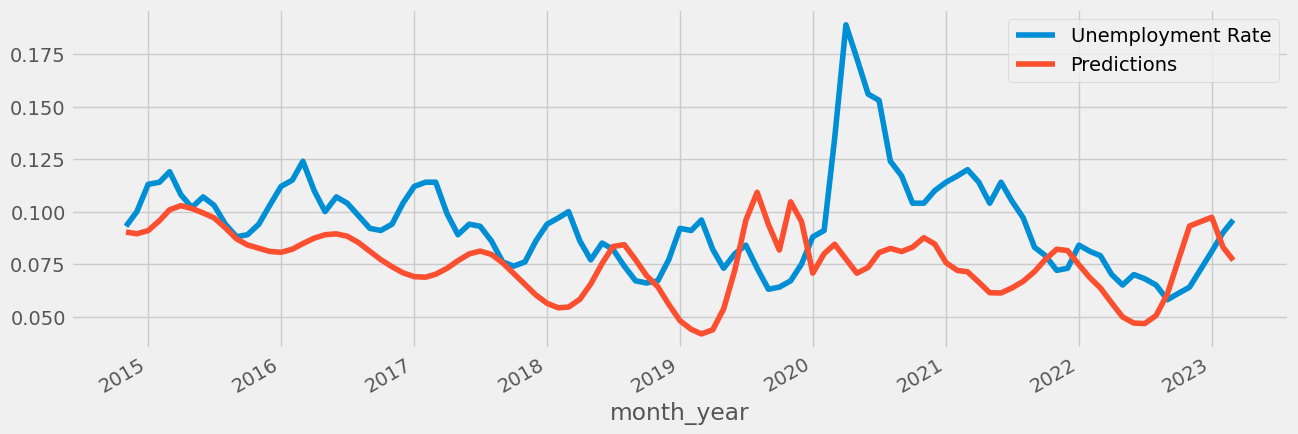

In [288]:
# plot of our test data, actual vs predictions
test['Predictions'] = true_predictions
test.plot(figsize=(14,5));

In [289]:
# print rmse score
rmse = sqrt(mean_squared_error(test['Unemployment Rate'], test['Predictions']))
print(rmse)

0.03148889308406181


Not bad but the predictions look very linear. Let's try stationary data.

## Stationary Data: Kern County

In [290]:
# create stationary data from Kern county dataset
Kern = Kern.diff(periods =1)
Kern = Kern.dropna()

In [291]:
cutoff = round(Kern.shape[0] *0.75)
cutoff

train = Kern[:cutoff]
test = Kern[cutoff: ]


In [292]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [293]:
n_input = 12
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length = n_input,
                                batch_size = 1)

In [294]:
model = Sequential()
model.add(LSTM(100, activation='linear', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [295]:
model.fit(generator, epochs = 50)

Epoch 1/50
286/286 [==============================] - 4s 8ms/step - loss: 0.0405
Epoch 2/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0354
Epoch 3/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0338
Epoch 4/50
286/286 [==============================] - 3s 11ms/step - loss: 0.0331
Epoch 5/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0289
Epoch 6/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0278
Epoch 7/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0226
Epoch 8/50
286/286 [==============================] - 3s 10ms/step - loss: 0.0240
Epoch 9/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0190
Epoch 10/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0266
Epoch 11/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0222
Epoch 12/50
286/286 [==============================] - 3s 11ms/step - loss: 0.0208
Epoch 13/50
286/286 [=

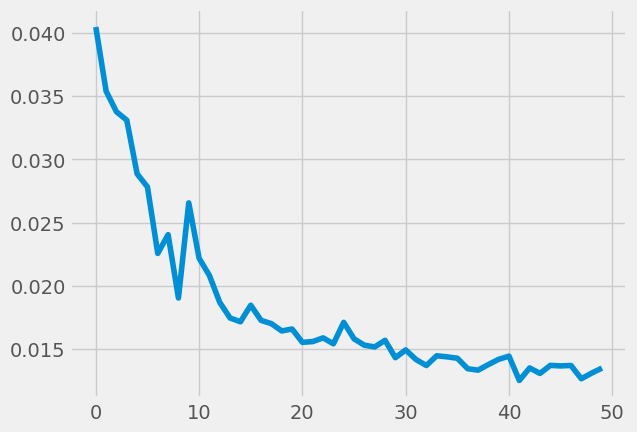

In [296]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

In [297]:
last_train_batch = scaled_train[-12:]

In [298]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [299]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 193ms/step


array([[0.6464792]], dtype=float32)

In [300]:
scaled_test[0]

array([0.6779661])

In [301]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

1/1 [==============================] - 0s 47ms/step


In [302]:
test_predictions

[array([0.6464792], dtype=float32),
 array([0.6595632], dtype=float32),
 array([0.61031127], dtype=float32),
 array([0.60558915], dtype=float32),
 array([0.32193387], dtype=float32),
 array([0.45649472], dtype=float32),
 array([0.6100539], dtype=float32),
 array([0.48472694], dtype=float32),
 array([0.42104244], dtype=float32),
 array([0.46146834], dtype=float32),
 array([0.56326646], dtype=float32),
 array([0.62316227], dtype=float32),
 array([0.626306], dtype=float32),
 array([0.6330903], dtype=float32),
 array([0.6139826], dtype=float32),
 array([0.58158314], dtype=float32),
 array([0.3733492], dtype=float32),
 array([0.49157962], dtype=float32),
 array([0.58912325], dtype=float32),
 array([0.45015237], dtype=float32),
 array([0.42164627], dtype=float32),
 array([0.49070632], dtype=float32),
 array([0.5719417], dtype=float32),
 array([0.6090931], dtype=float32),
 array([0.61343163], dtype=float32),
 array([0.6204681], dtype=float32),
 array([0.61237115], dtype=float32),
 array([0.56

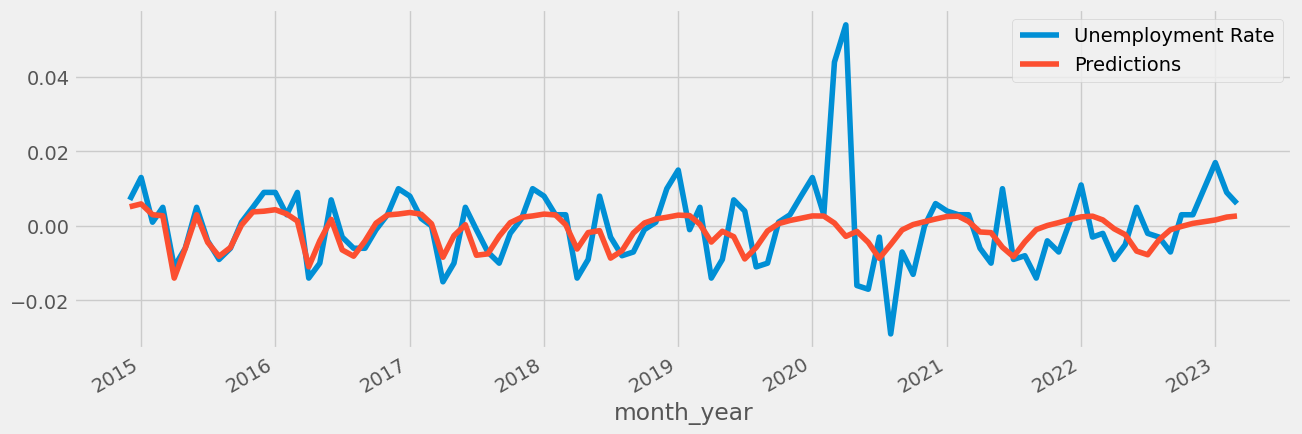

In [303]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(14,5));


In [304]:
rmse = sqrt(mean_squared_error(test['Unemployment Rate'], test['Predictions']))
print(rmse)

0.009765300858328966


Great! Let's try one more improvement before moving on.

## Smaller Test Set: Kern County

In [305]:
index_Kern = Kern.reset_index()

In [306]:
train = Kern[:385]
test = Kern[385:]

In [307]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [308]:
n_input = 12
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length = n_input,
                                batch_size = 1)


In [309]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [310]:
model.fit(generator, epochs = 50)

Epoch 1/50
373/373 [==============================] - 5s 8ms/step - loss: 0.0213
Epoch 2/50
373/373 [==============================] - 4s 10ms/step - loss: 0.0157
Epoch 3/50
373/373 [==============================] - 3s 8ms/step - loss: 0.0147
Epoch 4/50
373/373 [==============================] - 3s 8ms/step - loss: 0.0131
Epoch 5/50
373/373 [==============================] - 4s 9ms/step - loss: 0.0139
Epoch 6/50
373/373 [==============================] - 3s 8ms/step - loss: 0.0129
Epoch 7/50
373/373 [==============================] - 3s 9ms/step - loss: 0.0115
Epoch 8/50
373/373 [==============================] - 4s 11ms/step - loss: 0.0106
Epoch 9/50
373/373 [==============================] - 3s 8ms/step - loss: 0.0097
Epoch 10/50
373/373 [==============================] - 3s 8ms/step - loss: 0.0104
Epoch 11/50
373/373 [==============================] - 3s 8ms/step - loss: 0.0093
Epoch 12/50
373/373 [==============================] - 3s 8ms/step - loss: 0.0083
Epoch 13/50
373/373 [==

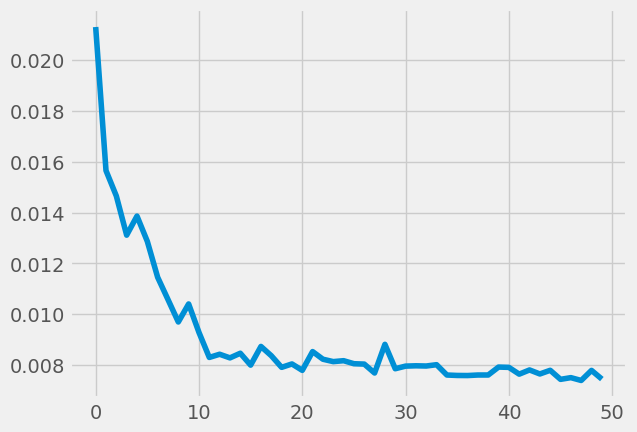

In [311]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

In [312]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

1/1 [==============================] - 0s 35ms/step


In [313]:
test_predictions

[array([0.3967504], dtype=float32),
 array([0.31386048], dtype=float32),
 array([0.29080826], dtype=float32),
 array([0.45319143], dtype=float32),
 array([0.29524457], dtype=float32),
 array([0.28974015], dtype=float32),
 array([0.25212556], dtype=float32),
 array([0.32263672], dtype=float32),
 array([0.30737352], dtype=float32),
 array([0.3817486], dtype=float32),
 array([0.46317142], dtype=float32),
 array([0.35111713], dtype=float32)]

In [314]:
true_predictions = scaler.inverse_transform(test_predictions)

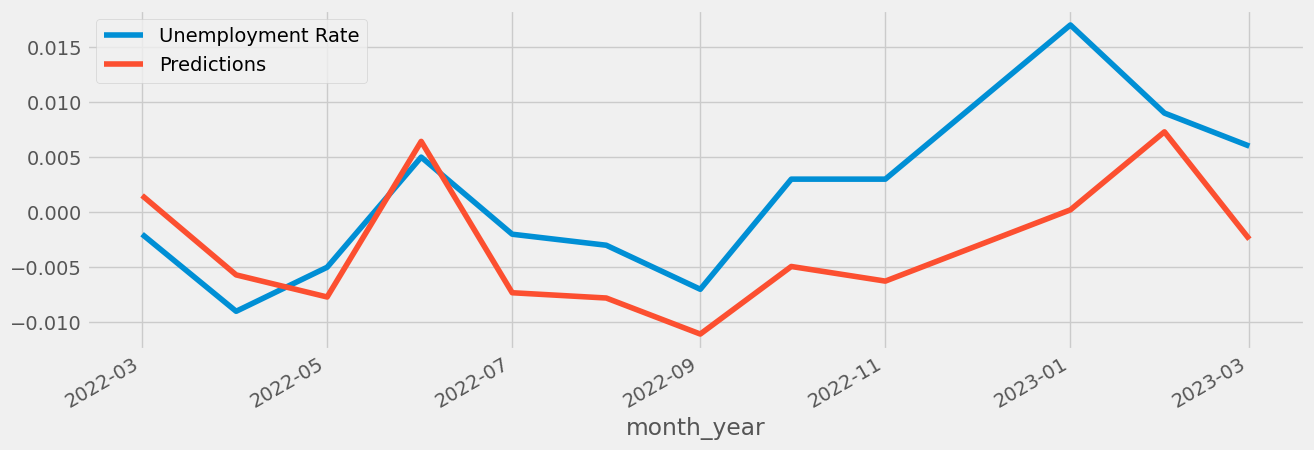

In [315]:
test['Predictions'] = true_predictions
test.plot(figsize=(14,5));

In [316]:
rmse = sqrt(mean_squared_error(test['Unemployment Rate'], test['Predictions']))
print(rmse)

0.007101390765799998


## Kern County Predictions 2023 to 2024

In [317]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(new_list)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

1/1 [==============================] - 0s 33ms/step


In [318]:
test_predictions

[array([0.3967504], dtype=float32),
 array([0.31386048], dtype=float32),
 array([0.29080826], dtype=float32),
 array([0.45319143], dtype=float32),
 array([0.29524457], dtype=float32),
 array([0.28974015], dtype=float32),
 array([0.25212556], dtype=float32),
 array([0.32263672], dtype=float32),
 array([0.30737352], dtype=float32),
 array([0.3817486], dtype=float32),
 array([0.46317142], dtype=float32),
 array([0.35111713], dtype=float32),
 array([0.38295227], dtype=float32),
 array([0.31642672], dtype=float32),
 array([0.30518603], dtype=float32),
 array([0.42758512], dtype=float32),
 array([0.3060409], dtype=float32),
 array([0.29391965], dtype=float32),
 array([0.2728129], dtype=float32),
 array([0.3164283], dtype=float32),
 array([0.3120193], dtype=float32),
 array([0.37327808], dtype=float32),
 array([0.43953633], dtype=float32),
 array([0.3538822], dtype=float32),
 array([0.37177193], dtype=float32)]

In [319]:
test_predictions = pd.DataFrame(test_predictions)

In [320]:
test_predictions

0
0   0.396750
1   0.313860
2   0.290808
3   0.453191
4   0.295245
5   0.289740
6   0.252126
7   0.322637
8   0.307374
9   0.381749
10  0.463171
11  0.351117
12  0.382952
13  0.316427
14  0.305186
15  0.427585
16  0.306041
17  0.293920
18  0.272813
19  0.316428
20  0.312019
21  0.373278
22  0.439536
23  0.353882
24  0.371772

In [321]:
test_predictions['Year'] = new_list

In [322]:
test_predictions = test_predictions.rename(columns = map)

In [323]:
test_predictions = test_predictions.set_index(['Year'])

In [324]:
true_predictions = scaler.inverse_transform(test_predictions)

In [325]:
test_predictions['Predictions'] = true_predictions

In [326]:
tp = test_predictions.iloc[-12:]

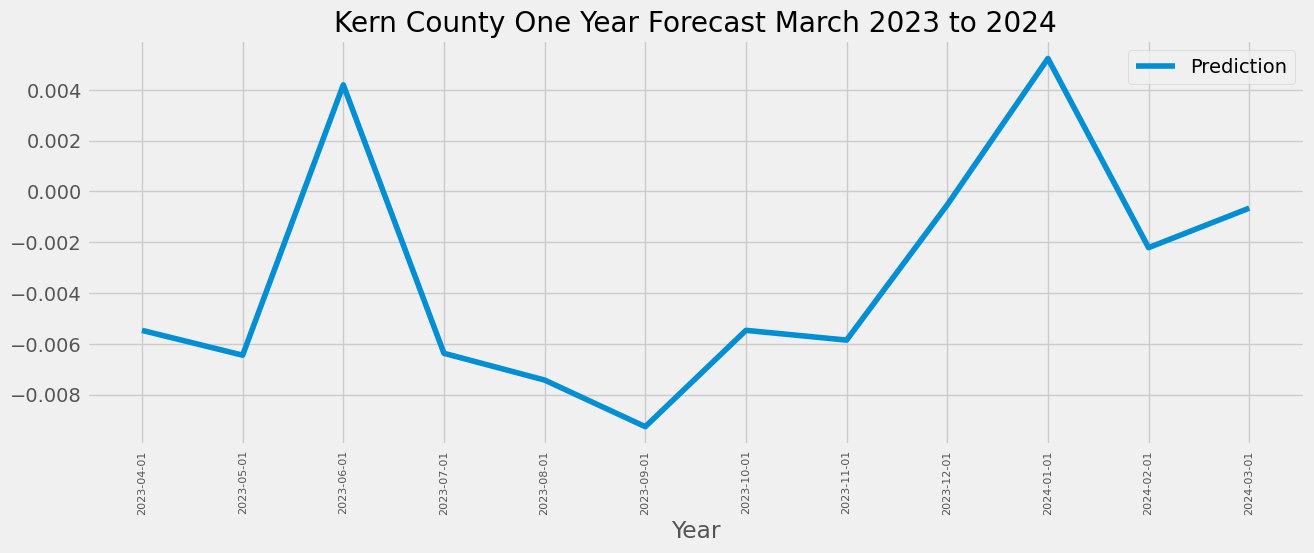

In [327]:
fig, ax = plt.subplots(figsize = (14,5))
plt.xticks(fontsize = 8, rotation = 90)
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax), 1))

ax.plot(tp, label = "Prediction")

ax.set_title('Kern County One Year Forecast March 2023 to 2024')
ax.set_xlabel('Year')
ax.set_xticks(range(0, len(tp), 1))
ax.legend();

## Kern County Educational Program

According to our machine learning model, the highest rates of unemployment happen in peaks during a two month period between May to July, and again beginning in November to March, totalling 6 months.

# RNN: Tulare County

In [328]:
Tulare.index = pd.to_datetime(Tulare.index)

In [329]:
Tulare = Tulare.sort_index()

In [330]:
Tulare = Tulare.drop(['Area Name',
                      'Labor Force',
                      'Employment',
                      'Unemployment'], axis =1)

In [331]:
cutoff = round(Tulare.shape[0] * 0.75)
cutoff

train = Tulare[:cutoff]
test = Tulare[cutoff:]

In [332]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [333]:
n_input = 12
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length = n_input,
                                batch_size = 1)

In [334]:
model = Sequential()
model.add(LSTM(100, activation='linear', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [335]:
model.fit(generator, epochs=50)

Epoch 1/50
286/286 [==============================] - 4s 8ms/step - loss: 0.0178
Epoch 2/50
286/286 [==============================] - 2s 9ms/step - loss: 0.0133
Epoch 3/50
286/286 [==============================] - 3s 10ms/step - loss: 0.0100
Epoch 4/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0078
Epoch 5/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0079
Epoch 6/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0071
Epoch 7/50
286/286 [==============================] - 3s 10ms/step - loss: 0.0064
Epoch 8/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0064
Epoch 9/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0066
Epoch 10/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0061
Epoch 11/50
286/286 [==============================] - 3s 10ms/step - loss: 0.0059
Epoch 12/50
286/286 [==============================] - 2s 7ms/step - loss: 0.0058
Epoch 13/50
286/286 [=

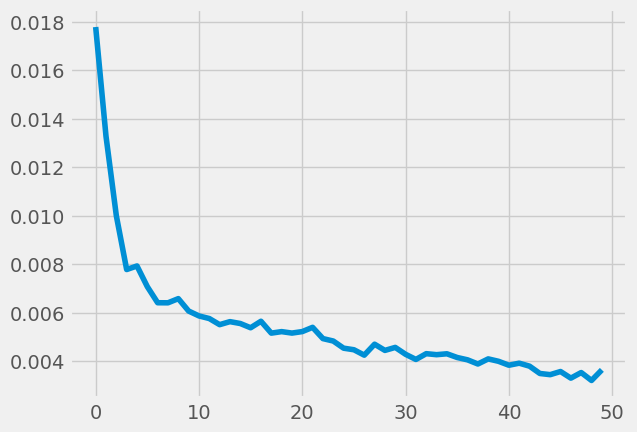

In [336]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

In [337]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

1/1 [==============================] - 0s 73ms/step


In [338]:
test_predictions

[array([0.28671235], dtype=float32),
 array([0.2522877], dtype=float32),
 array([0.22452039], dtype=float32),
 array([0.20673883], dtype=float32),
 array([0.1874429], dtype=float32),
 array([0.16106908], dtype=float32),
 array([0.12935844], dtype=float32),
 array([0.10074219], dtype=float32),
 array([0.07751498], dtype=float32),
 array([0.05453528], dtype=float32),
 array([0.02571297], dtype=float32),
 array([-0.00613094], dtype=float32),
 array([-0.03586595], dtype=float32),
 array([-0.06418476], dtype=float32),
 array([-0.09559083], dtype=float32),
 array([-0.13125567], dtype=float32),
 array([-0.16762714], dtype=float32),
 array([-0.20147504], dtype=float32),
 array([-0.23370697], dtype=float32),
 array([-0.2678243], dtype=float32),
 array([-0.3035407], dtype=float32),
 array([-0.33611727], dtype=float32),
 array([-0.36329722], dtype=float32),
 array([-0.38920206], dtype=float32),
 array([-0.41671395], dtype=float32),
 array([-0.4411276], dtype=float32),
 array([-0.45843643], dtype=

In [339]:
true_predictions = scaler.inverse_transform(test_predictions)

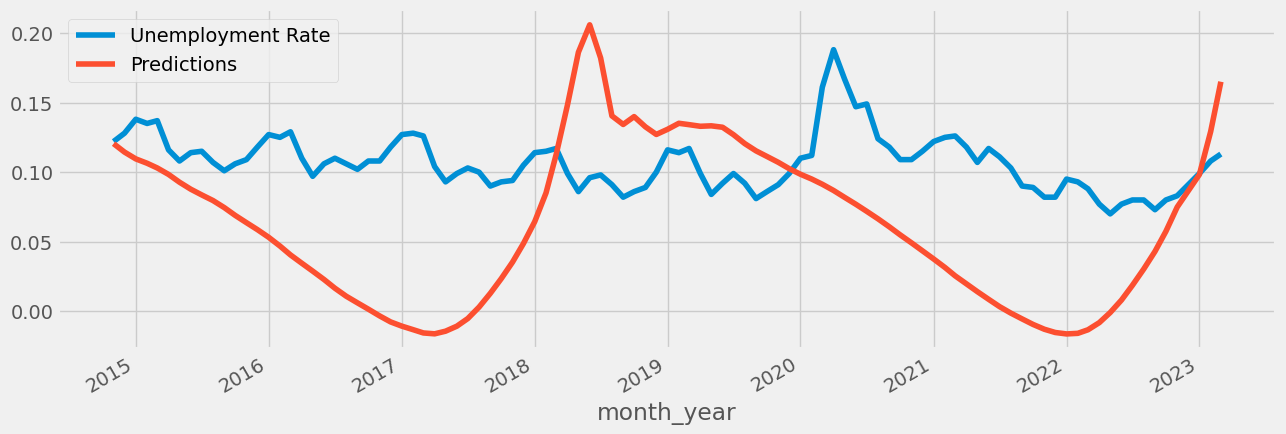

In [340]:
test['Predictions'] = true_predictions
test.plot(figsize=(14,5));

In [341]:
rmse = sqrt(mean_squared_error(test['Unemployment Rate'], test['Predictions']))
print(rmse)

0.07332566485727103


## Stationary Data: Tulare County

In [342]:
Tulare = Tulare.diff(periods =1)
Tulare = Tulare.dropna()

In [343]:
cutoff = round(county.shape[0] *0.75)
cutoff

train = county[:cutoff]
test = county[cutoff: ]


In [344]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [345]:
n_input = 12
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length = n_input,
                                batch_size = 1)

In [346]:
model = Sequential()
model.add(LSTM(100, activation='linear', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [347]:
model.fit(generator, epochs = 50)

Epoch 1/50
286/286 [==============================] - 7s 15ms/step - loss: 0.0477
Epoch 2/50
286/286 [==============================] - 3s 12ms/step - loss: 0.0194
Epoch 3/50
286/286 [==============================] - 3s 12ms/step - loss: 0.0128
Epoch 4/50
286/286 [==============================] - 4s 14ms/step - loss: 0.0109
Epoch 5/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0113
Epoch 6/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0125
Epoch 7/50
286/286 [==============================] - 4s 14ms/step - loss: 0.0103
Epoch 8/50
286/286 [==============================] - 3s 10ms/step - loss: 0.0104
Epoch 9/50
286/286 [==============================] - 3s 9ms/step - loss: 0.0099
Epoch 10/50
286/286 [==============================] - 5s 18ms/step - loss: 0.0105
Epoch 11/50
286/286 [==============================] - 3s 10ms/step - loss: 0.0099
Epoch 12/50
286/286 [==============================] - 3s 9ms/step - loss: 0.0095
Epoch 13/50
286/2

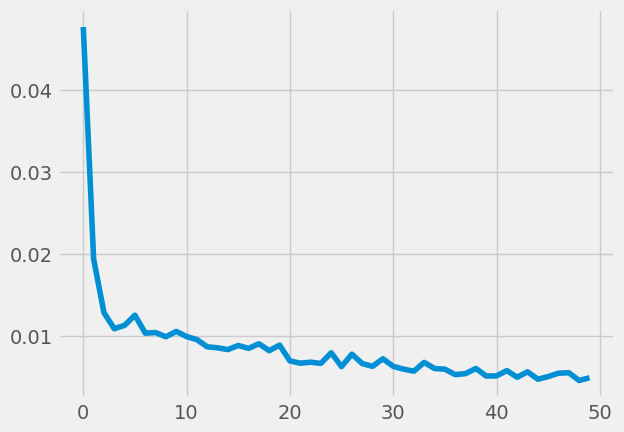

In [348]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);


In [349]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

1/1 [==============================] - 0s 35ms/step


In [350]:
test_predictions

[array([0.7662062], dtype=float32),
 array([0.623617], dtype=float32),
 array([0.45579484], dtype=float32),
 array([0.31516546], dtype=float32),
 array([0.15910853], dtype=float32),
 array([0.34217426], dtype=float32),
 array([0.48396713], dtype=float32),
 array([0.4443085], dtype=float32),
 array([0.40304407], dtype=float32),
 array([0.38011563], dtype=float32),
 array([0.4850222], dtype=float32),
 array([0.73060316], dtype=float32),
 array([0.8080266], dtype=float32),
 array([0.63262093], dtype=float32),
 array([0.45556343], dtype=float32),
 array([0.279482], dtype=float32),
 array([0.14937747], dtype=float32),
 array([0.3473806], dtype=float32),
 array([0.48700985], dtype=float32),
 array([0.40899274], dtype=float32),
 array([0.37413573], dtype=float32),
 array([0.34275156], dtype=float32),
 array([0.47824413], dtype=float32),
 array([0.794959], dtype=float32),
 array([0.8456901], dtype=float32),
 array([0.64920664], dtype=float32),
 array([0.46785712], dtype=float32),
 array([0.275

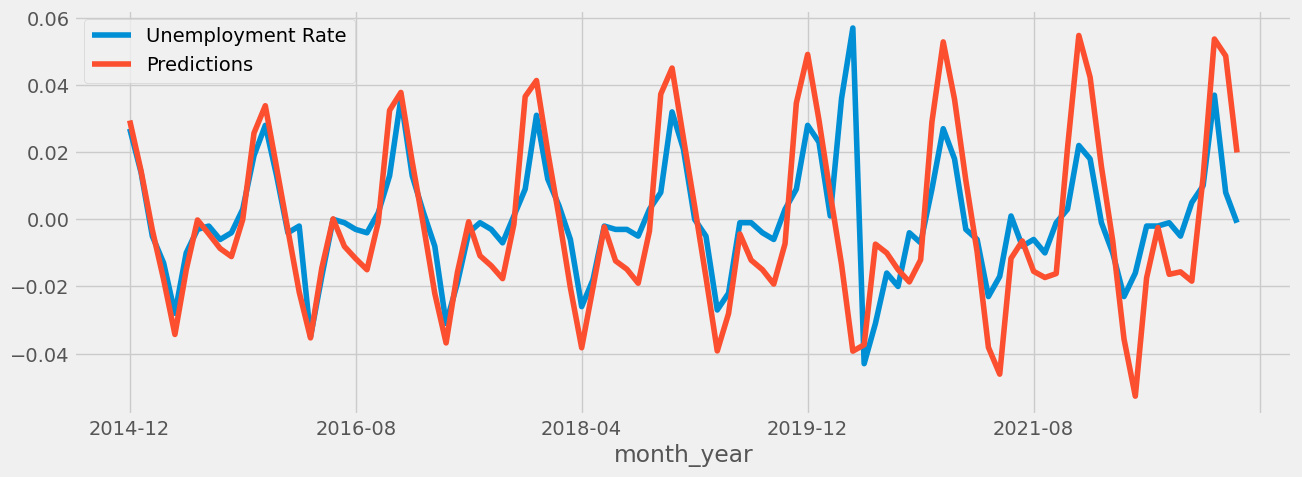

In [351]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(14,5));

In [352]:
rmse = sqrt(mean_squared_error(test['Unemployment Rate'], test['Predictions']))
print(rmse)

0.01739296860772474


Better or worse?

## Smaller Test Set: Tulare County

In [353]:
index_show = Kern.reset_index()

In [354]:
train = Kern[:384]
test = Kern[384:]

In [355]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [356]:
n_input = 12
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length = n_input,
                                batch_size = 1)

In [357]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [358]:
model.fit(generator, epochs = 50)

Epoch 1/50
372/372 [==============================] - 5s 10ms/step - loss: 0.0220
Epoch 2/50
372/372 [==============================] - 3s 8ms/step - loss: 0.0156
Epoch 3/50
372/372 [==============================] - 3s 8ms/step - loss: 0.0145
Epoch 4/50
372/372 [==============================] - 4s 10ms/step - loss: 0.0136
Epoch 5/50
372/372 [==============================] - 3s 8ms/step - loss: 0.0131
Epoch 6/50
372/372 [==============================] - 3s 8ms/step - loss: 0.0118
Epoch 7/50
372/372 [==============================] - 3s 9ms/step - loss: 0.0116
Epoch 8/50
372/372 [==============================] - 3s 7ms/step - loss: 0.0103
Epoch 9/50
372/372 [==============================] - 3s 8ms/step - loss: 0.0094
Epoch 10/50
372/372 [==============================] - 3s 9ms/step - loss: 0.0097
Epoch 11/50
372/372 [==============================] - 4s 10ms/step - loss: 0.0089
Epoch 12/50
372/372 [==============================] - 3s 8ms/step - loss: 0.0081
Epoch 13/50
372/372 [=

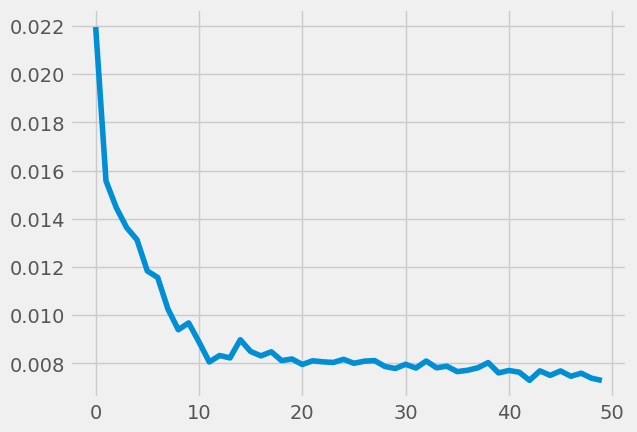

In [359]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

In [360]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

1/1 [==============================] - 0s 35ms/step


In [361]:
test_predictions

[array([0.40873975], dtype=float32),
 array([0.4042312], dtype=float32),
 array([0.3265521], dtype=float32),
 array([0.2925763], dtype=float32),
 array([0.45096666], dtype=float32),
 array([0.31022996], dtype=float32),
 array([0.29838407], dtype=float32),
 array([0.27311677], dtype=float32),
 array([0.32559103], dtype=float32),
 array([0.32117337], dtype=float32),
 array([0.3735765], dtype=float32),
 array([0.46574318], dtype=float32),
 array([0.40108097], dtype=float32)]

In [362]:
true_predictions = scaler.inverse_transform(test_predictions)

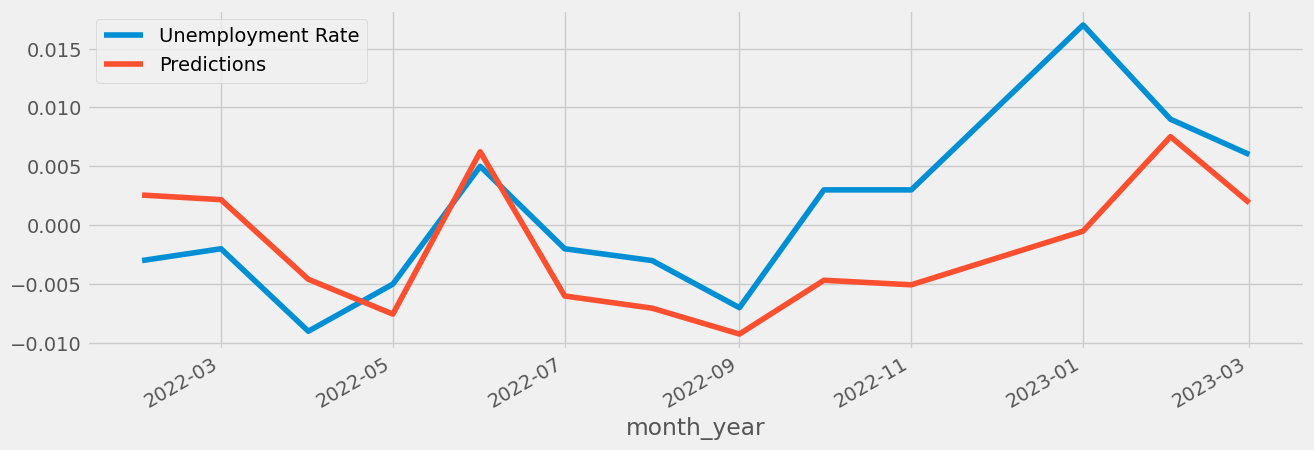

In [363]:
test['Predictions'] = true_predictions
test.plot(figsize=(14,5));

In [364]:
rmse = sqrt(mean_squared_error(test['Unemployment Rate'], test['Predictions']))
print(rmse)

0.006576391753178382


Okay, great! Let's make predictions on this model.

## Predictions 2023 to 2024: San Joaquin County

In [365]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(new_list)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

1/1 [==============================] - 0s 51ms/step


In [366]:
# recall test_predictions to make sure that they match the most recent in our notebook
test_predictions

[array([0.40873975], dtype=float32),
 array([0.4042312], dtype=float32),
 array([0.3265521], dtype=float32),
 array([0.2925763], dtype=float32),
 array([0.45096666], dtype=float32),
 array([0.31022996], dtype=float32),
 array([0.29838407], dtype=float32),
 array([0.27311677], dtype=float32),
 array([0.32559103], dtype=float32),
 array([0.32117337], dtype=float32),
 array([0.3735765], dtype=float32),
 array([0.46574318], dtype=float32),
 array([0.40108097], dtype=float32),
 array([0.3940094], dtype=float32),
 array([0.33433485], dtype=float32),
 array([0.30753303], dtype=float32),
 array([0.42746437], dtype=float32),
 array([0.32829228], dtype=float32),
 array([0.307276], dtype=float32),
 array([0.29937458], dtype=float32),
 array([0.32505432], dtype=float32),
 array([0.32988533], dtype=float32),
 array([0.3624533], dtype=float32),
 array([0.44575137], dtype=float32),
 array([0.39298272], dtype=float32)]

In [367]:
test_predictions = pd.DataFrame(test_predictions)

In [368]:
new_list

['2022-02-01',
 '2022-03-01',
 '2022-04-01',
 '2022-05-01',
 '2022-06-01',
 '2022-07-01',
 '2022-08-01',
 '2022-09-01',
 '2022-10-01',
 '2022-11-01',
 '2023-01-01',
 '2023-02-01',
 '2023-03-01',
 '2023-04-01',
 '2023-05-01',
 '2023-06-01',
 '2023-07-01',
 '2023-08-01',
 '2023-09-01',
 '2023-10-01',
 '2023-11-01',
 '2023-12-01',
 '2024-01-01',
 '2024-02-01',
 '2024-03-01']

In [369]:
test_predictions['Year'] = new_list

In [370]:
test_predictions = test_predictions.rename(columns = map)

In [371]:
test_predictions = test_predictions.set_index(['Year'])

In [372]:
true_predictions = scaler.inverse_transform(test_predictions)

In [373]:
test_predictions['Predictions'] = true_predictions

In [374]:
tp = test_predictions.iloc[-12:]

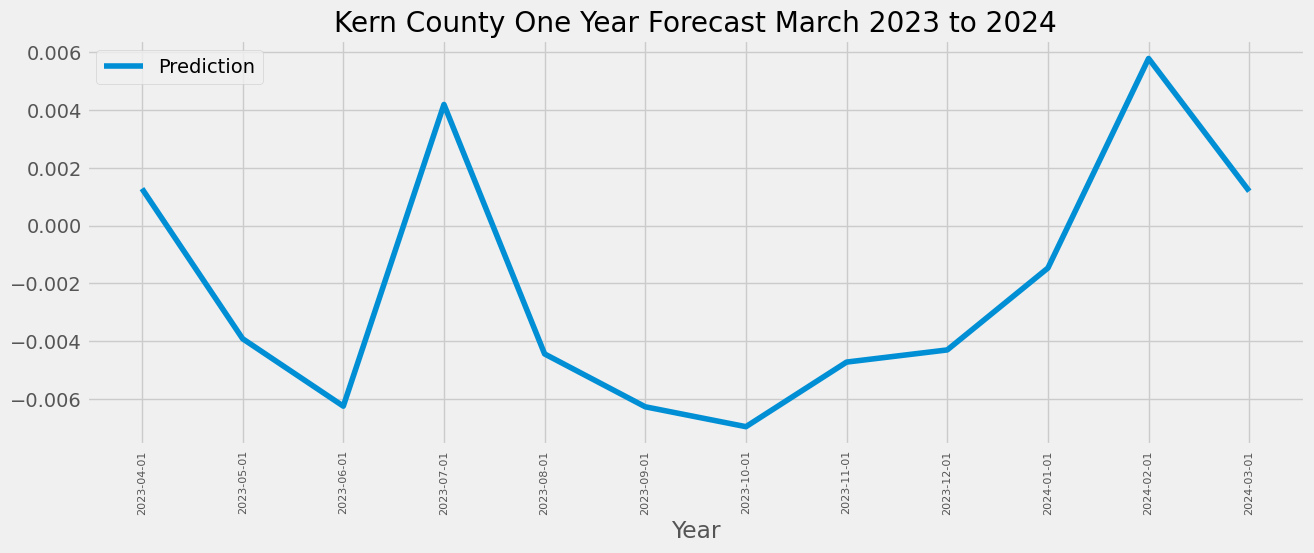

In [375]:
fig, ax = plt.subplots(figsize = (14,5))
plt.xticks(fontsize = 8, rotation = 90)
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax), 1))

ax.plot(tp, label = "Prediction")

ax.set_title('Kern County One Year Forecast March 2023 to 2024')
ax.set_xlabel('Year')
ax.set_xticks(range(0, len(tp), 1))
ax.legend();

## Tulare County Educational Program

Based on our machine learning model a proposed 6 month program could be broken up from April to May, June to August, and December to March.

# RNN: San Joaquin County

In [377]:
San_Joaquin.index = pd.to_datetime(San_Joaquin.index)

In [378]:
SJ = San_Joaquin.sort_index()

In [379]:
SJ = SJ.drop(['Area Name',
              'Labor Force',
              'Employment',
              'Unemployment'], axis =1)

In [380]:
cutoff = round(SJ.shape[0] * .75)
cutoff

train = SJ[:cutoff]
test = SJ[cutoff:]

In [381]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [382]:
n_input = 12
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length = n_input,
                                batch_size = 1)

In [383]:
model = Sequential()
model.add(LSTM(100, activation='linear', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [384]:
model.fit(generator, epochs=50)

Epoch 1/50
286/286 [==============================] - 8s 14ms/step - loss: 0.0242
Epoch 2/50
286/286 [==============================] - 4s 15ms/step - loss: 0.0148
Epoch 3/50
286/286 [==============================] - 4s 13ms/step - loss: 0.0111
Epoch 4/50
286/286 [==============================] - 3s 12ms/step - loss: 0.0090
Epoch 5/50
286/286 [==============================] - 4s 15ms/step - loss: 0.0072
Epoch 6/50
286/286 [==============================] - 4s 12ms/step - loss: 0.0059
Epoch 7/50
286/286 [==============================] - 3s 12ms/step - loss: 0.0056
Epoch 8/50
286/286 [==============================] - 5s 17ms/step - loss: 0.0052
Epoch 9/50
286/286 [==============================] - 4s 13ms/step - loss: 0.0049
Epoch 10/50
286/286 [==============================] - 4s 13ms/step - loss: 0.0047
Epoch 11/50
286/286 [==============================] - 3s 10ms/step - loss: 0.0048
Epoch 12/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0047
Epoch 13/50
28

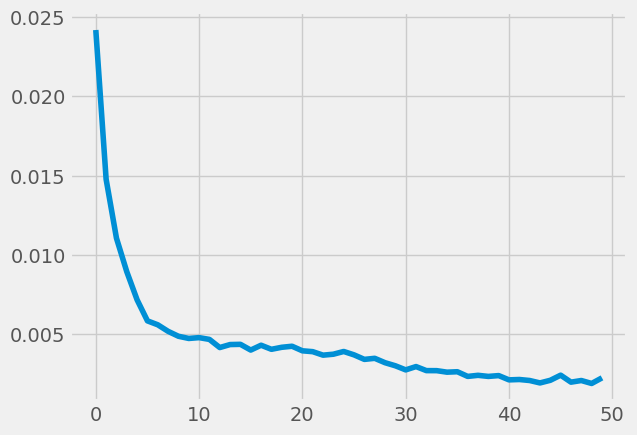

In [385]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

In [386]:
last_train_batch = scaled_train[-12:]

In [387]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [388]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 337ms/step


array([[0.34073156]], dtype=float32)

In [389]:
scaled_test[0]

array([0.34883721])

In [390]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

1/1 [==============================] - 0s 116ms/step


In [391]:
test_predictions

[array([0.34073156], dtype=float32),
 array([0.36169517], dtype=float32),
 array([0.35480994], dtype=float32),
 array([0.3424028], dtype=float32),
 array([0.3334272], dtype=float32),
 array([0.32787547], dtype=float32),
 array([0.32149872], dtype=float32),
 array([0.3099368], dtype=float32),
 array([0.294101], dtype=float32),
 array([0.28200868], dtype=float32),
 array([0.27663937], dtype=float32),
 array([0.27445334], dtype=float32),
 array([0.27161035], dtype=float32),
 array([0.26798642], dtype=float32),
 array([0.26512444], dtype=float32),
 array([0.2627974], dtype=float32),
 array([0.2596044], dtype=float32),
 array([0.25472412], dtype=float32),
 array([0.24860574], dtype=float32),
 array([0.24234566], dtype=float32),
 array([0.23666948], dtype=float32),
 array([0.23158756], dtype=float32),
 array([0.2268777], dtype=float32),
 array([0.2225589], dtype=float32),
 array([0.21881197], dtype=float32),
 array([0.21562015], dtype=float32),
 array([0.21268924], dtype=float32),
 array([0.

In [392]:
true_predictions = scaler.inverse_transform(test_predictions)

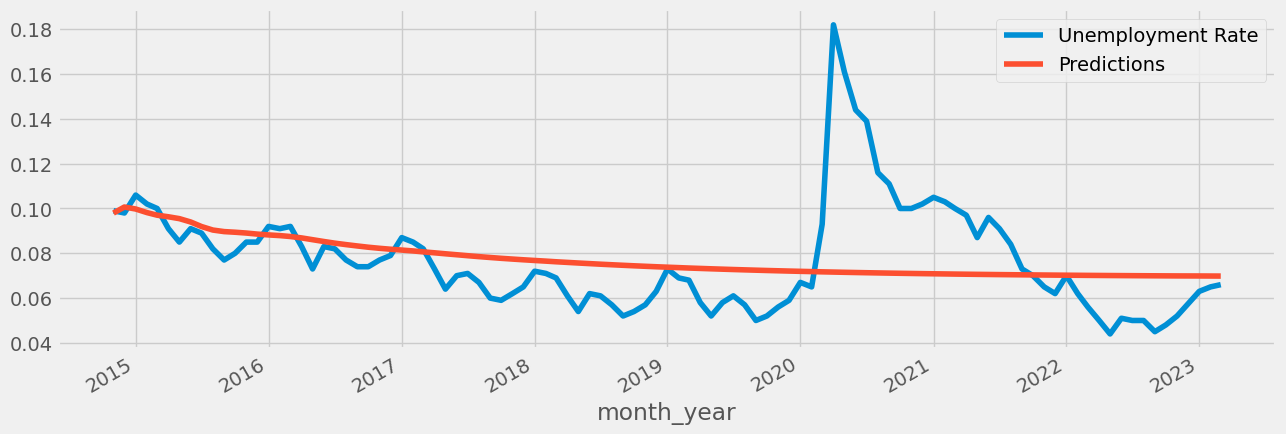

In [393]:
test['Predictions'] = true_predictions
test.plot(figsize=(14,5));

In [394]:
rmse = sqrt(mean_squared_error(test['Unemployment Rate'], test['Predictions']))
print(rmse)

0.023342006951868614


## Stationary Data: San Joaquin County

In [395]:
SJ = SJ.diff(periods = 1)
SJ = SJ.dropna()

In [396]:
cutoff = round(county.shape[0] *0.75)
cutoff

train = county[:cutoff]
test = county[cutoff: ]

In [397]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [398]:
n_input = 12
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length = n_input,
                                batch_size = 1)

In [399]:
model = Sequential()
model.add(LSTM(100, activation='linear', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [400]:
model.fit(generator, epochs = 50)

Epoch 1/50
286/286 [==============================] - 6s 11ms/step - loss: 0.0472
Epoch 2/50
286/286 [==============================] - 2s 7ms/step - loss: 0.0270
Epoch 3/50
286/286 [==============================] - 3s 9ms/step - loss: 0.0159
Epoch 4/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0126
Epoch 5/50
286/286 [==============================] - 2s 7ms/step - loss: 0.0106
Epoch 6/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0120
Epoch 7/50
286/286 [==============================] - 3s 9ms/step - loss: 0.0123
Epoch 8/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0103
Epoch 9/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0098
Epoch 10/50
286/286 [==============================] - 2s 8ms/step - loss: 0.0094
Epoch 11/50
286/286 [==============================] - 3s 10ms/step - loss: 0.0095
Epoch 12/50
286/286 [==============================] - 4s 13ms/step - loss: 0.0094
Epoch 13/50
286/286 [=

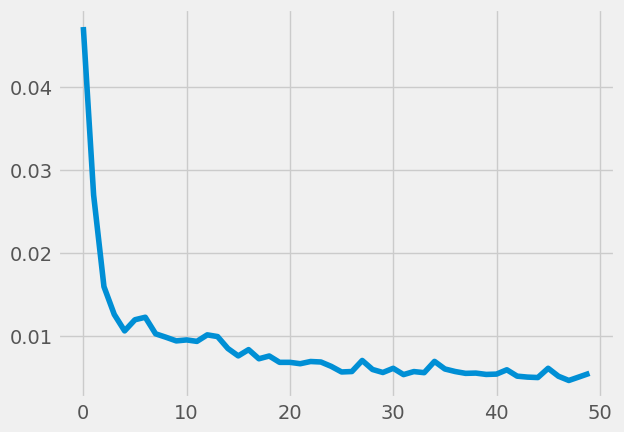

In [401]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

In [402]:
last_train_batch = scaled_train[-12:]

In [403]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [404]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 228ms/step


array([[0.7258301]], dtype=float32)

In [405]:
scaled_test[0]

array([0.74285714])

In [406]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

1/1 [==============================] - 0s 33ms/step


In [407]:
test_predictions

[array([0.7258301], dtype=float32),
 array([0.62555385], dtype=float32),
 array([0.470177], dtype=float32),
 array([0.34953865], dtype=float32),
 array([0.22769487], dtype=float32),
 array([0.3634801], dtype=float32),
 array([0.47318226], dtype=float32),
 array([0.45559102], dtype=float32),
 array([0.44636905], dtype=float32),
 array([0.4623531], dtype=float32),
 array([0.52455527], dtype=float32),
 array([0.64810973], dtype=float32),
 array([0.71165043], dtype=float32),
 array([0.6180312], dtype=float32),
 array([0.46183383], dtype=float32),
 array([0.3311363], dtype=float32),
 array([0.2645575], dtype=float32),
 array([0.37966502], dtype=float32),
 array([0.4681788], dtype=float32),
 array([0.4509108], dtype=float32),
 array([0.45154575], dtype=float32),
 array([0.46945494], dtype=float32),
 array([0.53216094], dtype=float32),
 array([0.64504576], dtype=float32),
 array([0.6979223], dtype=float32),
 array([0.60432994], dtype=float32),
 array([0.4523806], dtype=float32),
 array([0.328

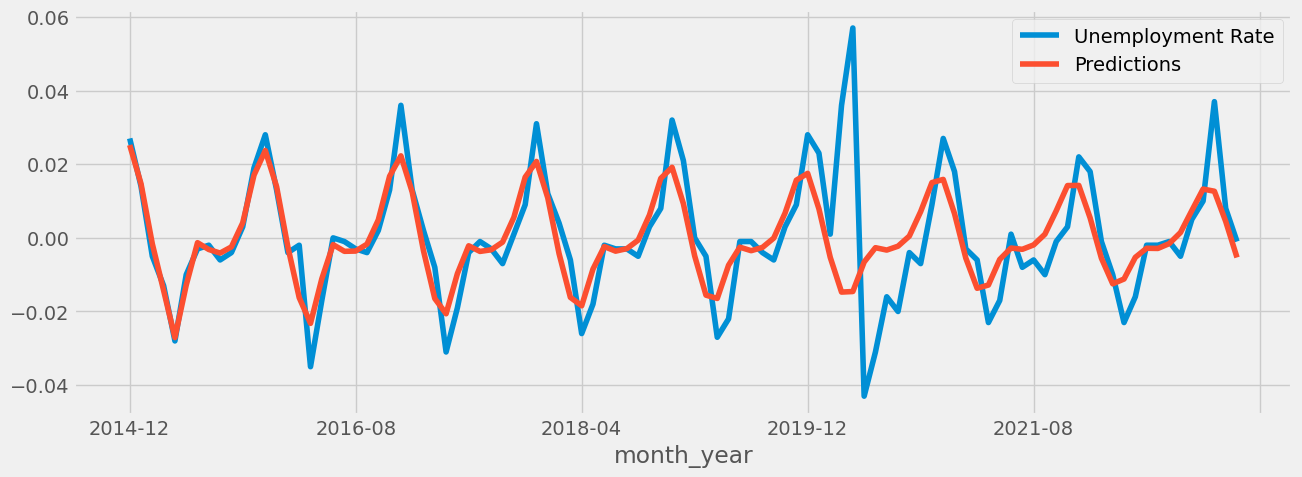

In [408]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(14,5));

In [409]:
rmse = sqrt(mean_squared_error(test['Unemployment Rate'], test['Predictions']))
print(rmse)

0.012514818171123085


## Smaller Test Set: San Joaquin County

In [410]:
SJ_index = SJ.reset_index()

In [411]:
train = county[:384]
test = county[384:]

In [412]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [413]:
n_input = 12
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length = n_input,
                                batch_size = 1)

In [414]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [415]:
model.fit(generator, epochs = 50)

Epoch 1/50
372/372 [==============================] - 5s 8ms/step - loss: 0.0347
Epoch 2/50
372/372 [==============================] - 3s 9ms/step - loss: 0.0188
Epoch 3/50
372/372 [==============================] - 4s 10ms/step - loss: 0.0156
Epoch 4/50
372/372 [==============================] - 3s 8ms/step - loss: 0.0136
Epoch 5/50
372/372 [==============================] - 4s 10ms/step - loss: 0.0106
Epoch 6/50
372/372 [==============================] - 3s 8ms/step - loss: 0.0095
Epoch 7/50
372/372 [==============================] - 3s 8ms/step - loss: 0.0109
Epoch 8/50
372/372 [==============================] - 4s 10ms/step - loss: 0.0090
Epoch 9/50
372/372 [==============================] - 3s 8ms/step - loss: 0.0093
Epoch 10/50
372/372 [==============================] - 3s 8ms/step - loss: 0.0085
Epoch 11/50
372/372 [==============================] - 3s 9ms/step - loss: 0.0085
Epoch 12/50
372/372 [==============================] - 3s 8ms/step - loss: 0.0089
Epoch 13/50
372/372 [=

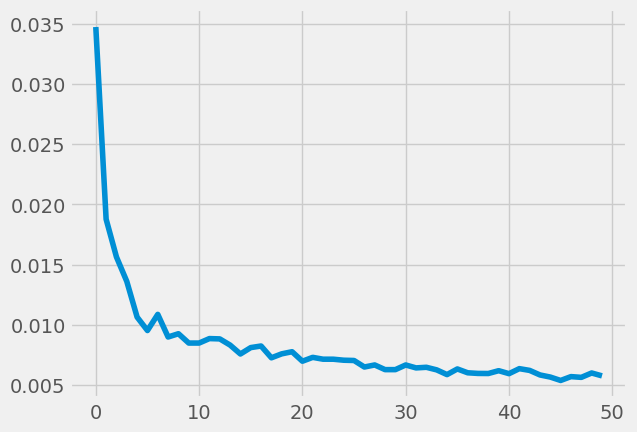

In [416]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

In [417]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

1/1 [==============================] - 0s 49ms/step


In [418]:
test_predictions

[array([0.4741942], dtype=float32),
 array([0.42824143], dtype=float32),
 array([0.30921316], dtype=float32),
 array([0.33424047], dtype=float32),
 array([0.46411303], dtype=float32),
 array([0.4302465], dtype=float32),
 array([0.43694496], dtype=float32),
 array([0.42003274], dtype=float32),
 array([0.4769257], dtype=float32),
 array([0.53272974], dtype=float32),
 array([0.68833804], dtype=float32),
 array([0.6471231], dtype=float32),
 array([0.49436656], dtype=float32)]

In [419]:
true_predictions = scaler.inverse_transform(test_predictions)

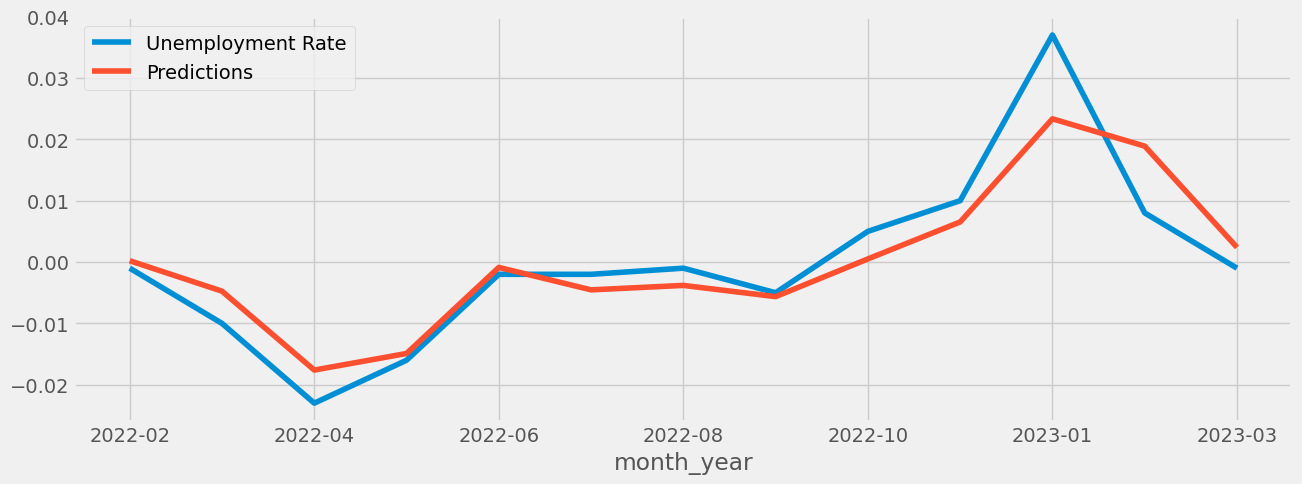

In [420]:
test['Predictions'] = true_predictions
test.plot(figsize=(14,5));

In [421]:
rmse = sqrt(mean_squared_error(test['Unemployment Rate'], test['Predictions']))
print(rmse)

0.005712174741736002


This is our best performant model on San Joaquin county data!


In [451]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(new_list)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

1/1 [==============================] - 0s 212ms/step


In [452]:
test_predictions

[array([0.7782005], dtype=float32),
 array([0.64945394], dtype=float32),
 array([0.475304], dtype=float32),
 array([0.3383236], dtype=float32),
 array([0.22991808], dtype=float32),
 array([0.35265806], dtype=float32),
 array([0.47476363], dtype=float32),
 array([0.48091745], dtype=float32),
 array([0.45897985], dtype=float32),
 array([0.47126436], dtype=float32),
 array([0.563347], dtype=float32),
 array([0.72969997], dtype=float32),
 array([0.81063], dtype=float32),
 array([0.6583163], dtype=float32),
 array([0.45274854], dtype=float32),
 array([0.2857111], dtype=float32),
 array([0.22791106], dtype=float32),
 array([0.36840177], dtype=float32),
 array([0.49684215], dtype=float32),
 array([0.48075557], dtype=float32),
 array([0.45503157], dtype=float32),
 array([0.46965188], dtype=float32),
 array([0.59290874], dtype=float32),
 array([0.78740627], dtype=float32),
 array([0.8440123], dtype=float32)]

In [454]:
test_predictions = pd.DataFrame(test_predictions)

In [455]:
test_predictions['Year'] = new_list

In [456]:
test_predictions = test_predictions.rename(columns = map)

In [457]:
test_predictions = test_predictions.set_index(['Year'])

In [458]:
true_predictions = scaler.inverse_transform(test_predictions)

In [459]:
test_predictions['Predictions'] = true_predictions

In [460]:
tp = test_predictions.iloc[-12:]

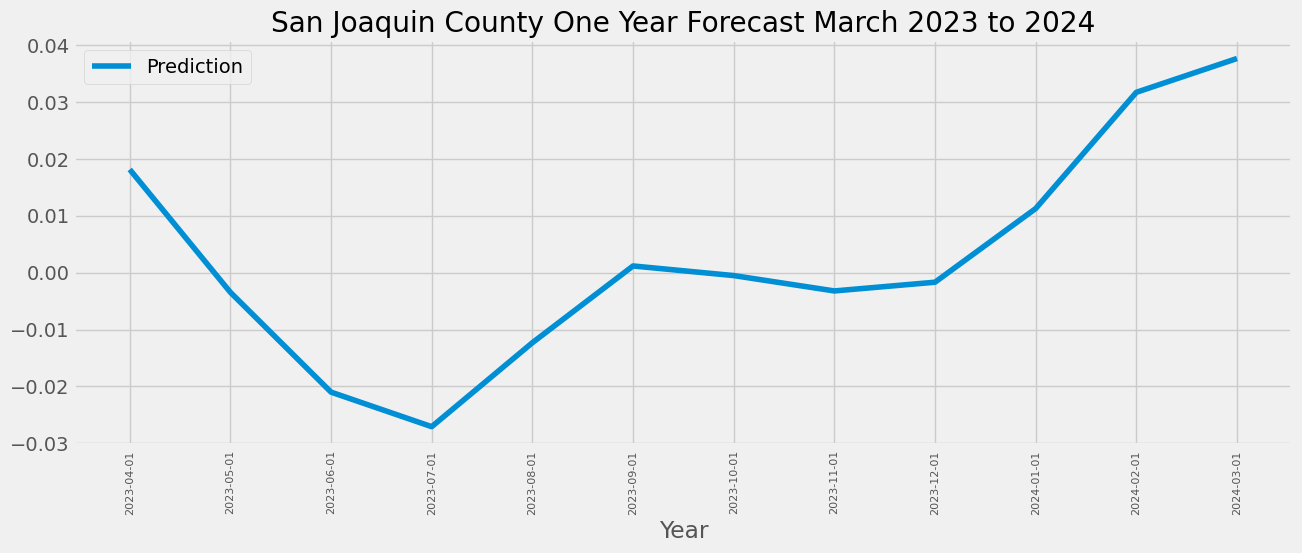

In [461]:
fig, ax = plt.subplots(figsize = (14,5))
plt.xticks(fontsize = 8, rotation = 90)
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax), 1))

ax.plot(tp, label = "Prediction")

ax.set_title('San Joaquin County One Year Forecast March 2023 to 2024')
ax.set_xlabel('Year')
ax.set_xticks(range(0, len(tp), 1))
ax.legend();


## San Joaquin County Educational Program

According to our machine learning model the best time to begin a program could be during the months of April to May, October to March for a 6 month program.
### Limitations of the data and information available

The greatest limitation of data available is the number of actual migrant workers currently in employ in California. The figures that we were able to find were from 2017; this may be smaller or larger in 2023 and could affect the analysis of our potential pool of workers. This could also affect labor pool, employed, unemployed, and unemployment rate numbers.

# Concluding Remarks

Based on the business problem I believe that we have successfully identified a group of workers inside California that would be considered capable of filling the skilled labor gap present in our communities. <br>

The groups of workers in question is ag/migrant workers and though they are critical to the infrastructure and supply of food not only for California, but for the world (California is the fourth largest supplier of crops in the world), Chris Thornberg in his __[presentation to Tulare County officials](https://thesungazette.com/article/news/2022/02/22/economist-chris-thornberg-tells-tulare-county-to-focus-on-workers-workers-workers/)__ stated that there are only three ways to increase the workforce in a region: <br>

- Extensive: increasing labor force through immigration (SR) or birthrates (LR)
- Intensive: raising participation rates among the existing population
- Productivity enhancements: capital investments/ skill training<br>

We have suggested in some part, all three of these measures: <br>

- Extensive: migrant workers support the largest economy in the central valley of California but suffer the largest inequities in regards to pay, shelter, and opportunity for growth; disruption of that business model in the form of an educational program like the one suggested would inevitably shake up the structure of the current and afford more opportunity to incoming migrant workers thus filling the gaps in the laborforce while forcing __[conditions](https://calmatters.org/california-divide/2023/02/farmworkers-conditions-california-report/)__ to improve based on competition with an educational program that would afford migrant workers opportunities to further their upward mobility in America.
- Intensive: migrant workers already live and exist in the central valley of California and suffer from unemployment due to the seasonal nature of their work. Though they are supported by a union and are given the ability to look for work during their times of unemployment, there is no built in educational program that might afford migrant workers the ability to find work.
- Productivity enhancements: skilled labor would be considered a form of skill training; the beauty of skilled labor is that oftentimes once an apprenticeship has begun there are opportunities to be paid for work and at higher rates than what is offered to migrant and seasonal farm workers.